# Introduction

## Goal.
The goal of this lab is to study the application of quality-diversity algorithms, in particular the Multi-dimensional Archive of Phenotypic Elites (MAP-Elites) to various kinds of problems. We will also investigate the parametrization of the algorithm and its effect on the algorithmic performance.

## Getting started. 
In this lab we will use the `qdpy`$^{[1]}$ library, as well as the `deap` library seen in the previous lab. All the exercises are based on the examples available in the library$^{[2]}$, with some modifications. Please note that the `qdpy` library contains many other quality-diversity algorithms, such as Novelty Search, and advanced variants of MAP-Elites. However, in this lab we will use for simplicity only the vanilla version of MAP-Elites.

The basic version of MAP-Elites is shown in Algorithm 1. In the pseudo-code, $\textbf{x}$ and $\textbf{x}'$ are candidate solutions (i.e., $n$-dimensional vectors defined in the search space $\textbf{D}$); $\textbf{b}'$ is a *feature descriptor*, that is a location in a user-defined *discretized* feature space (which can be seen as a *grid* made of *bins*), corresponding to the candidate solution $\textbf{x}'$, (i.e., an $N$-dimensional vector of user-defined features that characterize $\textbf{x}'$, typically with $N<n$); $p'$ is the performance of the candidate solution $\textbf{x}'$ (i.e., the scalar value returned by the objective function $f(\textbf{x}')$; $\mathcal{P}$ is a $<$feature descriptor, performance$>$ map (i.e., an associative table that stores the best performance associated to each feature descriptor encountered by the algorithm); $\mathcal{X}$ is a $<$feature descriptor, solution$>$ map (i.e., an associative table that stores the best solution associated to each feature descriptor encountered by the algorithm); $\mathcal{P}(\textbf{b}')$ is the best performance associated to the feature descriptor $\textbf{b}'$ (it can be empty); $\mathcal{X}(\textbf{b}')$ is the best solution associated to the feature descriptor $\textbf{b}'$ (it can be empty).

![alg1.png](img/img_12/alg1.png)

Following the pseudo-code shown above, the algorithm first creates the two maps $\mathcal{P}$ and $\mathcal{X}$, which are initially empty. Then, a while loop is executed until a given stop criterion is not met (usually, on the maximum number of function evaluations). Each iteration of the loop evaluates a *batch* of solutions. In the first batch, a given number of solutions are randomly sampled, see the `randomSolution()` function, in the search space $\textbf{D}$, which are used for initializing the two maps $\mathcal{P}$ and $\mathcal{X}$. Then, starting from the next iteration, solutions are first randomly selected from the current map $\mathcal{X}$, through the randomSelection() operator, and then perturbed according to the `randomVariation()` operator. For each new solution $\textbf{x}'$, the corresponding feature descriptor $\textbf{b}'$ and performance $p'$ are then evaluated. At this point, the two maps $\mathcal{P}$ and $\mathcal{X}$ are updated: if the performance associated to $\textbf{b}'$, $\mathcal{P}(\textbf{b}')$, is empty (which can happen if this is the first time that the algorithm generates a solution with that feature descriptor), or if it contains a value that is worse than the performance $p'$ of the newly generated solution (in the pseudo-code, we assume a minimization problem, therefore we check the condition $\mathcal{P}(\textbf{b}') > p'$), the new solution $\textbf{x}'$ and its performance $p'$ are assigned to the elements of the maps corresponding to its feature descriptor $\textbf{b}'$, namely $\mathcal{P}(\textbf{b}')$ and $\mathcal{X}(\textbf{b}')$. Once the loop terminates, the algorithm returns the two maps $\mathcal{P}$ and $\mathcal{X}$, which can be later analyzed for further inspection and post-processing.

It can be immediately noted how simple the algorithm is. With reference to the pseudo-code, in order to apply MAP-Elites to a specific problem the following methods must be defined:

 - $\textrm{randomSolution()}$: returns a randomly generated solution;
 - $\textrm{randomSelection($\mathcal{X}$)}$: randomly selects a solution from $\mathcal{X}$;
 - $\textrm{randomVariation($\textbf{x}$)}$: returns a modified copy of $\textbf{x}$;
 - $\textrm{featureDescriptor}(\textbf{x})$: maps a candidate solution $\textbf{x}$ to its feature descriptor, $\textbf{b}$;
 - $\textrm{performance}(\textbf{x})$: evaluates the objective function of the candidate solution $\textbf{x}$.

The first three methods are rather standard, i.e., they can be based on general-purpose operators typically used in EAs. However, it is possible to customize them according to the specific need. For instance, in the first two exercises of this lab we will use uniform random sampling and uniform random selection for the first two operators. For the variation operator, we will use the `RandomSearchMutPolyBounded` operator provided by `qdpy`, which essentially performs uniform random mutations with a saturation on the bounds of the search space. In the third exercise, we will use instead the typical operators of Genetic Programming.

As for what concerns $\textrm{featureDescriptor}(\textbf{x})$ and $\textrm{performance}(\textbf{x})$, these are obviously problem-dependent: the first one, being dependent on how the user defines the features of interest and the corresponding feature space; the latter, being dependent on the specific objective function at hand. In the exercises, we will see different definitions of performances and descriptors.

---
[1]: A Quality-Diversity framework for Python 3.6+: https://gitlab.com/leo.cazenille/qdpy

[2]: Examples avaiable at https://gitlab.com/leo.cazenille/qdpy/-/tree/master/examples

# Exercise 1
In this exercise, we will use MAP-Elites to _illuminate_ the feature space of a benchmark function that we have already used in some of the first labs, namely the Rastrigin function$^{[1]}$, which as you may remember is a highly multimodal problem.

For simplicity, we will use as feature descriptor for MAP-Elites the first two variables of the problem. Note however that, in general, the features used in MAP-Elites can be any property (different from the fitness function) of the solutions to the problem at hand.

To start the experiments, run the next cell. This will allow you to reproduce your results. At the end of the run, the script will generate a series of plots (see the figure below) in the `results/ex1/seed` directory, namely: 

 - **`activityGrid.pdf`:** this map indicates, for each bin, how many times that bin has been updated (i.e., its elite has been replaced) during the evolutionary process;
 - **`evals_contsize.pdf`:** this trend indicates the cumulative number of bins filled during the evolutionary process; 
 - **`evals_fitnessmax0.pdf`:** this trend is the usual fitness trend that we have seen in the previous labs (note: in this case the fitness has to be minimized);
 - **`iterations_nbupdated.pdf`:** this trend indicates how many bins are updated at each iteration of MAP-Elites;
 - **`performancesGrid.pdf`:** this is the final _illumination_ map that shows how the performance of the elites changes depending on the features at hand (brighter color indicates better results-note that the fitness is normalized in [0,1]).

The main outputs of the experiments of the first exercise are an *activity grid* (see the figure below, left), and a *performance grid* (see the figure below, right). More plots are available in the exercise folder after the execution of the experiments.

![ex1.png](img/img_12/ex1.png)

Furthermore, the script will serialize the final version of the map handled by MAP-Elites in a pickle file named `final.p`, that can be deserialized and manipulated for further analysis.

 - **What kind of considerations can you make regarding the fitness trend** (Is the algorithm able to converge to a reasonably low fitness function? How quick is the convergence?), **and the activity grid** (For instance, are there regions of the feature space that are visited/updated more frequently than others?). **What kind of illumination pattern do you observe? Do you see any trend/correlation between performance and features of the map?**
    
 - Try to change the parameters of the MAP-Elites algorithm, i.e.,: `NO_BINS`, `MAX_ITEMS_BIN`, `BUDGET`, `BATCH_SIZE`, which indicate, respectively, the number of bins (that is the same for both features), the maximum number of items stored in each bin of the grid, the total budget of the evolutionary process (number of function evaluations), and the batch size, i.e., how many solutions are evaluated at each iteration of MAP-Elites. **Focus in particular on `NO_BINS`. What is the effect on the fitness trend and the performance map when you increase or decrease the number of bins?**
    
 - Try to change the problem dimension (`PROBLEM_DIM`) to a much larger value, for instance 10 (remember that Rastrigin is a scalable benchmark problem, meaning that it can be defined for any number of variables). Note that in any case the first two variables are taken as features for MAP-Elites. **What kind of considerations can you make in this case regarding the illumination pattern and the other aspects (i.e., the fitness trend and the activity grid) of the results? Does illumination become more difficult (i.e., less bins are visited, with poorer performance)? Why?**

---

[1]: Rastrigin function https://pythonhosted.org/inspyred/reference.html\#inspyred.benchmarks.Rastrigin

If a cell in the MAP-Elites algorithm is updated many times, it typically indicates that the corresponding region of the search space contains highly fit individuals or phenotypic elites. Here are a few key implications of a cell being updated multiple times. <br>
If a cell in MAP-Elites is updated multiple times, it implies that the algorithm has identified a promising region with highly fit individuals and is continuously refining and exploring that region to achieve even better solutions. It highlights the importance of that region in the search space and signifies the presence of phenotypic elites within it.

In [32]:
import qdpy
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
from utils.utils_12.exercise_rastrigin import main

### NO_BINS = 8, 3D

Seed: 740520



  1%|▍                                                              | 61/10000 [00:00<01:28, 111.79eval/s, iteration=0]


  1%|▊                                                             | 124/10000 [00:01<01:23, 118.51eval/s, iteration=0]


  2%|█▏                                                            | 187/10000 [00:01<01:23, 117.76eval/s, iteration=0]


  2%|█▌                                                             | 249/10000 [00:02<01:39, 98.18eval/s, iteration=0]


  3%|█▉                                                            | 312/10000 [00:02<01:22, 118.11eval/s, iteration=0]


  4%|██▎                                                           | 375/10000 [00:03<01:21, 118.12eval/s, iteration=0]


  4%|██▋                                                           | 439/10000 [00:03<01:14, 128.52eval/s, iteration=0]


  5%|███                                                           | 498/10000 [00:04<01:11, 133.09eval/s, iteration=0]
                                                                                                                       


alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed


 62%|█████████████████████████████████████▎                      | 6229/10000 [02:51<00:14, 252.18eval/s, iteration=12]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     0         64/64     500       177            [0.2548]  [0.0999]  [0.0667]  [0.4996]  [0.0069,0.0151]     [0.9952,0.9747]     47.69     4.37   


  6%|███▍                                                          | 561/10000 [00:05<01:18, 120.96eval/s, iteration=1]


  6%|███▉                                                          | 626/10000 [00:05<01:01, 152.19eval/s, iteration=1]


  7%|████▎                                                         | 689/10000 [00:05<01:14, 124.60eval/s, iteration=1]


  8%|████▋                                                         | 753/10000 [00:06<01:12, 127.20eval/s, iteration=1]


  8%|█████                                                         | 816/10000 [00:06<01:11, 127.66eval/s, iteration=1]


  9%|█████▍                                                        | 880/10000 [00:07<01:08, 132.69eval/s, iteration=1]


  9%|█████▊                                                        | 943/10000 [00:07<01:23, 108.22eval/s, iteration=1]


 10%|██████▏                                                       | 998/10000 [00:08<01:16, 117.13eval/s, iteration=1]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     1         64/64     500       55             [0.2167]  [0.081]   [0.0658]  [0.3885]  [0.0158,0.0105]     [0.9924,0.9747]     50.13     4.05   


 11%|██████▍                                                      | 1060/10000 [00:09<01:27, 102.54eval/s, iteration=2]


 11%|██████▊                                                      | 1124/10000 [00:09<01:06, 134.28eval/s, iteration=2]


 12%|███████▏                                                     | 1187/10000 [00:10<01:07, 130.74eval/s, iteration=2]


 13%|███████▋                                                     | 1251/10000 [00:10<01:11, 122.07eval/s, iteration=2]


 13%|████████                                                     | 1314/10000 [00:11<01:14, 116.11eval/s, iteration=2]


 14%|████████▍                                                    | 1377/10000 [00:11<01:07, 127.26eval/s, iteration=2]


 14%|████████▊                                                    | 1441/10000 [00:12<00:55, 153.52eval/s, iteration=2]


 15%|█████████▏                                                   | 1498/10000 [00:12<00:52, 160.48eval/s, iteration=2]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     2         64/64     500       37             [0.1912]  [0.0781]  [0.0512]  [0.3709]  [0.0158,0.0116]     [0.9924,0.8962]     51.76     4.04   


 16%|█████████▌                                                   | 1561/10000 [00:13<01:03, 133.21eval/s, iteration=3]


 16%|█████████▉                                                   | 1625/10000 [00:13<01:03, 131.26eval/s, iteration=3]


 17%|██████████▎                                                  | 1689/10000 [00:14<01:03, 131.57eval/s, iteration=3]


 18%|██████████▋                                                  | 1753/10000 [00:14<00:52, 157.20eval/s, iteration=3]


 18%|███████████                                                  | 1817/10000 [00:14<00:59, 138.12eval/s, iteration=3]


 19%|███████████▍                                                 | 1881/10000 [00:15<00:53, 150.51eval/s, iteration=3]


 19%|███████████▊                                                 | 1945/10000 [00:15<00:53, 151.61eval/s, iteration=3]


 20%|████████████▏                                                | 1998/10000 [00:16<00:50, 159.14eval/s, iteration=3]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     3         64/64     500       29             [0.1768]  [0.0772]  [0.0512]  [0.3454]  [0.0158,0.0116]     [0.9924,0.8984]     52.68     3.58   


 21%|████████████▌                                                | 2061/10000 [00:16<00:56, 141.63eval/s, iteration=4]


 21%|████████████▉                                                | 2126/10000 [00:17<00:53, 147.96eval/s, iteration=4]


 22%|█████████████▎                                               | 2190/10000 [00:17<00:51, 152.19eval/s, iteration=4]


 23%|█████████████▋                                               | 2254/10000 [00:17<00:46, 167.00eval/s, iteration=4]


 23%|██████████████▏                                              | 2318/10000 [00:18<00:47, 161.69eval/s, iteration=4]


 24%|██████████████▌                                              | 2382/10000 [00:18<00:50, 150.49eval/s, iteration=4]


 24%|██████████████▉                                              | 2447/10000 [00:19<00:49, 153.19eval/s, iteration=4]


 25%|███████████████▏                                             | 2498/10000 [00:19<00:52, 143.54eval/s, iteration=4]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     4         64/64     500       22             [0.1688]  [0.0761]  [0.0485]  [0.3451]  [0.0137,0.0116]     [0.9924,0.9047]     53.20     3.41   


 26%|███████████████▌                                             | 2561/10000 [00:20<01:00, 122.29eval/s, iteration=5]


 26%|████████████████                                             | 2625/10000 [00:20<00:50, 147.17eval/s, iteration=5]


 27%|████████████████▍                                            | 2690/10000 [00:21<00:47, 152.68eval/s, iteration=5]


 28%|████████████████▊                                            | 2754/10000 [00:21<00:49, 147.40eval/s, iteration=5]


 28%|█████████████████▏                                           | 2818/10000 [00:21<00:41, 171.03eval/s, iteration=5]


 29%|█████████████████▌                                           | 2883/10000 [00:22<00:43, 164.33eval/s, iteration=5]


 29%|█████████████████▉                                           | 2947/10000 [00:22<00:41, 168.77eval/s, iteration=5]


 30%|██████████████████▎                                          | 2998/10000 [00:22<00:41, 167.51eval/s, iteration=5]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     5         64/64     500       30             [0.1596]  [0.074]   [0.0377]  [0.3291]  [0.0078,0.0168]     [0.9034,0.9047]     53.79     3.32   


 31%|██████████████████▋                                          | 3061/10000 [00:23<01:03, 109.99eval/s, iteration=6]


 31%|███████████████████                                          | 3125/10000 [00:24<00:49, 139.37eval/s, iteration=6]


 32%|███████████████████▍                                         | 3188/10000 [00:24<00:49, 136.38eval/s, iteration=6]


 33%|███████████████████▊                                         | 3252/10000 [00:25<00:50, 132.55eval/s, iteration=6]


 33%|████████████████████▏                                        | 3317/10000 [00:25<00:41, 161.95eval/s, iteration=6]


 34%|████████████████████▌                                        | 3381/10000 [00:25<00:40, 164.79eval/s, iteration=6]


 34%|█████████████████████                                        | 3445/10000 [00:26<00:46, 140.01eval/s, iteration=6]


 35%|█████████████████████▎                                       | 3498/10000 [00:26<00:39, 162.83eval/s, iteration=6]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     6         64/64     500       21             [0.1506]  [0.0711]  [0.0377]  [0.3092]  [0.0238,0.0168]     [0.9034,0.9047]     54.36     3.59   


 36%|█████████████████████▋                                       | 3561/10000 [00:27<00:49, 130.47eval/s, iteration=7]


 36%|██████████████████████                                       | 3625/10000 [00:27<00:48, 131.53eval/s, iteration=7]


 37%|██████████████████████▌                                      | 3689/10000 [00:28<00:41, 152.96eval/s, iteration=7]


 38%|██████████████████████▉                                      | 3753/10000 [00:28<00:42, 146.56eval/s, iteration=7]


 38%|███████████████████████▎                                     | 3816/10000 [00:29<00:48, 126.87eval/s, iteration=7]


 39%|███████████████████████▋                                     | 3880/10000 [00:29<00:44, 136.40eval/s, iteration=7]


 39%|████████████████████████                                     | 3944/10000 [00:29<00:41, 147.12eval/s, iteration=7]


 40%|████████████████████████▍                                    | 3998/10000 [00:30<00:38, 157.72eval/s, iteration=7]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     7         64/64     500       15             [0.1472]  [0.0708]  [0.0377]  [0.3092]  [0.0921,0.0168]     [0.9034,0.9047]     54.58     3.65   


 41%|████████████████████████▊                                    | 4061/10000 [00:31<00:51, 115.36eval/s, iteration=8]


 41%|█████████████████████████▏                                   | 4125/10000 [00:31<00:41, 139.98eval/s, iteration=8]


 42%|█████████████████████████▌                                   | 4189/10000 [00:31<00:43, 135.03eval/s, iteration=8]


 43%|█████████████████████████▉                                   | 4253/10000 [00:32<00:36, 156.08eval/s, iteration=8]


 43%|██████████████████████████▎                                  | 4317/10000 [00:32<00:39, 143.25eval/s, iteration=8]


 44%|██████████████████████████▋                                  | 4381/10000 [00:33<00:40, 138.65eval/s, iteration=8]


 44%|███████████████████████████                                  | 4444/10000 [00:33<00:40, 135.86eval/s, iteration=8]


 45%|███████████████████████████▍                                 | 4498/10000 [00:34<00:36, 151.17eval/s, iteration=8]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     8         64/64     500       16             [0.144]   [0.0713]  [0.0179]  [0.3092]  [0.0921,0.0168]     [0.9034,0.9047]     54.78     3.79   


 46%|███████████████████████████▊                                 | 4561/10000 [00:34<00:48, 112.48eval/s, iteration=9]


 46%|████████████████████████████▏                                | 4625/10000 [00:35<00:33, 161.31eval/s, iteration=9]


 47%|████████████████████████████▌                                | 4690/10000 [00:35<00:31, 171.12eval/s, iteration=9]


 48%|████████████████████████████▉                                | 4754/10000 [00:35<00:28, 182.56eval/s, iteration=9]


 48%|█████████████████████████████▍                               | 4819/10000 [00:36<00:28, 180.35eval/s, iteration=9]


 49%|█████████████████████████████▊                               | 4884/10000 [00:36<00:28, 178.18eval/s, iteration=9]


 49%|██████████████████████████████▏                              | 4948/10000 [00:36<00:29, 174.15eval/s, iteration=9]


 50%|██████████████████████████████▍                              | 4998/10000 [00:37<00:29, 169.07eval/s, iteration=9]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     9         64/64     500       13             [0.1412]  [0.0694]  [0.009]   [0.2943]  [0.0921,0.0143]     [0.9987,0.9047]     54.96     3.10   


 51%|██████████████████████████████▎                             | 5062/10000 [00:37<00:40, 123.03eval/s, iteration=10]


 51%|██████████████████████████████▊                             | 5126/10000 [00:38<00:29, 163.03eval/s, iteration=10]


 52%|███████████████████████████████▏                            | 5190/10000 [00:38<00:35, 134.28eval/s, iteration=10]


 53%|███████████████████████████████▌                            | 5254/10000 [00:39<00:32, 147.44eval/s, iteration=10]


 53%|███████████████████████████████▉                            | 5318/10000 [00:39<00:35, 133.39eval/s, iteration=10]


 54%|████████████████████████████████▎                           | 5382/10000 [00:40<00:38, 121.36eval/s, iteration=10]


 54%|████████████████████████████████▋                           | 5445/10000 [00:40<00:32, 141.63eval/s, iteration=10]


 55%|████████████████████████████████▉                           | 5498/10000 [00:40<00:31, 144.82eval/s, iteration=10]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     10        64/64     500       17             [0.1372]  [0.0665]  [0.009]   [0.2943]  [0.0921,0.0143]     [0.9034,0.9047]     55.22     3.68   


 56%|█████████████████████████████████▎                          | 5561/10000 [00:41<00:36, 122.42eval/s, iteration=11]


 56%|█████████████████████████████████▊                          | 5625/10000 [00:41<00:29, 147.83eval/s, iteration=11]


 57%|██████████████████████████████████▏                         | 5689/10000 [00:42<00:29, 147.99eval/s, iteration=11]


 58%|██████████████████████████████████▌                         | 5753/10000 [00:42<00:28, 150.92eval/s, iteration=11]


 58%|██████████████████████████████████▉                         | 5817/10000 [00:43<00:27, 153.41eval/s, iteration=11]


 59%|███████████████████████████████████▎                        | 5881/10000 [00:43<00:29, 137.96eval/s, iteration=11]


 59%|███████████████████████████████████▋                        | 5945/10000 [00:44<00:27, 148.38eval/s, iteration=11]


 60%|███████████████████████████████████▉                        | 5999/10000 [00:44<00:27, 146.97eval/s, iteration=11]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     11        64/64     500       15             [0.1341]  [0.0669]  [0.009]   [0.2852]  [0.0921,0.0143]     [0.9034,0.9047]     55.42     3.55   


 61%|████████████████████████████████████▎                       | 6062/10000 [00:45<00:31, 123.60eval/s, iteration=12]


 61%|████████████████████████████████████▊                       | 6125/10000 [00:45<00:26, 145.06eval/s, iteration=12]


 62%|█████████████████████████████████████▏                      | 6189/10000 [00:45<00:27, 139.77eval/s, iteration=12]


 63%|█████████████████████████████████████▌                      | 6253/10000 [00:46<00:26, 141.88eval/s, iteration=12]


 63%|█████████████████████████████████████▉                      | 6317/10000 [00:46<00:23, 157.70eval/s, iteration=12]


 64%|██████████████████████████████████████▎                     | 6381/10000 [00:47<00:26, 135.10eval/s, iteration=12]


 64%|██████████████████████████████████████▋                     | 6446/10000 [00:47<00:23, 151.38eval/s, iteration=12]


 65%|██████████████████████████████████████▉                     | 6498/10000 [00:48<00:23, 151.09eval/s, iteration=12]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     12        64/64     500       13             [0.1321]  [0.067]   [0.009]   [0.2827]  [0.0952,0.0143]     [0.9034,0.9047]     55.55     3.59   


 66%|███████████████████████████████████████▎                    | 6561/10000 [00:48<00:27, 126.85eval/s, iteration=13]


 66%|███████████████████████████████████████▊                    | 6626/10000 [00:49<00:22, 149.35eval/s, iteration=13]


 67%|████████████████████████████████████████▏                   | 6690/10000 [00:49<00:22, 148.75eval/s, iteration=13]


 68%|████████████████████████████████████████▌                   | 6753/10000 [00:50<00:26, 124.86eval/s, iteration=13]


 68%|████████████████████████████████████████▉                   | 6817/10000 [00:50<00:21, 148.96eval/s, iteration=13]


 69%|█████████████████████████████████████████▎                  | 6881/10000 [00:50<00:23, 131.39eval/s, iteration=13]


 69%|█████████████████████████████████████████▋                  | 6945/10000 [00:51<00:22, 136.39eval/s, iteration=13]


 70%|█████████████████████████████████████████▉                  | 6998/10000 [00:51<00:22, 135.85eval/s, iteration=13]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     13        64/64     500       11             [0.1307]  [0.0673]  [0.0073]  [0.2827]  [0.0952,0.0143]     [0.9034,0.9047]     55.63     3.71   


 71%|██████████████████████████████████████████▎                 | 7061/10000 [00:52<00:24, 120.36eval/s, iteration=14]


 71%|██████████████████████████████████████████▊                 | 7125/10000 [00:52<00:19, 145.74eval/s, iteration=14]


 72%|███████████████████████████████████████████▏                | 7190/10000 [00:53<00:17, 158.41eval/s, iteration=14]


 73%|███████████████████████████████████████████▌                | 7254/10000 [00:53<00:19, 143.18eval/s, iteration=14]


 73%|███████████████████████████████████████████▉                | 7318/10000 [00:54<00:17, 151.34eval/s, iteration=14]


 74%|████████████████████████████████████████████▎               | 7382/10000 [00:54<00:17, 151.38eval/s, iteration=14]


 74%|████████████████████████████████████████████▋               | 7446/10000 [00:54<00:16, 153.09eval/s, iteration=14]


 75%|████████████████████████████████████████████▉               | 7498/10000 [00:55<00:18, 137.38eval/s, iteration=14]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     14        64/64     500       15             [0.1288]  [0.066]   [0.0073]  [0.2827]  [0.0952,0.1017]     [0.9034,0.9047]     55.76     3.55   


 76%|█████████████████████████████████████████████▎              | 7561/10000 [00:56<00:20, 120.59eval/s, iteration=15]


 76%|█████████████████████████████████████████████▊              | 7625/10000 [00:56<00:16, 145.37eval/s, iteration=15]


 77%|██████████████████████████████████████████████▏             | 7689/10000 [00:56<00:15, 146.66eval/s, iteration=15]


 78%|██████████████████████████████████████████████▌             | 7753/10000 [00:57<00:14, 151.12eval/s, iteration=15]


 78%|██████████████████████████████████████████████▉             | 7818/10000 [00:57<00:13, 162.97eval/s, iteration=15]


 79%|███████████████████████████████████████████████▎            | 7882/10000 [00:58<00:12, 168.69eval/s, iteration=15]


 79%|███████████████████████████████████████████████▋            | 7946/10000 [00:58<00:13, 151.12eval/s, iteration=15]


 80%|███████████████████████████████████████████████▉            | 7998/10000 [00:58<00:11, 168.14eval/s, iteration=15]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     15        64/64     500       13             [0.1273]  [0.0646]  [0.0073]  [0.2698]  [0.0952,0.1018]     [0.8904,0.9047]     55.85     3.35   


 81%|████████████████████████████████████████████████▎           | 8061/10000 [00:59<00:14, 134.10eval/s, iteration=16]


 81%|████████████████████████████████████████████████▊           | 8125/10000 [00:59<00:13, 137.16eval/s, iteration=16]


 82%|█████████████████████████████████████████████████▏          | 8189/10000 [01:00<00:12, 147.54eval/s, iteration=16]


 83%|█████████████████████████████████████████████████▌          | 8253/10000 [01:00<00:11, 153.77eval/s, iteration=16]


 83%|█████████████████████████████████████████████████▉          | 8317/10000 [01:01<00:10, 161.80eval/s, iteration=16]


 84%|██████████████████████████████████████████████████▎         | 8381/10000 [01:01<00:09, 165.59eval/s, iteration=16]


 84%|██████████████████████████████████████████████████▋         | 8446/10000 [01:01<00:09, 157.24eval/s, iteration=16]


 85%|██████████████████████████████████████████████████▉         | 8498/10000 [01:02<00:09, 157.93eval/s, iteration=16]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     16        64/64     500       8              [0.1267]  [0.0649]  [0.0073]  [0.2698]  [0.0952,0.1018]     [0.8904,0.9047]     55.89     3.42   


 86%|███████████████████████████████████████████████████▎        | 8561/10000 [01:02<00:11, 123.06eval/s, iteration=17]


 86%|███████████████████████████████████████████████████▊        | 8625/10000 [01:03<00:09, 144.20eval/s, iteration=17]


 87%|████████████████████████████████████████████████████▏       | 8689/10000 [01:03<00:08, 149.23eval/s, iteration=17]


 88%|████████████████████████████████████████████████████▌       | 8753/10000 [01:04<00:07, 156.28eval/s, iteration=17]


 88%|████████████████████████████████████████████████████▉       | 8818/10000 [01:04<00:07, 159.96eval/s, iteration=17]


 89%|█████████████████████████████████████████████████████▎      | 8882/10000 [01:04<00:07, 158.68eval/s, iteration=17]


 89%|█████████████████████████████████████████████████████▋      | 8946/10000 [01:05<00:07, 140.43eval/s, iteration=17]


 90%|█████████████████████████████████████████████████████▉      | 8998/10000 [01:05<00:06, 148.05eval/s, iteration=17]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     17        64/64     500       8              [0.1247]  [0.0634]  [0.0073]  [0.2698]  [0.0952,0.1018]     [0.8904,0.9047]     56.02     3.51   


 91%|██████████████████████████████████████████████████████▎     | 9061/10000 [01:06<00:07, 125.90eval/s, iteration=18]


 91%|██████████████████████████████████████████████████████▊     | 9125/10000 [01:06<00:05, 149.52eval/s, iteration=18]


 92%|███████████████████████████████████████████████████████▏    | 9189/10000 [01:07<00:04, 162.90eval/s, iteration=18]


 93%|███████████████████████████████████████████████████████▌    | 9253/10000 [01:07<00:04, 161.33eval/s, iteration=18]


 93%|███████████████████████████████████████████████████████▉    | 9318/10000 [01:07<00:04, 158.96eval/s, iteration=18]


 94%|████████████████████████████████████████████████████████▎   | 9382/10000 [01:08<00:03, 156.30eval/s, iteration=18]


 94%|████████████████████████████████████████████████████████▋   | 9446/10000 [01:08<00:03, 153.24eval/s, iteration=18]


 95%|████████████████████████████████████████████████████████▉   | 9498/10000 [01:09<00:03, 160.61eval/s, iteration=18]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     18        64/64     500       9              [0.1234]  [0.0626]  [0.0073]  [0.2698]  [0.0952,0.1018]     [0.8948,0.9047]     56.10     3.35   


 96%|█████████████████████████████████████████████████████████▎  | 9561/10000 [01:09<00:03, 127.62eval/s, iteration=19]


 96%|█████████████████████████████████████████████████████████▊  | 9625/10000 [01:10<00:02, 148.61eval/s, iteration=19]


 97%|██████████████████████████████████████████████████████████▏ | 9689/10000 [01:10<00:02, 130.48eval/s, iteration=19]


 98%|██████████████████████████████████████████████████████████▌ | 9753/10000 [01:11<00:01, 150.78eval/s, iteration=19]


 98%|██████████████████████████████████████████████████████████▉ | 9817/10000 [01:11<00:01, 150.15eval/s, iteration=19]


 99%|███████████████████████████████████████████████████████████▎| 9881/10000 [01:11<00:00, 159.25eval/s, iteration=19]


 99%|███████████████████████████████████████████████████████████▋| 9945/10000 [01:12<00:00, 163.57eval/s, iteration=19]


100%|███████████████████████████████████████████████████████████▉| 9998/10000 [01:12<00:00, 159.12eval/s, iteration=19]
                                                                                                                       


RandomSearchMutPolyBounded-2010995553712     19        64/64     500       12             [0.1223]  [0.0627]  [0.0073]  [0.2698]  [0.0952,0.1018]     [0.8904,0.9047]     56.17     3.44   


 62%|█████████████████████████████████████▎                      | 6229/10000 [03:59<00:14, 252.18eval/s, iteration=12]
                                                                                                                       


Finished optimisation using algorithm 'RandomSearchMutPolyBounded-2010995553712'. Total elapsed: 72.59378709999964.


100%|███████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 159.12eval/s, iteration=19]
                                                                                                                       


Summary RandomSearchMutPolyBounded:
  batch_size: 500
  budget: 10000
  container:  Summary Grid:
    activity_per_bin: [[11. 16.  4.  5. 11. 11.  8. 11.]  [ 5.  6.  9. 10.  9. 11.  7. 13.]  [ 7.  8.  6.  9.  5.  8.  5. 10.]  [ 6.  7.  7.  7.  9.  5.  8.  7.]  [10.  8. 10.  5.  7.  7.  5.  9.]  [15.  8. 13.  7. 11.  8.  6.  7.]  [11. 11.  7.  8. 11.  4.  7. 13.]  ...
    best: Individual([0.503665548635007, 0.5055689203123269, 0.4978033740042622])
    best_features: [0.503665548635007, 0.5055689203123269]
    best_fitness: (0.007333631171182629,)
    best_index: (4, 4)
    capacity: 64
    depot: None
    discard_random_on_bin_overload: False
    features: {(0, 0): [Features([0.11710456401079172, 0.10952561330673083])], (0, 1): [Features([0.0951776343233739, 0.2054994675798273])], (0, 2): [Features([0.11440610655507322, 0.30650243391365806])], (0, 3): [Features([0.11003942777195419, 0.397278203230 ...
    features_domain: ((0.0, 1.0), (0.0, 1.0))
    features_extrema: ((0.095177634323

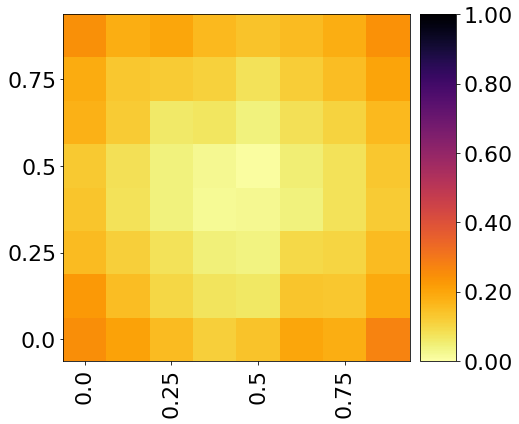

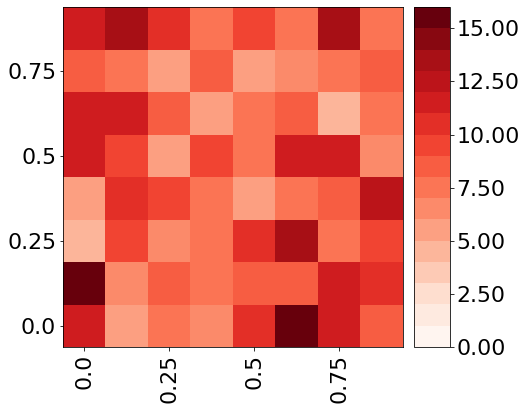

In [46]:
# TODO: change these parameters
NO_BINS=8          # default 32
MAX_ITEMS_BIN=1     # default 1
BUDGET=10000        # default 10000
BATCH_SIZE=500      # default 500
PROBLEM_DIM=3       # default 3

"""
-------------------------------------------------------------------------
"""
main(NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [48]:
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex1\8 BIN\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES: ",grid.best.features)

GRID BEST:  Individual([0.503665548635007, 0.5055689203123269, 0.4978033740042622])
GRID BEST FITNESS:  (0.007333631171182629,)
GRID BEST FEATURES:  [0.503665548635007, 0.5055689203123269]


### NO_BINS = 8, 10D

Seed: 486610


alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed


RandomSearchMutPolyBounded-2011096869040     0         64/64     500       163            [0.3108]  [0.0522]  [0.1922]  [0.4495]  [0.0870,0.0011]     [0.9835,0.9834]     44.11     1.20   


RandomSearchMutPolyBounded-2011096869040     1         64/64     500       73             [0.2791]  [0.0429]  [0.1858]  [0.3821]  [0.0288,0.0011]     [0.9835,0.9834]     46.14     1.25   


RandomSearchMutPolyBounded-2011096869040     2         64/64     500       69             [0.2562]  [0.041]   [0.1695]  [0.328]   [0.0967,0.0011]     [0.9697,0.9962]     47.60     1.02   


RandomSearchMutPolyBounded-2011096869040     3         64/64     500       53             [0.2394]  [0.0429]  [0.1205]  [0.3207]  [0.0967,0.0060]     [0.9697,0.9981]     48.68     0.86   


RandomSearchMutPolyBounded-2011096869040     4         64/64     500       46             [0.2264]  [0.0426]  [0.1205]  [0.3207]  [0.1012,0.0060]     [0.9697,0.9981]     49.51     0.91   


RandomSearchMutPolyBounded-2011096869040     5         64/64     500       40             [0.2181]  [0.0405]  [0.1205]  [0.3023]  [0.1012,0.0060]     [0.9697,0.9981]     50.04     0.82   


RandomSearchMutPolyBounded-2011096869040     6         64/64     500       46             [0.2034]  [0.036]   [0.1205]  [0.2895]  [0.0912,0.0060]     [0.9697,0.9981]     50.98     0.90   


RandomSearchMutPolyBounded-2011096869040     7         64/64     500       35             [0.1974]  [0.0357]  [0.1205]  [0.2895]  [0.0912,0.0060]     [0.9697,0.9981]     51.37     0.93   


RandomSearchMutPolyBounded-2011096869040     8         64/64     500       29             [0.1914]  [0.0352]  [0.1051]  [0.263]   [0.0912,0.0060]     [0.9697,0.9981]     51.75     0.96   


RandomSearchMutPolyBounded-2011096869040     9         64/64     500       29             [0.1861]  [0.0363]  [0.0875]  [0.263]   [0.0912,0.0130]     [0.9697,0.9981]     52.09     0.92   


RandomSearchMutPolyBounded-2011096869040     10        64/64     500       28             [0.1802]  [0.0369]  [0.0875]  [0.2579]  [0.0173,0.0130]     [0.9975,0.9981]     52.47     0.86   


RandomSearchMutPolyBounded-2011096869040     11        64/64     500       27             [0.1759]  [0.0365]  [0.0875]  [0.2579]  [0.0173,0.0130]     [0.9975,0.9981]     52.74     0.89   


RandomSearchMutPolyBounded-2011096869040     12        64/64     500       36             [0.1684]  [0.0344]  [0.0875]  [0.2496]  [0.0912,0.0130]     [0.9975,0.9981]     53.22     0.90   


RandomSearchMutPolyBounded-2011096869040     13        64/64     500       28             [0.1644]  [0.0341]  [0.0875]  [0.2386]  [0.0912,0.0130]     [0.9975,0.9981]     53.48     0.97   


RandomSearchMutPolyBounded-2011096869040     14        64/64     500       27             [0.1604]  [0.033]   [0.0875]  [0.2312]  [0.0375,0.0130]     [0.9975,0.9981]     53.73     0.93   


RandomSearchMutPolyBounded-2011096869040     15        64/64     500       30             [0.1559]  [0.0327]  [0.0875]  [0.2312]  [0.0375,0.0130]     [0.9975,0.9981]     54.02     0.98   


RandomSearchMutPolyBounded-2011096869040     16        64/64     500       18             [0.1538]  [0.0313]  [0.0875]  [0.2115]  [0.0375,0.0130]     [0.9975,0.9981]     54.16     0.91   


RandomSearchMutPolyBounded-2011096869040     17        64/64     500       22             [0.1509]  [0.0321]  [0.0874]  [0.21]    [0.0375,0.0130]     [0.9975,0.9981]     54.34     0.97   


RandomSearchMutPolyBounded-2011096869040     18        64/64     500       27             [0.1481]  [0.0326]  [0.0792]  [0.21]    [0.0375,0.0130]     [0.9975,0.9981]     54.52     0.96   


RandomSearchMutPolyBounded-2011096869040     19        64/64     500       15             [0.1457]  [0.0324]  [0.0792]  [0.21]    [0.0375,0.0130]     [0.9975,0.9981]     54.67     0.90   


Finished optimisation using algorithm 'RandomSearchMutPolyBounded-2011096869040'. Total elapsed: 19.197634300000573.



Summary RandomSearchMutPolyBounded:
  batch_size: 500
  budget: 10000
  container:  Summary Grid:
    activity_per_bin: [[14.  9. 15. 11. 13. 14. 18. 12.]  [13.  9. 11.  9. 20.  9. 16. 15.]  [16.  8. 18. 15. 11. 18.  8.  9.]  [10. 15. 13. 17. 22. 14. 13. 12.]  [10. 12. 18. 13. 13. 13.  6. 19.]  [12. 14. 14. 15. 14. 15.  7. 14.]  [16. 14. 11. 18. 10. 18. 14.  8.]  ...
    best: Individual([0.19981342123829615, 0.4974262218908616, 0.3138749194909609, 0.40234943490266595, 0.4951960037261234, 0.5110436420525567, 0.3094032509630835, 0.5088154690964914, 0.6959839269263481, 0.3178127832612031])
    best_features: [0.19981342123829615, 0.4974262218908616]
    best_fitness: (0.07919566187166009,)
    best_index: (1, 3)
    capacity: 64
    depot: None
    discard_random_on_bin_overload: False
    features: {(0, 0): [Features([0.03753076773308306, 0.10923785568974786])], (0, 1): [Features([0.12489919497998803, 0.2066341161885772])], (0, 2): [Features([0.11874839302240536, 0.3125690001829271])],

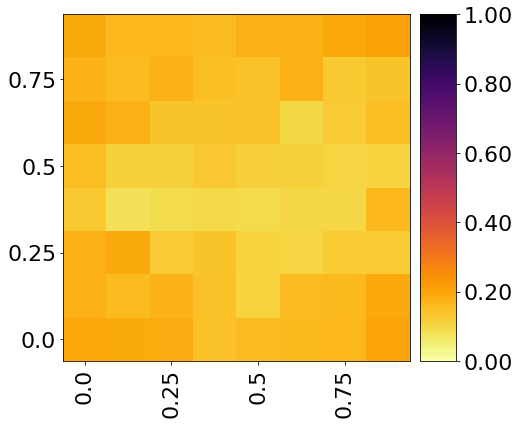

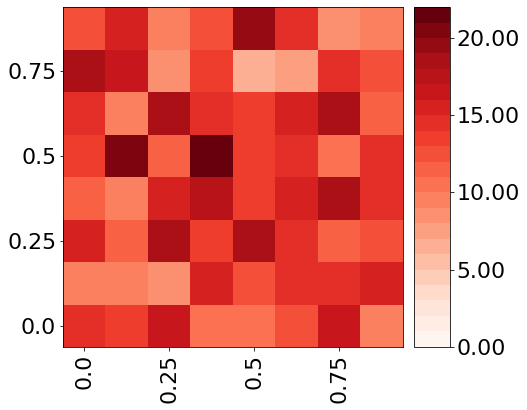

In [64]:
# TODO: change these parameters
NO_BINS=8          # default 32
MAX_ITEMS_BIN=1     # default 1
BUDGET=10000        # default 10000
BATCH_SIZE=500      # default 500
PROBLEM_DIM= 10      # default 3

"""
-------------------------------------------------------------------------
"""
main(NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [65]:
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex1\810\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES: ",grid.best.features)

GRID BEST:  Individual([0.19981342123829615, 0.4974262218908616, 0.3138749194909609, 0.40234943490266595, 0.4951960037261234, 0.5110436420525567, 0.3094032509630835, 0.5088154690964914, 0.6959839269263481, 0.3178127832612031])
GRID BEST FITNESS:  (0.07919566187166009,)
GRID BEST FEATURES:  [0.19981342123829615, 0.4974262218908616]


### NO_BINS = 16

Seed: 741094



  1%|▍                                                               | 61/10000 [00:00<01:54, 86.71eval/s, iteration=0]


  1%|▊                                                             | 124/10000 [00:01<01:28, 111.29eval/s, iteration=0]


  2%|█▏                                                             | 186/10000 [00:02<01:40, 97.61eval/s, iteration=0]


  2%|█▌                                                            | 249/10000 [00:02<01:25, 114.59eval/s, iteration=0]


  3%|█▉                                                            | 312/10000 [00:03<01:21, 119.21eval/s, iteration=0]


  4%|██▎                                                           | 375/10000 [00:03<01:18, 122.02eval/s, iteration=0]


  4%|██▋                                                           | 439/10000 [00:04<01:07, 142.12eval/s, iteration=0]


  5%|███                                                           | 498/10000 [00:04<01:03, 149.72eval/s, iteration=0]
                                                                                                                       


alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed


 62%|█████████████████████████████████████▎                      | 6229/10000 [11:20<00:14, 252.18eval/s, iteration=12]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     0         231/256   500       337            [0.3417]  [0.1083]  [0.0954]  [0.6474]  [0.0031,0.0025]     [0.9912,0.9949]     152.07    4.48   


  6%|███▍                                                          | 561/10000 [00:05<01:24, 112.21eval/s, iteration=1]


  6%|███▉                                                          | 625/10000 [00:05<01:14, 125.53eval/s, iteration=1]


  7%|████▎                                                         | 688/10000 [00:06<01:11, 130.63eval/s, iteration=1]


  8%|████▋                                                         | 752/10000 [00:06<01:07, 137.72eval/s, iteration=1]


  8%|█████                                                         | 816/10000 [00:07<01:07, 136.46eval/s, iteration=1]


  9%|█████▍                                                        | 879/10000 [00:07<01:08, 133.99eval/s, iteration=1]


  9%|█████▊                                                        | 943/10000 [00:08<01:03, 142.81eval/s, iteration=1]


 10%|██████▏                                                       | 998/10000 [00:08<01:11, 126.56eval/s, iteration=1]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     1         250/256   500       133            [0.313]   [0.1067]  [0.0954]  [0.6474]  [0.0007,0.0025]     [0.9912,0.9988]     171.74    3.96   


 11%|██████▍                                                      | 1061/10000 [00:09<01:24, 105.64eval/s, iteration=2]


 11%|██████▊                                                      | 1125/10000 [00:09<01:11, 123.94eval/s, iteration=2]


 12%|███████▏                                                     | 1188/10000 [00:10<01:09, 126.73eval/s, iteration=2]


 13%|███████▋                                                     | 1251/10000 [00:10<01:12, 121.42eval/s, iteration=2]


 13%|████████                                                     | 1315/10000 [00:11<01:07, 128.44eval/s, iteration=2]


 14%|████████▍                                                    | 1378/10000 [00:11<01:04, 133.77eval/s, iteration=2]


 14%|████████▊                                                    | 1442/10000 [00:12<01:07, 127.57eval/s, iteration=2]


 15%|█████████▏                                                   | 1499/10000 [00:12<01:07, 125.18eval/s, iteration=2]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     2         254/256   500       116            [0.288]   [0.1028]  [0.0191]  [0.6137]  [0.0007,0.0025]     [0.9993,0.9988]     180.85    4.10   


 16%|█████████▌                                                   | 1561/10000 [00:13<01:11, 118.47eval/s, iteration=3]


 16%|█████████▉                                                   | 1626/10000 [00:13<00:54, 155.01eval/s, iteration=3]


 17%|██████████▎                                                  | 1690/10000 [00:14<00:53, 156.21eval/s, iteration=3]


 18%|██████████▋                                                  | 1754/10000 [00:14<01:00, 135.95eval/s, iteration=3]


 18%|███████████                                                  | 1818/10000 [00:15<01:04, 126.63eval/s, iteration=3]


 19%|███████████▍                                                 | 1881/10000 [00:15<00:56, 144.03eval/s, iteration=3]


 19%|███████████▊                                                 | 1945/10000 [00:15<00:53, 150.49eval/s, iteration=3]


 20%|████████████▏                                                | 1998/10000 [00:16<00:53, 150.00eval/s, iteration=3]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     3         256/256   500       72             [0.2738]  [0.1017]  [0.0081]  [0.5848]  [0.0007,0.0025]     [0.9993,0.9953]     185.90    3.57   


 21%|████████████▌                                                | 2061/10000 [00:16<01:10, 113.07eval/s, iteration=4]


 21%|████████████▉                                                | 2124/10000 [00:17<01:09, 113.99eval/s, iteration=4]


 22%|█████████████▎                                               | 2188/10000 [00:17<00:56, 137.84eval/s, iteration=4]


 23%|█████████████▋                                               | 2251/10000 [00:18<00:54, 143.10eval/s, iteration=4]


 23%|██████████████                                               | 2315/10000 [00:18<00:59, 129.24eval/s, iteration=4]


 24%|██████████████▌                                              | 2379/10000 [00:19<00:52, 145.57eval/s, iteration=4]


 24%|██████████████▉                                              | 2443/10000 [00:19<00:58, 128.60eval/s, iteration=4]


 25%|███████████████▏                                             | 2498/10000 [00:20<00:57, 130.75eval/s, iteration=4]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     4         256/256   500       61             [0.2624]  [0.1029]  [0.0081]  [0.5848]  [0.0007,0.0094]     [0.9993,0.9953]     188.83    3.93   


 26%|███████████████▌                                             | 2560/10000 [00:20<01:09, 106.90eval/s, iteration=5]


 26%|████████████████                                             | 2624/10000 [00:21<00:57, 128.47eval/s, iteration=5]


 27%|████████████████▍                                            | 2688/10000 [00:21<00:50, 144.40eval/s, iteration=5]


 28%|████████████████▊                                            | 2751/10000 [00:22<00:54, 133.03eval/s, iteration=5]


 28%|█████████████████▏                                           | 2815/10000 [00:22<01:00, 119.46eval/s, iteration=5]


 29%|█████████████████▌                                           | 2879/10000 [00:23<00:49, 142.45eval/s, iteration=5]


 29%|█████████████████▉                                           | 2943/10000 [00:23<00:47, 148.63eval/s, iteration=5]


 30%|██████████████████▎                                          | 2998/10000 [00:24<00:54, 128.15eval/s, iteration=5]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     5         256/256   500       59             [0.2511]  [0.0993]  [0.0081]  [0.5678]  [0.0007,0.0060]     [0.9993,0.9953]     191.72    3.94   


 31%|██████████████████▋                                          | 3060/10000 [00:24<00:59, 116.82eval/s, iteration=6]


 31%|███████████████████                                          | 3123/10000 [00:25<00:57, 118.89eval/s, iteration=6]


 32%|███████████████████▍                                         | 3187/10000 [00:25<00:51, 132.72eval/s, iteration=6]


 33%|███████████████████▊                                         | 3251/10000 [00:26<00:53, 126.87eval/s, iteration=6]


 33%|████████████████████▏                                        | 3314/10000 [00:26<00:56, 118.75eval/s, iteration=6]


 34%|████████████████████▌                                        | 3378/10000 [00:27<00:45, 144.50eval/s, iteration=6]


 34%|████████████████████▉                                        | 3442/10000 [00:27<00:46, 139.82eval/s, iteration=6]


 35%|█████████████████████▎                                       | 3498/10000 [00:28<00:43, 149.11eval/s, iteration=6]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     6         256/256   500       51             [0.2422]  [0.0955]  [0.0081]  [0.5104]  [0.0007,0.0060]     [0.9993,0.9949]     193.99    3.99   


 36%|█████████████████████▋                                       | 3561/10000 [00:28<00:52, 122.69eval/s, iteration=7]


 36%|██████████████████████                                       | 3625/10000 [00:29<00:48, 132.11eval/s, iteration=7]


 37%|██████████████████████▍                                      | 3688/10000 [00:29<00:53, 117.22eval/s, iteration=7]


 38%|██████████████████████▉                                      | 3751/10000 [00:30<00:50, 124.19eval/s, iteration=7]


 38%|███████████████████████▎                                     | 3816/10000 [00:30<00:40, 150.97eval/s, iteration=7]


 39%|███████████████████████▋                                     | 3880/10000 [00:31<00:40, 150.75eval/s, iteration=7]


 39%|████████████████████████                                     | 3943/10000 [00:31<00:47, 128.64eval/s, iteration=7]


 40%|████████████████████████▍                                    | 3999/10000 [00:32<00:41, 144.41eval/s, iteration=7]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     7         256/256   500       52             [0.2344]  [0.0927]  [0.0081]  [0.4943]  [0.0007,0.0060]     [0.9993,0.9949]     196.00    3.88   


 41%|████████████████████████▊                                    | 4061/10000 [00:32<00:51, 115.85eval/s, iteration=8]


 41%|█████████████████████████▏                                   | 4125/10000 [00:33<00:43, 134.26eval/s, iteration=8]


 42%|█████████████████████████▌                                   | 4189/10000 [00:33<00:43, 133.31eval/s, iteration=8]


 43%|█████████████████████████▉                                   | 4253/10000 [00:34<00:43, 133.39eval/s, iteration=8]


 43%|██████████████████████████▎                                  | 4316/10000 [00:34<00:44, 128.84eval/s, iteration=8]


 44%|██████████████████████████▋                                  | 4380/10000 [00:35<00:42, 130.72eval/s, iteration=8]


 44%|███████████████████████████                                  | 4444/10000 [00:35<00:40, 135.80eval/s, iteration=8]


 45%|███████████████████████████▍                                 | 4498/10000 [00:36<00:38, 142.42eval/s, iteration=8]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     8         256/256   500       43             [0.2272]  [0.0926]  [0.0081]  [0.4943]  [0.0007,0.0060]     [0.9993,0.9949]     197.84    3.96   


 46%|███████████████████████████▊                                 | 4560/10000 [00:36<00:48, 112.57eval/s, iteration=9]


 46%|████████████████████████████▏                                | 4624/10000 [00:37<00:40, 133.17eval/s, iteration=9]


 47%|████████████████████████████▌                                | 4688/10000 [00:37<00:42, 125.57eval/s, iteration=9]


 48%|████████████████████████████▉                                | 4752/10000 [00:38<00:35, 148.88eval/s, iteration=9]


 48%|█████████████████████████████▍                               | 4816/10000 [00:38<00:38, 135.97eval/s, iteration=9]


 49%|█████████████████████████████▊                               | 4879/10000 [00:39<00:37, 137.53eval/s, iteration=9]


 49%|██████████████████████████████▏                              | 4943/10000 [00:39<00:42, 119.17eval/s, iteration=9]


 50%|██████████████████████████████▍                              | 4998/10000 [00:40<00:39, 127.72eval/s, iteration=9]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     9         256/256   500       31             [0.224]   [0.0923]  [0.0081]  [0.4943]  [0.0007,0.0060]     [0.9993,0.9949]     198.65    3.96   


 51%|██████████████████████████████▎                             | 5060/10000 [00:40<00:45, 108.77eval/s, iteration=10]


 51%|██████████████████████████████▋                             | 5124/10000 [00:41<00:39, 122.07eval/s, iteration=10]


 52%|███████████████████████████████                             | 5187/10000 [00:41<00:38, 123.91eval/s, iteration=10]


 52%|███████████████████████████████▌                            | 5250/10000 [00:42<00:40, 115.86eval/s, iteration=10]


 53%|███████████████████████████████▉                            | 5314/10000 [00:42<00:35, 132.66eval/s, iteration=10]


 54%|████████████████████████████████▎                           | 5378/10000 [00:43<00:31, 146.41eval/s, iteration=10]


 54%|████████████████████████████████▋                           | 5441/10000 [00:43<00:34, 133.99eval/s, iteration=10]


 55%|████████████████████████████████▉                           | 5498/10000 [00:44<00:33, 134.51eval/s, iteration=10]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     10        256/256   500       42             [0.2195]  [0.0916]  [0.0081]  [0.4943]  [0.0007,0.0060]     [0.9993,0.9949]     199.81    4.11   


 56%|█████████████████████████████████▎                          | 5561/10000 [00:44<00:42, 105.15eval/s, iteration=11]


 56%|█████████████████████████████████▋                          | 5624/10000 [00:45<00:35, 123.89eval/s, iteration=11]


 57%|██████████████████████████████████▏                         | 5688/10000 [00:45<00:33, 126.97eval/s, iteration=11]


 58%|██████████████████████████████████▌                         | 5751/10000 [00:46<00:32, 131.63eval/s, iteration=11]


 58%|██████████████████████████████████▉                         | 5814/10000 [00:46<00:34, 122.26eval/s, iteration=11]


 59%|███████████████████████████████████▎                        | 5878/10000 [00:47<00:33, 122.66eval/s, iteration=11]


 59%|███████████████████████████████████▋                        | 5941/10000 [00:47<00:30, 134.97eval/s, iteration=11]


 60%|███████████████████████████████████▉                        | 5998/10000 [00:48<00:29, 133.43eval/s, iteration=11]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     11        256/256   500       36             [0.2161]  [0.0916]  [0.0081]  [0.4637]  [0.0007,0.0060]     [0.9993,0.9949]     200.67    4.14   


 61%|████████████████████████████████████▉                        | 6061/10000 [00:49<00:39, 99.02eval/s, iteration=12]


 61%|████████████████████████████████████▋                       | 6124/10000 [00:49<00:30, 127.93eval/s, iteration=12]


 62%|█████████████████████████████████████▏                      | 6188/10000 [00:50<00:28, 133.76eval/s, iteration=12]


 63%|█████████████████████████████████████▌                      | 6251/10000 [00:50<00:29, 127.67eval/s, iteration=12]


 63%|█████████████████████████████████████▉                      | 6315/10000 [00:51<00:26, 137.87eval/s, iteration=12]


 64%|██████████████████████████████████████▎                     | 6378/10000 [00:51<00:26, 136.29eval/s, iteration=12]


 64%|██████████████████████████████████████▋                     | 6442/10000 [00:52<00:28, 125.97eval/s, iteration=12]


 65%|██████████████████████████████████████▉                     | 6498/10000 [00:52<00:26, 130.81eval/s, iteration=12]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     12        256/256   500       28             [0.2124]  [0.0909]  [0.0081]  [0.455]   [0.0031,0.0060]     [0.9993,0.9952]     201.63    4.10   


 66%|███████████████████████████████████████▎                    | 6560/10000 [00:53<00:32, 105.55eval/s, iteration=13]


 66%|███████████████████████████████████████▋                    | 6624/10000 [00:53<00:26, 127.63eval/s, iteration=13]


 67%|████████████████████████████████████████                    | 6687/10000 [00:54<00:24, 134.13eval/s, iteration=13]


 68%|████████████████████████████████████████▌                   | 6751/10000 [00:54<00:23, 139.02eval/s, iteration=13]


 68%|████████████████████████████████████████▉                   | 6815/10000 [00:55<00:21, 146.57eval/s, iteration=13]


 69%|█████████████████████████████████████████▎                  | 6879/10000 [00:55<00:22, 140.33eval/s, iteration=13]


 69%|█████████████████████████████████████████▋                  | 6942/10000 [00:56<00:23, 129.23eval/s, iteration=13]


 70%|█████████████████████████████████████████▉                  | 6998/10000 [00:56<00:20, 143.55eval/s, iteration=13]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     13        256/256   500       48             [0.2062]  [0.0914]  [0.0081]  [0.4284]  [0.0054,0.0060]     [0.9993,0.9952]     203.23    3.93   


 71%|██████████████████████████████████████████▎                 | 7061/10000 [00:57<00:26, 111.37eval/s, iteration=14]


 71%|██████████████████████████████████████████▋                 | 7124/10000 [00:57<00:24, 119.15eval/s, iteration=14]


 72%|███████████████████████████████████████████                 | 7187/10000 [00:58<00:22, 127.07eval/s, iteration=14]


 73%|███████████████████████████████████████████▌                | 7251/10000 [00:58<00:19, 143.04eval/s, iteration=14]


 73%|███████████████████████████████████████████▉                | 7315/10000 [00:59<00:18, 148.64eval/s, iteration=14]


 74%|████████████████████████████████████████████▎               | 7379/10000 [00:59<00:19, 134.71eval/s, iteration=14]


 74%|████████████████████████████████████████████▋               | 7442/10000 [01:00<00:19, 128.86eval/s, iteration=14]


 75%|████████████████████████████████████████████▉               | 7498/10000 [01:00<00:19, 131.43eval/s, iteration=14]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     14        256/256   500       34             [0.2029]  [0.091]   [0.0081]  [0.4284]  [0.0054,0.0060]     [0.9993,0.9952]     204.05    3.98   


 76%|█████████████████████████████████████████████▎              | 7561/10000 [01:01<00:21, 115.35eval/s, iteration=15]


 76%|█████████████████████████████████████████████▊              | 7625/10000 [01:01<00:18, 131.37eval/s, iteration=15]


 77%|██████████████████████████████████████████████▏             | 7689/10000 [01:02<00:17, 132.35eval/s, iteration=15]


 78%|██████████████████████████████████████████████▌             | 7752/10000 [01:02<00:16, 136.84eval/s, iteration=15]


 78%|██████████████████████████████████████████████▉             | 7816/10000 [01:03<00:14, 155.40eval/s, iteration=15]


 79%|███████████████████████████████████████████████▎            | 7880/10000 [01:03<00:14, 142.83eval/s, iteration=15]


 79%|███████████████████████████████████████████████▋            | 7944/10000 [01:03<00:15, 132.02eval/s, iteration=15]


 80%|███████████████████████████████████████████████▉            | 7998/10000 [01:04<00:15, 133.30eval/s, iteration=15]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     15        256/256   500       33             [0.1991]  [0.091]   [0.0081]  [0.4284]  [0.0054,0.0060]     [0.9993,0.9952]     205.03    3.82   


 81%|████████████████████████████████████████████████▎           | 8061/10000 [01:05<00:18, 106.11eval/s, iteration=16]


 81%|████████████████████████████████████████████████▋           | 8124/10000 [01:05<00:15, 121.60eval/s, iteration=16]


 82%|█████████████████████████████████████████████████▏          | 8188/10000 [01:06<00:13, 133.67eval/s, iteration=16]


 83%|█████████████████████████████████████████████████▌          | 8251/10000 [01:06<00:12, 137.98eval/s, iteration=16]


 83%|█████████████████████████████████████████████████▉          | 8315/10000 [01:07<00:12, 131.37eval/s, iteration=16]


 84%|██████████████████████████████████████████████████▎         | 8378/10000 [01:07<00:13, 124.47eval/s, iteration=16]


 84%|██████████████████████████████████████████████████▋         | 8442/10000 [01:07<00:10, 145.17eval/s, iteration=16]


 85%|██████████████████████████████████████████████████▉         | 8498/10000 [01:08<00:11, 130.17eval/s, iteration=16]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     16        256/256   500       17             [0.1981]  [0.0911]  [0.0081]  [0.4284]  [0.0063,0.0060]     [0.9993,0.9952]     205.29    4.01   


 86%|███████████████████████████████████████████████████▎        | 8561/10000 [01:09<00:12, 112.26eval/s, iteration=17]


 86%|███████████████████████████████████████████████████▊        | 8625/10000 [01:09<00:11, 120.24eval/s, iteration=17]


 87%|████████████████████████████████████████████████████▏       | 8688/10000 [01:10<00:09, 132.17eval/s, iteration=17]


 88%|████████████████████████████████████████████████████▌       | 8752/10000 [01:10<00:09, 130.17eval/s, iteration=17]


 88%|████████████████████████████████████████████████████▉       | 8816/10000 [01:11<00:09, 130.29eval/s, iteration=17]


 89%|█████████████████████████████████████████████████████▎      | 8879/10000 [01:11<00:08, 131.62eval/s, iteration=17]


 89%|█████████████████████████████████████████████████████▋      | 8943/10000 [01:12<00:08, 127.95eval/s, iteration=17]


 90%|█████████████████████████████████████████████████████▉      | 8998/10000 [01:12<00:07, 135.20eval/s, iteration=17]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     17        256/256   500       30             [0.1951]  [0.0898]  [0.0081]  [0.4284]  [0.0047,0.0060]     [0.9993,0.9949]     206.06    3.98   


 91%|██████████████████████████████████████████████████████▎     | 9061/10000 [01:13<00:08, 115.38eval/s, iteration=18]


 91%|██████████████████████████████████████████████████████▋     | 9124/10000 [01:13<00:06, 125.41eval/s, iteration=18]


 92%|███████████████████████████████████████████████████████▏    | 9188/10000 [01:14<00:06, 130.09eval/s, iteration=18]


 93%|███████████████████████████████████████████████████████▌    | 9251/10000 [01:14<00:05, 129.88eval/s, iteration=18]


 93%|███████████████████████████████████████████████████████▉    | 9315/10000 [01:14<00:04, 143.55eval/s, iteration=18]


 94%|████████████████████████████████████████████████████████▎   | 9379/10000 [01:15<00:04, 138.33eval/s, iteration=18]


 94%|████████████████████████████████████████████████████████▋   | 9443/10000 [01:15<00:04, 135.78eval/s, iteration=18]


 95%|████████████████████████████████████████████████████████▉   | 9498/10000 [01:16<00:04, 125.47eval/s, iteration=18]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     18        256/256   500       32             [0.1925]  [0.0901]  [0.0081]  [0.4284]  [0.0047,0.0074]     [0.9993,0.9995]     206.72    3.91   


 96%|█████████████████████████████████████████████████████████▎  | 9561/10000 [01:17<00:03, 117.88eval/s, iteration=19]


 96%|█████████████████████████████████████████████████████████▋  | 9624/10000 [01:17<00:03, 115.51eval/s, iteration=19]


 97%|██████████████████████████████████████████████████████████▏ | 9688/10000 [01:18<00:02, 134.70eval/s, iteration=19]


 98%|██████████████████████████████████████████████████████████▌ | 9752/10000 [01:18<00:01, 141.14eval/s, iteration=19]


 98%|██████████████████████████████████████████████████████████▉ | 9816/10000 [01:18<00:01, 148.02eval/s, iteration=19]


 99%|███████████████████████████████████████████████████████████▎| 9880/10000 [01:19<00:00, 150.89eval/s, iteration=19]


 99%|███████████████████████████████████████████████████████████▋| 9944/10000 [01:19<00:00, 131.23eval/s, iteration=19]


100%|███████████████████████████████████████████████████████████▉| 9998/10000 [01:20<00:00, 139.42eval/s, iteration=19]
                                                                                                                       


RandomSearchMutPolyBounded-2011055659424     19        256/256   500       29             [0.1899]  [0.0899]  [0.0081]  [0.4152]  [0.0034,0.0074]     [0.9993,0.9995]     207.39    3.83   


 62%|█████████████████████████████████████▎                      | 6229/10000 [12:36<00:14, 252.18eval/s, iteration=12]
                                                                                                                       


Finished optimisation using algorithm 'RandomSearchMutPolyBounded-2011055659424'. Total elapsed: 80.30364579999969.


100%|███████████████████████████████████████████████████████████| 10000/10000 [01:20<00:00, 139.42eval/s, iteration=19]
                                                                                                                       


Summary RandomSearchMutPolyBounded:
  batch_size: 500
  budget: 10000
  container:  Summary Grid:
    activity_per_bin: [[ 7.  3.  5.  7.  6.  7.  4.  6.  4.  4.  9.  6.  4.  4.  7.  1.]  [ 4.  3.  4.  7.  8.  6.  6.  7.  7.  6.  5.  7.  5.  4.  4.  5.]  [ 6.  5.  2.  6.  3.  2.  5.  2.  3.  5.  7.  4.  6.  6.  4.  6.]  [ 5.  6.  4.  4.  4.  6.  5.  7.  5.  5.  3 ...
    best: Individual([0.5049432250478348, 0.5000547948533234, 0.5054522279629222])
    best_features: [0.5049432250478348, 0.5000547948533234]
    best_fitness: (0.008051334687966198,)
    best_index: (8, 8)
    capacity: 256
    depot: None
    discard_random_on_bin_overload: False
    features: {(0, 0): [Features([0.008464335854443616, 0.007427793351857059])], (0, 1): [Features([0.007353939559004097, 0.10345262508117326])], (0, 2): [Features([0.011224416623322964, 0.1852374012371606])], (0, 3): [Features([0.021460153905939028, 0.211168 ...
    features_domain: ((0.0, 1.0), (0.0, 1.0))
    features_extrema: ((0.003391773

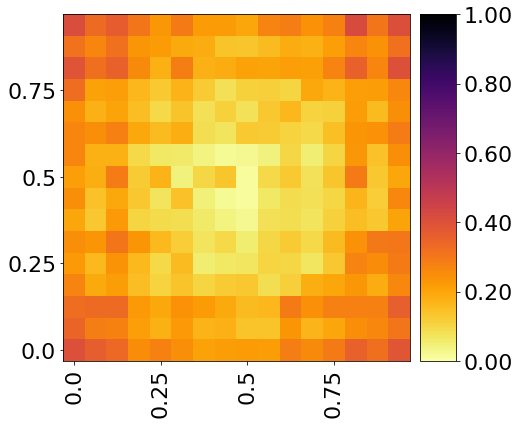

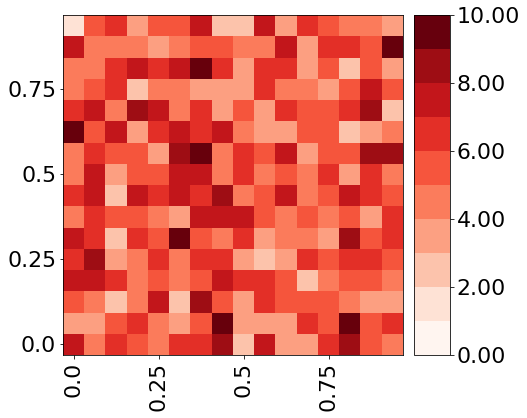

In [50]:
# TODO: change these parameters
NO_BINS=16          # default 32
MAX_ITEMS_BIN=1     # default 1
BUDGET=10000        # default 10000
BATCH_SIZE=500      # default 500
PROBLEM_DIM=3       # default 3

"""
-------------------------------------------------------------------------
"""
main(NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [51]:
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex1\16 BIN\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES: ",grid.best.features)

GRID BEST:  Individual([0.5049432250478348, 0.5000547948533234, 0.5054522279629222])
GRID BEST FITNESS:  (0.008051334687966198,)
GRID BEST FEATURES:  [0.5049432250478348, 0.5000547948533234]


### NO_BINS = 16, 10D

Seed: 208406


alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed


RandomSearchMutPolyBounded-2011057783808     0         218/256   500       324            [0.3605]  [0.0669]  [0.1968]  [0.53]    [0.0027,0.0006]     [0.9940,0.9904]     139.41    1.12   


RandomSearchMutPolyBounded-2011057783808     1         240/256   500       169            [0.3353]  [0.0586]  [0.1914]  [0.5214]  [0.0027,0.0038]     [0.9954,0.9904]     159.54    1.38   


RandomSearchMutPolyBounded-2011057783808     2         253/256   500       125            [0.3219]  [0.057]   [0.1914]  [0.5038]  [0.0027,0.0050]     [0.9954,0.9904]     171.57    1.13   


RandomSearchMutPolyBounded-2011057783808     3         256/256   500       120            [0.3099]  [0.0545]  [0.1663]  [0.5038]  [0.0057,0.0050]     [0.9954,0.9955]     176.66    1.20   


RandomSearchMutPolyBounded-2011057783808     4         256/256   500       89             [0.3]     [0.0513]  [0.1612]  [0.5038]  [0.0057,0.0050]     [0.9981,0.9994]     179.20    1.10   


RandomSearchMutPolyBounded-2011057783808     5         256/256   500       91             [0.2913]  [0.0507]  [0.1612]  [0.5038]  [0.0057,0.0050]     [0.9981,0.9994]     181.43    1.04   


RandomSearchMutPolyBounded-2011057783808     6         256/256   500       72             [0.2841]  [0.0514]  [0.1535]  [0.5038]  [0.0007,0.0050]     [0.9981,0.9994]     183.26    0.90   


RandomSearchMutPolyBounded-2011057783808     7         256/256   500       82             [0.277]   [0.0511]  [0.1178]  [0.4826]  [0.0007,0.0050]     [0.9981,0.9994]     185.08    0.96   


RandomSearchMutPolyBounded-2011057783808     8         256/256   500       68             [0.2716]  [0.0506]  [0.1178]  [0.4535]  [0.0007,0.0050]     [0.9981,0.9994]     186.48    0.87   


RandomSearchMutPolyBounded-2011057783808     9         256/256   500       93             [0.2641]  [0.049]   [0.1178]  [0.3816]  [0.0007,0.0050]     [0.9981,0.9994]     188.39    0.90   


RandomSearchMutPolyBounded-2011057783808     10        256/256   500       76             [0.2563]  [0.0485]  [0.1178]  [0.3729]  [0.0007,0.0050]     [0.9981,0.9994]     190.38    0.89   


RandomSearchMutPolyBounded-2011057783808     11        256/256   500       57             [0.2517]  [0.0483]  [0.1178]  [0.3729]  [0.0055,0.0050]     [0.9981,0.9994]     191.56    1.10   


RandomSearchMutPolyBounded-2011057783808     12        256/256   500       65             [0.2464]  [0.048]   [0.1178]  [0.3575]  [0.0055,0.0050]     [0.9981,0.9994]     192.91    0.90   


RandomSearchMutPolyBounded-2011057783808     13        256/256   500       76             [0.2406]  [0.0478]  [0.1178]  [0.3561]  [0.0055,0.0050]     [0.9981,0.9994]     194.41    0.92   


RandomSearchMutPolyBounded-2011057783808     14        256/256   500       53             [0.2356]  [0.0481]  [0.1178]  [0.3561]  [0.0055,0.0050]     [0.9981,0.9994]     195.67    1.05   


RandomSearchMutPolyBounded-2011057783808     15        256/256   500       50             [0.2323]  [0.0476]  [0.1178]  [0.3511]  [0.0057,0.0050]     [0.9981,0.9994]     196.53    0.97   


RandomSearchMutPolyBounded-2011057783808     16        256/256   500       54             [0.2283]  [0.0477]  [0.1178]  [0.3511]  [0.0057,0.0050]     [0.9981,0.9994]     197.55    1.15   


RandomSearchMutPolyBounded-2011057783808     17        256/256   500       61             [0.2237]  [0.0478]  [0.1178]  [0.3511]  [0.0057,0.0050]     [0.9981,0.9938]     198.73    1.10   


RandomSearchMutPolyBounded-2011057783808     18        256/256   500       45             [0.2207]  [0.0479]  [0.097]   [0.3511]  [0.0057,0.0050]     [0.9981,0.9938]     199.49    0.95   


RandomSearchMutPolyBounded-2011057783808     19        256/256   500       54             [0.2161]  [0.0475]  [0.097]   [0.3511]  [0.0012,0.0050]     [0.9981,0.9953]     200.67    1.09   


Finished optimisation using algorithm 'RandomSearchMutPolyBounded-2011057783808'. Total elapsed: 20.934191100001044.



Summary RandomSearchMutPolyBounded:
  batch_size: 500
  budget: 10000
  container:  Summary Grid:
    activity_per_bin: [[ 3.  8.  9.  5.  5.  7.  7.  9.  8.  4.  6.  5.  9. 11.  9.  8.]  [ 7.  6. 10. 10.  6. 12.  6.  4.  9.  7.  9.  6.  6.  7.  9.  8.]  [ 4.  7.  7.  6.  6.  6.  7. 12.  6.  4.  8.  6.  8.  8.  5.  9.]  [ 5.  7.  6.  7.  7.  6.  5.  4. 10.  8.  5 ...
    best: Individual([0.514765891391446, 0.5018137323795284, 0.1940075340281615, 0.49507356221798826, 0.30745033141517986, 0.5855562298180625, 0.20753168558970647, 0.4063864898366819, 0.5913285506986449, 0.3188574574738545])
    best_features: [0.514765891391446, 0.5018137323795284]
    best_fitness: (0.0970149244677937,)
    best_index: (8, 8)
    capacity: 256
    depot: None
    discard_random_on_bin_overload: False
    features: {(0, 0): [Features([0.009403211150899593, 0.006931198817251238])], (0, 1): [Features([0.023250619965565766, 0.1227999103548808])], (0, 2): [Features([0.009656288574890204, 0.17774351355339835]

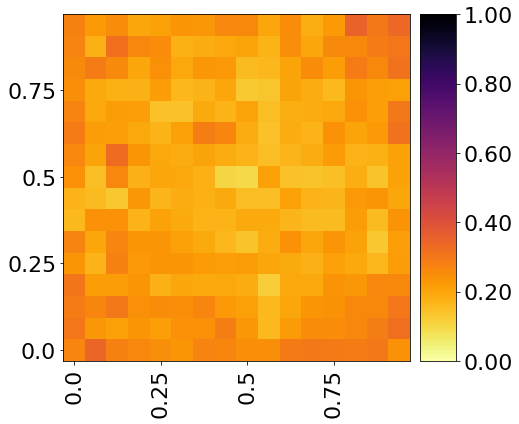

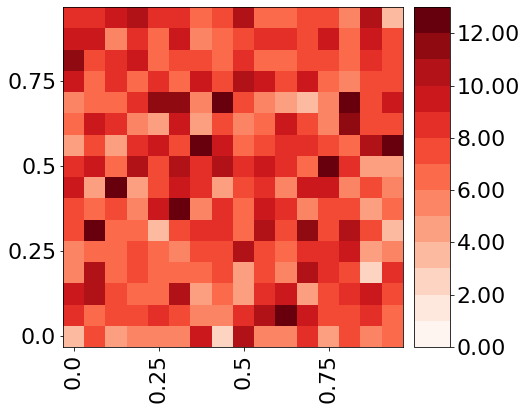

In [66]:
# TODO: change these parameters
NO_BINS=16          # default 32
MAX_ITEMS_BIN=1     # default 1
BUDGET=10000        # default 10000
BATCH_SIZE=500      # default 500
PROBLEM_DIM=10       # default 3

"""
-------------------------------------------------------------------------
"""
main(NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [67]:
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex1\1610\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES: ",grid.best.features)

GRID BEST:  Individual([0.514765891391446, 0.5018137323795284, 0.1940075340281615, 0.49507356221798826, 0.30745033141517986, 0.5855562298180625, 0.20753168558970647, 0.4063864898366819, 0.5913285506986449, 0.3188574574738545])
GRID BEST FITNESS:  (0.0970149244677937,)
GRID BEST FEATURES:  [0.514765891391446, 0.5018137323795284]


### NO_BINS = 32

Seed: 828000



  1%|▍                                                              | 60/10000 [00:00<01:36, 103.54eval/s, iteration=0]


  1%|▊                                                             | 123/10000 [00:01<01:29, 110.29eval/s, iteration=0]


  2%|█▏                                                            | 186/10000 [00:01<01:25, 114.99eval/s, iteration=0]


  2%|█▌                                                            | 249/10000 [00:02<01:29, 109.17eval/s, iteration=0]


  3%|█▉                                                            | 311/10000 [00:02<01:31, 105.85eval/s, iteration=0]


  4%|██▎                                                           | 374/10000 [00:03<01:28, 108.71eval/s, iteration=0]


  4%|██▋                                                           | 437/10000 [00:04<01:22, 115.75eval/s, iteration=0]


  5%|███                                                           | 498/10000 [00:04<01:11, 132.33eval/s, iteration=0]
                                                                                                                       


alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed


 62%|█████████████████████████████████████▎                      | 6229/10000 [18:31<00:14, 252.18eval/s, iteration=12]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     0         396/1024  500       448            [0.3932]  [0.1264]  [0.0798]  [0.7008]  [0.0013,0.0032]     [0.9992,0.9967]     240.29    4.54   


  6%|███▍                                                          | 561/10000 [00:05<01:25, 110.67eval/s, iteration=1]


  6%|███▉                                                          | 625/10000 [00:05<01:10, 132.34eval/s, iteration=1]


  7%|████▎                                                         | 689/10000 [00:06<01:04, 143.78eval/s, iteration=1]


  8%|████▋                                                         | 753/10000 [00:06<01:02, 149.05eval/s, iteration=1]


  8%|█████                                                         | 817/10000 [00:07<01:03, 145.75eval/s, iteration=1]


  9%|█████▍                                                        | 880/10000 [00:07<01:07, 134.42eval/s, iteration=1]


  9%|█████▊                                                        | 943/10000 [00:08<01:18, 114.97eval/s, iteration=1]


 10%|██████▏                                                       | 998/10000 [00:08<01:19, 113.76eval/s, iteration=1]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     1         576/1024  500       261            [0.3831]  [0.1266]  [0.053]   [0.7644]  [0.0013,0.0032]     [0.9992,0.9967]     355.31    3.94   


 11%|██████▍                                                      | 1060/10000 [00:09<01:18, 114.27eval/s, iteration=2]


 11%|██████▊                                                      | 1124/10000 [00:09<01:15, 117.57eval/s, iteration=2]


 12%|███████▏                                                     | 1187/10000 [00:10<01:08, 129.43eval/s, iteration=2]


 13%|███████▋                                                     | 1251/10000 [00:10<01:13, 118.33eval/s, iteration=2]


 13%|████████                                                     | 1314/10000 [00:11<01:04, 135.02eval/s, iteration=2]


 14%|████████▍                                                    | 1378/10000 [00:11<01:04, 132.76eval/s, iteration=2]


 14%|████████▊                                                    | 1441/10000 [00:12<01:05, 130.85eval/s, iteration=2]


 15%|█████████▏                                                   | 1498/10000 [00:12<01:04, 132.09eval/s, iteration=2]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     2         699/1024  500       240            [0.3746]  [0.1235]  [0.053]   [0.7644]  [0.0013,0.0079]     [0.9992,0.9967]     437.14    4.04   


 16%|█████████▌                                                   | 1561/10000 [00:13<01:18, 107.80eval/s, iteration=3]


 16%|█████████▉                                                   | 1625/10000 [00:13<01:02, 133.90eval/s, iteration=3]


 17%|██████████▎                                                  | 1688/10000 [00:14<01:01, 134.61eval/s, iteration=3]


 18%|██████████▋                                                  | 1752/10000 [00:14<01:01, 134.52eval/s, iteration=3]


 18%|███████████                                                  | 1815/10000 [00:15<01:07, 121.06eval/s, iteration=3]


 19%|███████████▍                                                 | 1878/10000 [00:15<01:00, 133.52eval/s, iteration=3]


 19%|███████████▊                                                 | 1942/10000 [00:16<01:01, 130.76eval/s, iteration=3]


 20%|████████████▏                                                | 1999/10000 [00:16<01:02, 127.54eval/s, iteration=3]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     3         793/1024  500       221            [0.3681]  [0.1246]  [0.053]   [0.7644]  [0.0001,0.0026]     [0.9992,0.9968]     501.10    4.01   


 21%|████████████▌                                                | 2061/10000 [00:17<01:13, 108.50eval/s, iteration=4]


 21%|████████████▉                                                | 2125/10000 [00:17<01:02, 126.09eval/s, iteration=4]


 22%|█████████████▎                                               | 2188/10000 [00:18<01:00, 128.30eval/s, iteration=4]


 23%|█████████████▋                                               | 2252/10000 [00:18<01:02, 124.66eval/s, iteration=4]


 23%|██████████████                                               | 2315/10000 [00:19<01:00, 127.43eval/s, iteration=4]


 24%|██████████████▌                                              | 2378/10000 [00:19<01:07, 112.47eval/s, iteration=4]


 24%|██████████████▉                                              | 2441/10000 [00:20<00:57, 130.85eval/s, iteration=4]


 25%|███████████████▏                                             | 2498/10000 [00:20<00:56, 132.98eval/s, iteration=4]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     4         862/1024  500       183            [0.3584]  [0.1228]  [0.053]   [0.7644]  [0.0021,0.0026]     [0.9992,0.9999]     553.02    4.11   


 26%|███████████████▌                                             | 2561/10000 [00:21<01:06, 111.38eval/s, iteration=5]


 26%|████████████████                                             | 2625/10000 [00:21<00:54, 134.12eval/s, iteration=5]


 27%|████████████████▍                                            | 2688/10000 [00:22<00:53, 137.43eval/s, iteration=5]


 28%|████████████████▊                                            | 2752/10000 [00:22<00:52, 137.92eval/s, iteration=5]


 28%|█████████████████▏                                           | 2815/10000 [00:23<00:57, 125.17eval/s, iteration=5]


 29%|█████████████████▌                                           | 2879/10000 [00:23<00:50, 141.29eval/s, iteration=5]


 29%|█████████████████▉                                           | 2943/10000 [00:24<00:48, 144.93eval/s, iteration=5]


 30%|██████████████████▎                                          | 2998/10000 [00:24<00:48, 142.99eval/s, iteration=5]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     5         902/1024  500       151            [0.351]   [0.1221]  [0.053]   [0.7644]  [0.0004,0.0026]     [0.9992,0.9968]     585.40    3.82   


 31%|██████████████████▋                                          | 3060/10000 [00:25<01:06, 103.90eval/s, iteration=6]


 31%|███████████████████▎                                          | 3123/10000 [00:26<01:11, 95.78eval/s, iteration=6]


 32%|███████████████████▍                                         | 3185/10000 [00:26<01:01, 111.32eval/s, iteration=6]


 32%|███████████████████▊                                         | 3248/10000 [00:27<01:02, 107.36eval/s, iteration=6]


 33%|████████████████████▏                                        | 3311/10000 [00:27<00:58, 113.72eval/s, iteration=6]


 34%|████████████████████▉                                         | 3373/10000 [00:28<01:11, 93.18eval/s, iteration=6]


 34%|████████████████████▉                                        | 3436/10000 [00:29<01:00, 107.87eval/s, iteration=6]


 35%|█████████████████████▎                                       | 3498/10000 [00:29<00:56, 115.90eval/s, iteration=6]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     6         926/1024  500       138            [0.3442]  [0.1207]  [0.053]   [0.7644]  [0.0004,0.0026]     [0.9964,0.9968]     607.28    4.88   


 36%|██████████████████████                                        | 3560/10000 [00:30<01:08, 93.82eval/s, iteration=7]


 36%|██████████████████████▍                                       | 3622/10000 [00:31<01:05, 97.30eval/s, iteration=7]


 37%|██████████████████████▊                                       | 3684/10000 [00:31<01:05, 97.02eval/s, iteration=7]


 37%|██████████████████████▊                                      | 3746/10000 [00:32<00:59, 104.51eval/s, iteration=7]


 38%|███████████████████████▏                                     | 3811/10000 [00:32<00:43, 140.75eval/s, iteration=7]


 39%|███████████████████████▋                                     | 3874/10000 [00:33<00:45, 134.00eval/s, iteration=7]


 39%|████████████████████████                                     | 3938/10000 [00:33<00:40, 149.93eval/s, iteration=7]


 40%|████████████████████████▍                                    | 3998/10000 [00:34<00:41, 144.19eval/s, iteration=7]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     7         951/1024  500       136            [0.3384]  [0.1205]  [0.0386]  [0.7644]  [0.0004,0.0019]     [0.9972,0.9968]     629.21    4.35   


 41%|████████████████████████▊                                    | 4061/10000 [00:34<00:58, 101.03eval/s, iteration=8]


 41%|█████████████████████████▏                                   | 4125/10000 [00:35<00:43, 133.99eval/s, iteration=8]


 42%|█████████████████████████▌                                   | 4188/10000 [00:35<00:39, 145.90eval/s, iteration=8]


 43%|█████████████████████████▉                                   | 4252/10000 [00:36<00:41, 137.22eval/s, iteration=8]


 43%|██████████████████████████▎                                  | 4316/10000 [00:36<00:38, 146.64eval/s, iteration=8]


 44%|██████████████████████████▋                                  | 4380/10000 [00:36<00:39, 140.99eval/s, iteration=8]


 44%|███████████████████████████                                  | 4444/10000 [00:37<00:40, 137.86eval/s, iteration=8]


 45%|███████████████████████████▍                                 | 4498/10000 [00:37<00:39, 140.75eval/s, iteration=8]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     8         978/1024  500       129            [0.3331]  [0.119]   [0.0386]  [0.7644]  [0.0004,0.0019]     [0.9972,0.9968]     652.27    3.81   


 46%|███████████████████████████▊                                 | 4561/10000 [00:38<00:50, 108.44eval/s, iteration=9]


 46%|████████████████████████████▏                                | 4625/10000 [00:39<00:40, 132.07eval/s, iteration=9]


 47%|████████████████████████████▌                                | 4688/10000 [00:39<00:42, 124.83eval/s, iteration=9]


 48%|████████████████████████████▉                                | 4751/10000 [00:40<00:40, 130.48eval/s, iteration=9]


 48%|█████████████████████████████▎                               | 4815/10000 [00:40<00:40, 128.54eval/s, iteration=9]


 49%|█████████████████████████████▊                               | 4879/10000 [00:41<00:36, 139.59eval/s, iteration=9]


 49%|██████████████████████████████▏                              | 4942/10000 [00:41<00:39, 128.06eval/s, iteration=9]


 50%|██████████████████████████████▍                              | 4998/10000 [00:41<00:36, 138.08eval/s, iteration=9]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     9         992/1024  500       129            [0.3257]  [0.1172]  [0.0386]  [0.7104]  [0.0004,0.0008]     [0.9972,0.9968]     668.93    4.00   


 51%|██████████████████████████████▎                             | 5060/10000 [00:42<00:42, 117.34eval/s, iteration=10]


 51%|██████████████████████████████▋                             | 5124/10000 [00:43<00:38, 125.45eval/s, iteration=10]


 52%|███████████████████████████████▏                            | 5188/10000 [00:43<00:35, 134.96eval/s, iteration=10]


 53%|███████████████████████████████▌                            | 5251/10000 [00:44<00:33, 139.69eval/s, iteration=10]


 53%|███████████████████████████████▉                            | 5315/10000 [00:44<00:32, 143.10eval/s, iteration=10]


 54%|████████████████████████████████▎                           | 5379/10000 [00:44<00:36, 124.93eval/s, iteration=10]


 54%|████████████████████████████████▋                           | 5443/10000 [00:45<00:32, 139.05eval/s, iteration=10]


 55%|████████████████████████████████▉                           | 5498/10000 [00:45<00:31, 144.48eval/s, iteration=10]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     10        1001/1024 500       111            [0.3196]  [0.115]   [0.0386]  [0.6894]  [0.0000,0.0008]     [0.9994,0.9968]     681.09    3.84   


 56%|█████████████████████████████████▎                          | 5561/10000 [00:46<00:38, 114.10eval/s, iteration=11]


 56%|█████████████████████████████████▋                          | 5624/10000 [00:46<00:33, 132.59eval/s, iteration=11]


 57%|██████████████████████████████████▏                         | 5688/10000 [00:47<00:30, 142.29eval/s, iteration=11]


 58%|██████████████████████████████████▌                         | 5752/10000 [00:47<00:29, 145.42eval/s, iteration=11]


 58%|██████████████████████████████████▉                         | 5816/10000 [00:48<00:30, 138.58eval/s, iteration=11]


 59%|███████████████████████████████████▎                        | 5880/10000 [00:48<00:29, 138.78eval/s, iteration=11]


 59%|███████████████████████████████████▋                        | 5944/10000 [00:49<00:27, 149.17eval/s, iteration=11]


 60%|███████████████████████████████████▉                        | 5998/10000 [00:49<00:26, 148.76eval/s, iteration=11]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     11        1006/1024 500       99             [0.315]   [0.1161]  [0.0386]  [0.7109]  [0.0000,0.0008]     [0.9994,0.9968]     689.07    3.72   


 61%|████████████████████████████████████▎                       | 6061/10000 [00:50<00:34, 112.93eval/s, iteration=12]


 61%|████████████████████████████████████▊                       | 6125/10000 [00:50<00:30, 126.01eval/s, iteration=12]


 62%|█████████████████████████████████████▏                      | 6188/10000 [00:51<00:27, 136.35eval/s, iteration=12]


 63%|█████████████████████████████████████▌                      | 6252/10000 [00:51<00:26, 142.85eval/s, iteration=12]


 63%|█████████████████████████████████████▉                      | 6316/10000 [00:52<00:25, 146.83eval/s, iteration=12]


 64%|██████████████████████████████████████▎                     | 6380/10000 [00:52<00:24, 146.08eval/s, iteration=12]


 64%|██████████████████████████████████████▋                     | 6444/10000 [00:53<00:25, 141.90eval/s, iteration=12]


 65%|██████████████████████████████████████▉                     | 6498/10000 [00:53<00:30, 114.26eval/s, iteration=12]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     12        1011/1024 500       112            [0.3095]  [0.1141]  [0.0386]  [0.7109]  [0.0000,0.0008]     [0.9994,0.9984]     698.11    3.89   


 66%|███████████████████████████████████████▎                    | 6560/10000 [00:54<00:30, 112.96eval/s, iteration=13]


 66%|███████████████████████████████████████▋                    | 6624/10000 [00:54<00:24, 138.17eval/s, iteration=13]


 67%|████████████████████████████████████████▏                   | 6688/10000 [00:55<00:23, 141.69eval/s, iteration=13]


 68%|████████████████████████████████████████▌                   | 6752/10000 [00:55<00:24, 130.93eval/s, iteration=13]


 68%|████████████████████████████████████████▉                   | 6816/10000 [00:56<00:25, 123.63eval/s, iteration=13]


 69%|█████████████████████████████████████████▎                  | 6880/10000 [00:56<00:21, 143.07eval/s, iteration=13]


 69%|█████████████████████████████████████████▋                  | 6944/10000 [00:56<00:21, 145.05eval/s, iteration=13]


 70%|█████████████████████████████████████████▉                  | 6998/10000 [00:57<00:20, 143.86eval/s, iteration=13]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     13        1012/1024 500       94             [0.3043]  [0.1126]  [0.0386]  [0.6894]  [0.0000,0.0008]     [0.9994,0.9984]     704.04    3.76   


 71%|██████████████████████████████████████████▎                 | 7061/10000 [00:57<00:24, 122.05eval/s, iteration=14]


 71%|██████████████████████████████████████████▊                 | 7125/10000 [00:58<00:24, 118.49eval/s, iteration=14]


 72%|███████████████████████████████████████████▏                | 7189/10000 [00:58<00:20, 140.36eval/s, iteration=14]


 73%|███████████████████████████████████████████▌                | 7252/10000 [00:59<00:19, 139.41eval/s, iteration=14]


 73%|███████████████████████████████████████████▉                | 7316/10000 [00:59<00:19, 137.83eval/s, iteration=14]


 74%|████████████████████████████████████████████▎               | 7380/10000 [01:00<00:20, 129.13eval/s, iteration=14]


 74%|████████████████████████████████████████████▋               | 7444/10000 [01:00<00:17, 142.43eval/s, iteration=14]


 75%|████████████████████████████████████████████▉               | 7498/10000 [01:01<00:16, 151.33eval/s, iteration=14]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     14        1016/1024 500       88             [0.3008]  [0.112]   [0.0386]  [0.6291]  [0.0000,0.0008]     [0.9949,0.9984]     710.35    3.78   


 76%|█████████████████████████████████████████████▎              | 7561/10000 [01:01<00:19, 122.59eval/s, iteration=15]


 76%|█████████████████████████████████████████████▊              | 7625/10000 [01:02<00:18, 128.87eval/s, iteration=15]


 77%|██████████████████████████████████████████████▏             | 7689/10000 [01:02<00:16, 142.49eval/s, iteration=15]


 78%|██████████████████████████████████████████████▌             | 7752/10000 [01:03<00:17, 131.28eval/s, iteration=15]


 78%|██████████████████████████████████████████████▉             | 7816/10000 [01:03<00:16, 132.62eval/s, iteration=15]


 79%|███████████████████████████████████████████████▎            | 7880/10000 [01:04<00:14, 149.51eval/s, iteration=15]


 79%|███████████████████████████████████████████████▋            | 7944/10000 [01:04<00:14, 140.97eval/s, iteration=15]


 80%|███████████████████████████████████████████████▉            | 7998/10000 [01:04<00:14, 141.96eval/s, iteration=15]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     15        1019/1024 500       83             [0.2971]  [0.111]   [0.0386]  [0.5983]  [0.0000,0.0008]     [0.9950,0.9984]     716.25    3.77   


 81%|████████████████████████████████████████████████▎           | 8061/10000 [01:05<00:18, 106.27eval/s, iteration=16]


 81%|████████████████████████████████████████████████▋           | 8124/10000 [01:06<00:14, 131.03eval/s, iteration=16]


 82%|█████████████████████████████████████████████████▏          | 8188/10000 [01:06<00:12, 146.87eval/s, iteration=16]


 83%|█████████████████████████████████████████████████▌          | 8252/10000 [01:07<00:12, 136.16eval/s, iteration=16]


 83%|█████████████████████████████████████████████████▉          | 8316/10000 [01:07<00:11, 150.55eval/s, iteration=16]


 84%|██████████████████████████████████████████████████▎         | 8380/10000 [01:07<00:10, 148.40eval/s, iteration=16]


 84%|██████████████████████████████████████████████████▋         | 8444/10000 [01:08<00:11, 138.13eval/s, iteration=16]


 85%|██████████████████████████████████████████████████▉         | 8498/10000 [01:08<00:11, 135.17eval/s, iteration=16]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     16        1021/1024 500       73             [0.294]   [0.1112]  [0.0386]  [0.5983]  [0.0000,0.0008]     [0.9950,0.9984]     720.80    3.74   


 86%|███████████████████████████████████████████████████▎        | 8561/10000 [01:09<00:12, 118.91eval/s, iteration=17]


 86%|███████████████████████████████████████████████████▊        | 8625/10000 [01:09<00:09, 141.74eval/s, iteration=17]


 87%|████████████████████████████████████████████████████▏       | 8689/10000 [01:10<00:09, 136.24eval/s, iteration=17]


 88%|████████████████████████████████████████████████████▌       | 8752/10000 [01:10<00:10, 118.78eval/s, iteration=17]


 88%|████████████████████████████████████████████████████▉       | 8816/10000 [01:11<00:08, 139.02eval/s, iteration=17]


 89%|█████████████████████████████████████████████████████▎      | 8880/10000 [01:11<00:07, 153.99eval/s, iteration=17]


 89%|█████████████████████████████████████████████████████▋      | 8944/10000 [01:12<00:06, 157.27eval/s, iteration=17]


 90%|█████████████████████████████████████████████████████▉      | 8998/10000 [01:12<00:06, 158.91eval/s, iteration=17]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     17        1022/1024 500       82             [0.2908]  [0.1107]  [0.0386]  [0.5983]  [0.0017,0.0008]     [0.9950,0.9984]     724.82    3.64   


 91%|██████████████████████████████████████████████████████▎     | 9061/10000 [01:13<00:08, 113.67eval/s, iteration=18]


 91%|██████████████████████████████████████████████████████▊     | 9125/10000 [01:13<00:06, 138.75eval/s, iteration=18]


 92%|███████████████████████████████████████████████████████▏    | 9189/10000 [01:13<00:05, 144.80eval/s, iteration=18]


 93%|███████████████████████████████████████████████████████▌    | 9252/10000 [01:14<00:05, 135.99eval/s, iteration=18]


 93%|███████████████████████████████████████████████████████▉    | 9316/10000 [01:15<00:05, 125.04eval/s, iteration=18]


 94%|████████████████████████████████████████████████████████▎   | 9379/10000 [01:15<00:04, 126.24eval/s, iteration=18]


 94%|████████████████████████████████████████████████████████▋   | 9443/10000 [01:15<00:03, 140.98eval/s, iteration=18]


 95%|████████████████████████████████████████████████████████▉   | 9498/10000 [01:16<00:03, 147.78eval/s, iteration=18]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     18        1023/1024 500       75             [0.2873]  [0.1094]  [0.0386]  [0.5952]  [0.0035,0.0008]     [0.9950,0.9996]     729.06    3.84   


 96%|█████████████████████████████████████████████████████████▎  | 9561/10000 [01:16<00:03, 113.44eval/s, iteration=19]


 96%|█████████████████████████████████████████████████████████▊  | 9625/10000 [01:17<00:02, 146.87eval/s, iteration=19]


 97%|██████████████████████████████████████████████████████████▏ | 9688/10000 [01:17<00:02, 142.29eval/s, iteration=19]


 98%|██████████████████████████████████████████████████████████▌ | 9752/10000 [01:18<00:01, 140.48eval/s, iteration=19]


 98%|██████████████████████████████████████████████████████████▉ | 9816/10000 [01:18<00:01, 144.25eval/s, iteration=19]


 99%|███████████████████████████████████████████████████████████▎| 9880/10000 [01:19<00:00, 138.67eval/s, iteration=19]


 99%|███████████████████████████████████████████████████████████▋| 9944/10000 [01:19<00:00, 139.65eval/s, iteration=19]


100%|███████████████████████████████████████████████████████████▉| 9998/10000 [01:20<00:00, 145.88eval/s, iteration=19]
                                                                                                                       


RandomSearchMutPolyBounded-2010995128640     19        1023/1024 500       83             [0.284]   [0.109]   [0.0386]  [0.5952]  [0.0035,0.0008]     [0.9949,0.9996]     732.47    3.68   


 62%|█████████████████████████████████████▎                      | 6229/10000 [19:47<00:14, 252.18eval/s, iteration=12]
                                                                                                                       


Finished optimisation using algorithm 'RandomSearchMutPolyBounded-2010995128640'. Total elapsed: 80.1005095999999.


100%|███████████████████████████████████████████████████████████| 10000/10000 [01:20<00:00, 145.88eval/s, iteration=19]
                                                                                                                       


Summary RandomSearchMutPolyBounded:
  batch_size: 500
  budget: 10000
  container:  Summary Grid:
    activity_per_bin: [[3. 3. 3. ... 4. 2. 1.]  [5. 4. 3. ... 2. 3. 3.]  [5. 1. 4. ... 5. 3. 1.]  ...  [2. 3. 2. ... 6. 3. 2.]  [5. 3. 3. ... 2. 3. 2.]  [2. 7. 3. ... 2. 2. 4.]]
    best: Individual([0.5032989915112229, 0.6086501029689058, 0.6020789942298949])
    best_features: [0.5032989915112229, 0.6086501029689058]
    best_fitness: (0.03864052645837827,)
    best_index: (16, 19)
    capacity: 1024
    depot: None
    discard_random_on_bin_overload: False
    features: {(0, 0): [Features([0.019260993950967698, 0.027681553333423925])], (0, 1): [Features([0.007657115316851981, 0.042112546765807224])], (0, 2): [Features([0.019918233539893193, 0.08880256312140344])], (0, 3): [Features([0.018598959257700387, 0.1015 ...
    features_domain: ((0.0, 1.0), (0.0, 1.0))
    features_extrema: ((0.003539627777415011, 0.9948807603081609), (0.0008162436546483853, 0.9995783495404219))
    filled_bins

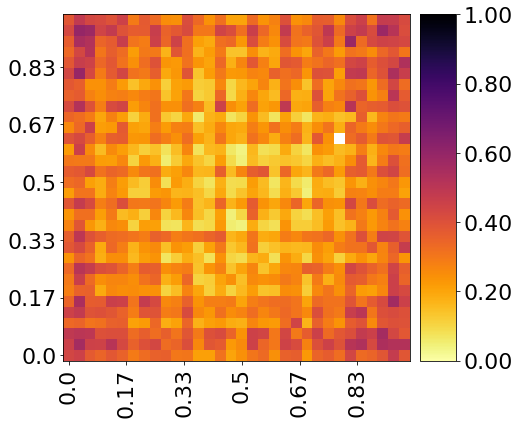

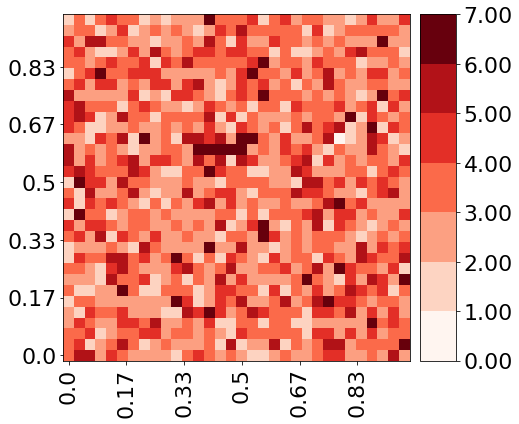

In [52]:
"""
-------------------------------------------------------------------------
Edit this part to do the exercises
"""

# TODO: change these parameters
NO_BINS=32          # default 32
MAX_ITEMS_BIN=1     # default 1
BUDGET=10000        # default 10000
BATCH_SIZE=500      # default 500
PROBLEM_DIM=3       # default 3

"""
-------------------------------------------------------------------------
"""

main(NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [55]:
# You may want to import your own packages if the pickle file contains custom objects
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex1\32 BIN\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES: ",grid.best.features)

GRID BEST:  Individual([0.5032989915112229, 0.6086501029689058, 0.6020789942298949])
GRID BEST FITNESS:  (0.03864052645837827,)
GRID BEST FEATURES:  [0.5032989915112229, 0.6086501029689058]


### NO_BINS = 32, 10D

Seed: 876736


alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed


RandomSearchMutPolyBounded-2011103425872     0         395/1024  500       442            [0.3942]  [0.0689]  [0.2315]  [0.6114]  [0.0016,0.0002]     [0.9871,0.9996]     239.31    1.27   


RandomSearchMutPolyBounded-2011103425872     1         571/1024  500       320            [0.3852]  [0.0672]  [0.2175]  [0.6114]  [0.0016,0.0040]     [0.9966,0.9995]     351.07    1.53   


RandomSearchMutPolyBounded-2011103425872     2         683/1024  500       260            [0.3805]  [0.0688]  [0.2175]  [0.6027]  [0.0016,0.0000]     [0.9995,0.9995]     423.13    1.49   


RandomSearchMutPolyBounded-2011103425872     3         774/1024  500       245            [0.3727]  [0.0669]  [0.1882]  [0.6039]  [0.0004,0.0000]     [0.9995,0.9995]     485.54    1.50   


RandomSearchMutPolyBounded-2011103425872     4         845/1024  500       244            [0.3654]  [0.0646]  [0.1838]  [0.5767]  [0.0004,0.0000]     [0.9995,0.9995]     536.27    1.57   


RandomSearchMutPolyBounded-2011103425872     5         902/1024  500       216            [0.3582]  [0.0623]  [0.1838]  [0.5767]  [0.0004,0.0000]     [0.9995,0.9988]     578.86    1.47   


RandomSearchMutPolyBounded-2011103425872     6         935/1024  500       181            [0.3523]  [0.0609]  [0.1764]  [0.5767]  [0.0001,0.0000]     [0.9995,0.9988]     605.57    1.47   


RandomSearchMutPolyBounded-2011103425872     7         954/1024  500       179            [0.3464]  [0.0594]  [0.1764]  [0.5767]  [0.0001,0.0000]     [0.9995,0.9988]     623.51    1.48   


RandomSearchMutPolyBounded-2011103425872     8         968/1024  500       177            [0.3407]  [0.0588]  [0.1604]  [0.5767]  [0.0001,0.0000]     [0.9995,0.9988]     638.24    1.48   


RandomSearchMutPolyBounded-2011103425872     9         982/1024  500       157            [0.3357]  [0.0589]  [0.1604]  [0.5767]  [0.0001,0.0000]     [0.9993,0.9988]     652.34    1.46   


RandomSearchMutPolyBounded-2011103425872     10        996/1024  500       142            [0.3315]  [0.0576]  [0.1604]  [0.5767]  [0.0001,0.0000]     [0.9993,0.9988]     665.84    1.42   


RandomSearchMutPolyBounded-2011103425872     11        1003/1024 500       139            [0.3281]  [0.0568]  [0.1604]  [0.5767]  [0.0004,0.0000]     [0.9993,0.9988]     673.92    1.36   


RandomSearchMutPolyBounded-2011103425872     12        1008/1024 500       125            [0.3248]  [0.0567]  [0.1604]  [0.5767]  [0.0004,0.0000]     [0.9993,0.9988]     680.56    1.46   


RandomSearchMutPolyBounded-2011103425872     13        1013/1024 500       134            [0.3212]  [0.0561]  [0.1604]  [0.5732]  [0.0004,0.0000]     [0.9993,0.9988]     687.64    1.45   


RandomSearchMutPolyBounded-2011103425872     14        1015/1024 500       115            [0.3173]  [0.0553]  [0.1604]  [0.5732]  [0.0004,0.0000]     [0.9993,0.9988]     692.91    1.36   


RandomSearchMutPolyBounded-2011103425872     15        1017/1024 500       108            [0.3135]  [0.0545]  [0.1604]  [0.5732]  [0.0004,0.0000]     [0.9993,0.9990]     698.13    1.39   


RandomSearchMutPolyBounded-2011103425872     16        1017/1024 500       116            [0.3098]  [0.053]   [0.1604]  [0.5732]  [0.0004,0.0000]     [0.9993,0.9990]     701.91    1.40   


RandomSearchMutPolyBounded-2011103425872     17        1018/1024 500       112            [0.3063]  [0.0518]  [0.1604]  [0.5214]  [0.0004,0.0001]     [0.9993,0.9990]     706.17    1.35   


RandomSearchMutPolyBounded-2011103425872     18        1020/1024 500       118            [0.3031]  [0.0507]  [0.1604]  [0.5214]  [0.0004,0.0001]     [0.9993,0.9990]     710.84    1.31   


RandomSearchMutPolyBounded-2011103425872     19        1022/1024 500       107            [0.3004]  [0.0504]  [0.1604]  [0.5214]  [0.0004,0.0001]     [0.9993,0.9988]     714.94    1.29   


Finished optimisation using algorithm 'RandomSearchMutPolyBounded-2011103425872'. Total elapsed: 28.9161081000002.



Summary RandomSearchMutPolyBounded:
  batch_size: 500
  budget: 10000
  container:  Summary Grid:
    activity_per_bin: [[3. 3. 4. ... 5. 2. 2.]  [1. 6. 3. ... 6. 3. 3.]  [4. 4. 7. ... 2. 3. 5.]  ...  [3. 0. 1. ... 2. 5. 2.]  [2. 3. 3. ... 4. 3. 4.]  [1. 4. 5. ... 1. 5. 3.]]
    best: Individual([0.4131135398792094, 0.5248313598483528, 0.6157545168474343, 0.6043385712456523, 0.49841164640063806, 0.4139496848866906, 0.20222728187137218, 0.36870549052131396, 0.7994420127874661, 0.2874937214225072])
    best_features: [0.4131135398792094, 0.5248313598483528]
    best_fitness: (0.1603571552383287,)
    best_index: (13, 16)
    capacity: 1024
    depot: None
    discard_random_on_bin_overload: False
    features: {(0, 0): [Features([0.007344539393221661, 0.026740367493585437])], (0, 1): [Features([0.01706605753705448, 0.04664635526300975])], (0, 2): [Features([0.012506700977599872, 0.07623101877808813])], (0, 3): [Features([0.012506700977599872, 0.113864 ...
    features_domain: ((0.0, 1.0

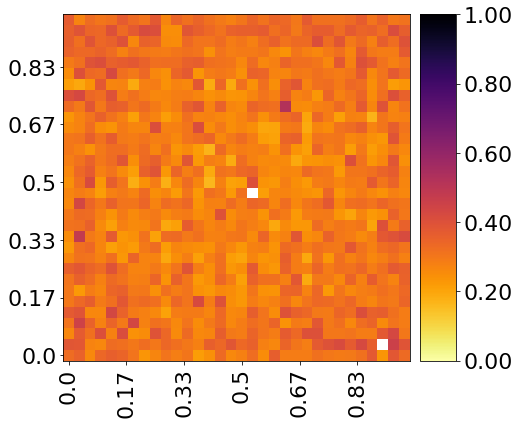

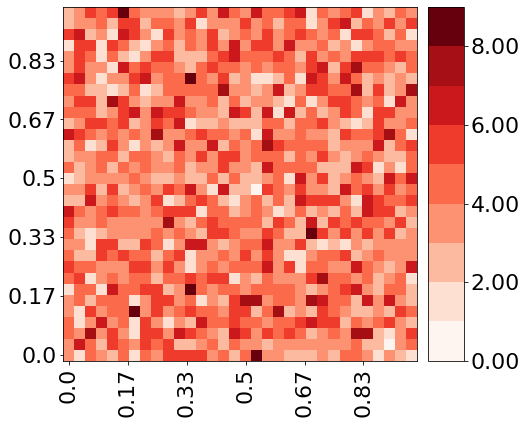

In [68]:
"""
-------------------------------------------------------------------------
Edit this part to do the exercises
"""

# TODO: change these parameters
NO_BINS=32          # default 32
MAX_ITEMS_BIN=1     # default 1
BUDGET=10000        # default 10000
BATCH_SIZE=500      # default 500
PROBLEM_DIM=10       # default 3

"""
-------------------------------------------------------------------------
"""

main(NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [69]:
# You may want to import your own packages if the pickle file contains custom objects
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex1\3210\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES: ",grid.best.features)

GRID BEST:  Individual([0.4131135398792094, 0.5248313598483528, 0.6157545168474343, 0.6043385712456523, 0.49841164640063806, 0.4139496848866906, 0.20222728187137218, 0.36870549052131396, 0.7994420127874661, 0.2874937214225072])
GRID BEST FITNESS:  (0.1603571552383287,)
GRID BEST FEATURES:  [0.4131135398792094, 0.5248313598483528]


### NO_BINS = 64

Seed: 784679



  1%|▍                                                              | 61/10000 [00:00<01:31, 108.47eval/s, iteration=0]


  1%|▊                                                             | 124/10000 [00:01<01:22, 120.43eval/s, iteration=0]


  2%|█▏                                                             | 186/10000 [00:01<01:39, 98.97eval/s, iteration=0]


  2%|█▌                                                            | 249/10000 [00:02<01:33, 103.77eval/s, iteration=0]


  3%|█▉                                                            | 312/10000 [00:02<01:25, 113.11eval/s, iteration=0]


  4%|██▎                                                           | 375/10000 [00:03<01:23, 115.44eval/s, iteration=0]


  4%|██▋                                                           | 438/10000 [00:04<01:23, 114.29eval/s, iteration=0]


  5%|███                                                           | 498/10000 [00:04<01:14, 127.62eval/s, iteration=0]
                                                                                                                       


alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed


 62%|█████████████████████████████████████▎                      | 6229/10000 [22:16<00:14, 252.18eval/s, iteration=12]
                                                                                                                       


RandomSearchMutPolyBounded-2011085210192     0         469/4096  500       483            [0.3968]  [0.1209]  [0.0538]  [0.7152]  [0.0011,0.0039]     [0.9994,0.9990]     282.90    4.51   


  6%|███▍                                                          | 560/10000 [00:05<01:23, 113.69eval/s, iteration=1]


  6%|███▊                                                          | 624/10000 [00:05<01:11, 130.82eval/s, iteration=1]


  7%|████▎                                                         | 688/10000 [00:06<01:13, 127.22eval/s, iteration=1]


  8%|████▋                                                         | 751/10000 [00:06<01:12, 127.69eval/s, iteration=1]


  8%|█████                                                         | 814/10000 [00:07<01:12, 126.07eval/s, iteration=1]


  9%|█████▍                                                        | 878/10000 [00:07<01:18, 116.64eval/s, iteration=1]


  9%|█████▊                                                        | 941/10000 [00:08<01:09, 130.16eval/s, iteration=1]


 10%|██████▏                                                       | 998/10000 [00:08<01:12, 123.52eval/s, iteration=1]
                                                                                                                       


RandomSearchMutPolyBounded-2011085210192     1         766/4096  500       331            [0.3961]  [0.1216]  [0.0538]  [0.7152]  [0.0011,0.0001]     [0.9994,0.9990]     462.57    4.16   


 62%|█████████████████████████████████████▎                      | 6229/10000 [22:20<00:14, 252.18eval/s, iteration=12]
                                                                                                                       
 11%|██████▌                                                       | 1060/10000 [00:09<01:40, 89.08eval/s, iteration=2]


 11%|██████▊                                                      | 1123/10000 [00:10<01:15, 117.63eval/s, iteration=2]


 12%|███████▏                                                     | 1187/10000 [00:10<01:10, 124.49eval/s, iteration=2]


 12%|███████▋                                                     | 1250/10000 [00:11<01:08, 127.68eval/s, iteration=2]


 13%|████████                                                     | 1313/10000 [00:11<01:08, 126.46eval/s, iteration=2]


 14%|████████▍                                                    | 1377/10000 [00:12<01:04, 134.20eval/s, iteration=2]


 14%|████████▊                                                    | 1440/10000 [00:12<01:06, 128.33eval/s, iteration=2]


 15%|█████████▏                                                   | 1499/10000 [00:13<01:08, 124.88eval/s, iteration=2]


RandomSearchMutPolyBounded-2011085210192     2         1030/4096 500       321            [0.3934]  [0.1223]  [0.0538]  [0.7393]  [0.0011,0.0001]     [0.9994,0.9999]     624.82    4.38   



 16%|█████████▋                                                    | 1561/10000 [00:13<01:24, 99.32eval/s, iteration=3]


 16%|█████████▉                                                   | 1624/10000 [00:14<01:13, 114.26eval/s, iteration=3]


 17%|██████████▎                                                  | 1687/10000 [00:15<01:18, 106.19eval/s, iteration=3]


 18%|██████████▋                                                  | 1750/10000 [00:15<01:06, 124.11eval/s, iteration=3]


 18%|███████████                                                  | 1813/10000 [00:16<01:07, 120.44eval/s, iteration=3]


 19%|███████████▍                                                 | 1876/10000 [00:16<01:07, 120.53eval/s, iteration=3]


 19%|███████████▊                                                 | 1939/10000 [00:17<01:13, 108.95eval/s, iteration=3]


 20%|████████████▏                                                | 1999/10000 [00:17<01:13, 109.16eval/s, iteration=3]


RandomSearchMutPolyBounded-2011085210192     3         1268/4096 500       299            [0.3941]  [0.1236]  [0.0538]  [0.7559]  [0.0011,0.0001]     [0.9994,0.9999]     768.29    4.50   



 21%|████████████▌                                                | 2061/10000 [00:18<01:17, 102.18eval/s, iteration=4]


 21%|████████████▉                                                | 2124/10000 [00:19<01:12, 108.40eval/s, iteration=4]


 22%|█████████████▎                                               | 2188/10000 [00:19<01:07, 114.95eval/s, iteration=4]


 23%|█████████████▋                                               | 2251/10000 [00:20<01:15, 102.95eval/s, iteration=4]


 23%|██████████████                                               | 2314/10000 [00:20<01:09, 110.98eval/s, iteration=4]


 24%|██████████████▍                                              | 2377/10000 [00:21<01:05, 116.66eval/s, iteration=4]


 24%|██████████████▉                                              | 2440/10000 [00:21<01:02, 121.04eval/s, iteration=4]


 25%|███████████████▏                                             | 2499/10000 [00:22<00:58, 127.91eval/s, iteration=4]


RandomSearchMutPolyBounded-2011085210192     4         1488/4096 500       285            [0.3928]  [0.1254]  [0.0398]  [0.802]   [0.0011,0.0001]     [0.9994,0.9999]     903.59    4.46   



 26%|███████████████▉                                              | 2561/10000 [00:22<01:17, 96.57eval/s, iteration=5]


 26%|████████████████                                             | 2624/10000 [00:23<01:03, 115.27eval/s, iteration=5]


 27%|████████████████▍                                            | 2687/10000 [00:24<01:07, 108.98eval/s, iteration=5]


 28%|████████████████▊                                            | 2751/10000 [00:24<00:58, 124.08eval/s, iteration=5]


 28%|█████████████████▏                                           | 2814/10000 [00:25<01:02, 114.62eval/s, iteration=5]


 29%|█████████████████▌                                           | 2877/10000 [00:25<00:58, 121.56eval/s, iteration=5]


 29%|█████████████████▉                                           | 2940/10000 [00:26<00:59, 119.25eval/s, iteration=5]


 30%|██████████████████▎                                          | 2999/10000 [00:26<01:00, 116.50eval/s, iteration=5]


RandomSearchMutPolyBounded-2011085210192     5         1678/4096 500       280            [0.3894]  [0.1253]  [0.0398]  [0.802]   [0.0009,0.0001]     [0.9994,0.9999]     1024.54   4.46   



 31%|██████████████████▋                                          | 3061/10000 [00:27<01:06, 104.27eval/s, iteration=6]


 31%|███████████████████                                          | 3124/10000 [00:27<00:58, 117.30eval/s, iteration=6]


 32%|███████████████████▍                                         | 3187/10000 [00:28<00:53, 126.28eval/s, iteration=6]


 33%|███████████████████▊                                         | 3251/10000 [00:29<00:56, 118.61eval/s, iteration=6]


 33%|████████████████████▏                                        | 3314/10000 [00:29<00:57, 116.38eval/s, iteration=6]


 34%|████████████████████▌                                        | 3377/10000 [00:30<00:59, 111.74eval/s, iteration=6]


 34%|█████████████████████▎                                        | 3439/10000 [00:30<01:09, 95.05eval/s, iteration=6]


 35%|█████████████████████▎                                       | 3499/10000 [00:31<00:59, 108.87eval/s, iteration=6]


RandomSearchMutPolyBounded-2011085210192     6         1855/4096 500       264            [0.3882]  [0.1248]  [0.0167]  [0.802]   [0.0009,0.0001]     [0.9994,0.9999]     1134.83   4.62   



 36%|██████████████████████                                        | 3561/10000 [00:32<01:04, 99.47eval/s, iteration=7]


 36%|██████████████████████                                       | 3623/10000 [00:32<01:00, 105.53eval/s, iteration=7]


 37%|██████████████████████▍                                      | 3686/10000 [00:33<00:58, 108.25eval/s, iteration=7]


 37%|██████████████████████▊                                      | 3749/10000 [00:33<01:00, 103.75eval/s, iteration=7]


 38%|███████████████████████▎                                     | 3812/10000 [00:34<00:53, 115.43eval/s, iteration=7]


 39%|███████████████████████▋                                     | 3875/10000 [00:34<00:50, 120.16eval/s, iteration=7]


 39%|████████████████████████                                     | 3938/10000 [00:35<00:53, 114.16eval/s, iteration=7]


 40%|████████████████████████▍                                    | 3999/10000 [00:36<00:53, 112.91eval/s, iteration=7]


RandomSearchMutPolyBounded-2011085210192     7         2032/4096 500       267            [0.3866]  [0.1255]  [0.0167]  [0.8356]  [0.0009,0.0001]     [0.9995,0.9999]     1246.36   4.71   



 41%|█████████████████████████▏                                    | 4061/10000 [00:36<01:01, 96.62eval/s, iteration=8]


 41%|█████████████████████████▏                                   | 4124/10000 [00:37<00:53, 109.93eval/s, iteration=8]


 42%|█████████████████████████▌                                   | 4186/10000 [00:38<00:55, 104.82eval/s, iteration=8]


 42%|█████████████████████████▉                                   | 4249/10000 [00:38<00:51, 112.11eval/s, iteration=8]


 43%|██████████████████████████▎                                  | 4312/10000 [00:39<00:50, 113.73eval/s, iteration=8]


 44%|██████████████████████████▋                                  | 4375/10000 [00:39<00:50, 111.15eval/s, iteration=8]


 44%|███████████████████████████                                  | 4438/10000 [00:40<00:53, 104.61eval/s, iteration=8]


 45%|███████████████████████████▍                                 | 4499/10000 [00:40<00:51, 106.02eval/s, iteration=8]


RandomSearchMutPolyBounded-2011085210192     8         2186/4096 500       256            [0.3842]  [0.1257]  [0.0167]  [0.802]   [0.0009,0.0001]     [0.9995,0.9999]     1346.24   4.69   



 46%|████████████████████████████▎                                 | 4559/10000 [00:41<01:10, 76.96eval/s, iteration=9]


 46%|████████████████████████████▋                                 | 4621/10000 [00:42<00:58, 91.98eval/s, iteration=9]


 47%|█████████████████████████████                                 | 4682/10000 [00:43<01:02, 85.12eval/s, iteration=9]


 47%|█████████████████████████████▍                                | 4744/10000 [00:44<01:04, 81.95eval/s, iteration=9]


 48%|█████████████████████████████▊                                | 4806/10000 [00:44<00:56, 91.53eval/s, iteration=9]


 49%|██████████████████████████████▏                               | 4868/10000 [00:45<00:54, 94.93eval/s, iteration=9]


 49%|██████████████████████████████                               | 4930/10000 [00:46<00:49, 101.68eval/s, iteration=9]


 50%|██████████████████████████████▉                               | 4992/10000 [00:46<00:52, 95.87eval/s, iteration=9]


 50%|███████████████████████████████                               | 5000/10000 [00:46<00:51, 96.16eval/s, iteration=9]


RandomSearchMutPolyBounded-2011085210192     9         2329/4096 500       227            [0.3826]  [0.1254]  [0.0167]  [0.763]   [0.0009,0.0001]     [0.9995,0.9999]     1437.99   5.88   



 51%|██████████████████████████████▊                              | 5060/10000 [00:47<01:03, 77.39eval/s, iteration=10]


 51%|███████████████████████████████▏                             | 5122/10000 [00:48<00:56, 85.74eval/s, iteration=10]


 52%|███████████████████████████████▌                             | 5184/10000 [00:49<00:55, 87.44eval/s, iteration=10]


 52%|███████████████████████████████▍                            | 5246/10000 [00:49<00:45, 104.38eval/s, iteration=10]


 53%|███████████████████████████████▊                            | 5309/10000 [00:50<00:45, 103.63eval/s, iteration=10]


 54%|████████████████████████████████▏                           | 5372/10000 [00:51<00:44, 104.31eval/s, iteration=10]


 54%|████████████████████████████████▌                           | 5434/10000 [00:51<00:42, 106.53eval/s, iteration=10]


 55%|████████████████████████████████▉                           | 5497/10000 [00:52<00:41, 108.36eval/s, iteration=10]


 55%|████████████████████████████████▉                           | 5499/10000 [00:52<00:41, 108.36eval/s, iteration=10]


RandomSearchMutPolyBounded-2011085210192     10        2461/4096 500       234            [0.3795]  [0.1257]  [0.0167]  [0.763]   [0.0009,0.0001]     [0.9995,0.9999]     1526.97   5.27   



 56%|█████████████████████████████████▉                           | 5561/10000 [00:53<00:48, 91.34eval/s, iteration=11]


 56%|█████████████████████████████████▋                          | 5624/10000 [00:53<00:39, 110.68eval/s, iteration=11]


 57%|██████████████████████████████████▋                          | 5686/10000 [00:54<00:46, 92.43eval/s, iteration=11]


 57%|██████████████████████████████████▌                         | 5750/10000 [00:54<00:37, 113.67eval/s, iteration=11]


 58%|██████████████████████████████████▊                         | 5812/10000 [00:55<00:38, 109.12eval/s, iteration=11]


 59%|███████████████████████████████████▊                         | 5875/10000 [00:56<00:43, 95.35eval/s, iteration=11]


 59%|███████████████████████████████████▌                        | 5937/10000 [00:56<00:37, 106.98eval/s, iteration=11]


 60%|████████████████████████████████████▌                        | 5999/10000 [00:57<00:41, 95.72eval/s, iteration=11]


RandomSearchMutPolyBounded-2011085210192     11        2602/4096 500       242            [0.3774]  [0.1245]  [0.0167]  [0.763]   [0.0009,0.0001]     [0.9995,0.9999]     1620.11   4.98   



 61%|████████████████████████████████████▉                        | 6059/10000 [00:58<00:47, 82.43eval/s, iteration=12]


 61%|█████████████████████████████████████▎                       | 6121/10000 [00:58<00:45, 84.99eval/s, iteration=12]


 62%|█████████████████████████████████████                       | 6184/10000 [00:59<00:33, 113.81eval/s, iteration=12]


 62%|█████████████████████████████████████▍                      | 6247/10000 [01:00<00:34, 110.09eval/s, iteration=12]


 63%|█████████████████████████████████████▊                      | 6310/10000 [01:00<00:32, 114.72eval/s, iteration=12]


 64%|██████████████████████████████████████▏                     | 6373/10000 [01:01<00:29, 121.62eval/s, iteration=12]


 64%|██████████████████████████████████████▌                     | 6436/10000 [01:01<00:34, 104.66eval/s, iteration=12]


 65%|███████████████████████████████████████▋                     | 6499/10000 [01:02<00:36, 95.78eval/s, iteration=12]


RandomSearchMutPolyBounded-2011085210192     12        2718/4096 500       226            [0.3753]  [0.1242]  [0.0167]  [0.763]   [0.0009,0.0001]     [0.9995,0.9999]     1697.89   5.03   



 66%|████████████████████████████████████████                     | 6560/10000 [01:03<00:36, 95.18eval/s, iteration=13]


 66%|███████████████████████████████████████▋                    | 6623/10000 [01:03<00:29, 116.04eval/s, iteration=13]


 67%|████████████████████████████████████████                    | 6686/10000 [01:04<00:29, 111.95eval/s, iteration=13]


 67%|████████████████████████████████████████▍                   | 6749/10000 [01:04<00:29, 111.88eval/s, iteration=13]


 68%|████████████████████████████████████████▊                   | 6812/10000 [01:05<00:29, 107.27eval/s, iteration=13]


 69%|█████████████████████████████████████████▎                  | 6875/10000 [01:06<00:29, 104.55eval/s, iteration=13]


 69%|█████████████████████████████████████████▌                  | 6937/10000 [01:06<00:28, 106.42eval/s, iteration=13]


 70%|█████████████████████████████████████████▉                  | 6999/10000 [01:07<00:28, 105.73eval/s, iteration=13]


RandomSearchMutPolyBounded-2011085210192     13        2819/4096 500       202            [0.3737]  [0.1233]  [0.0167]  [0.763]   [0.0004,0.0001]     [0.9995,0.9999]     1765.41   4.83   



 71%|███████████████████████████████████████████                  | 7061/10000 [01:08<00:31, 94.44eval/s, iteration=14]


 71%|██████████████████████████████████████████▋                 | 7124/10000 [01:08<00:25, 112.23eval/s, iteration=14]


 72%|███████████████████████████████████████████                 | 7187/10000 [01:09<00:26, 107.39eval/s, iteration=14]


 72%|███████████████████████████████████████████▍                | 7249/10000 [01:09<00:27, 101.63eval/s, iteration=14]


 73%|███████████████████████████████████████████▊                | 7312/10000 [01:10<00:26, 100.23eval/s, iteration=14]


 74%|████████████████████████████████████████████▏               | 7374/10000 [01:11<00:26, 100.30eval/s, iteration=14]


 74%|████████████████████████████████████████████▌               | 7436/10000 [01:11<00:23, 107.17eval/s, iteration=14]


 75%|████████████████████████████████████████████▉               | 7499/10000 [01:12<00:21, 115.42eval/s, iteration=14]


RandomSearchMutPolyBounded-2011085210192     14        2915/4096 500       212            [0.3726]  [0.123]   [0.0167]  [0.763]   [0.0004,0.0001]     [1.0000,0.9999]     1828.86   4.83   



 76%|██████████████████████████████████████████████               | 7561/10000 [01:12<00:26, 93.50eval/s, iteration=15]


 76%|█████████████████████████████████████████████▋              | 7624/10000 [01:13<00:22, 104.19eval/s, iteration=15]


 77%|██████████████████████████████████████████████              | 7686/10000 [01:14<00:22, 100.95eval/s, iteration=15]


 77%|██████████████████████████████████████████████▍             | 7749/10000 [01:14<00:19, 113.28eval/s, iteration=15]


 78%|██████████████████████████████████████████████▊             | 7812/10000 [01:15<00:20, 106.09eval/s, iteration=15]


 79%|███████████████████████████████████████████████▎            | 7875/10000 [01:15<00:19, 106.88eval/s, iteration=15]


 79%|███████████████████████████████████████████████▋            | 7938/10000 [01:16<00:18, 109.20eval/s, iteration=15]


 80%|███████████████████████████████████████████████▉            | 7999/10000 [01:16<00:16, 125.01eval/s, iteration=15]


RandomSearchMutPolyBounded-2011085210192     15        2995/4096 500       180            [0.3716]  [0.1235]  [0.0167]  [0.763]   [0.0004,0.0001]     [1.0000,0.9999]     1881.92   4.73   



 81%|█████████████████████████████████████████████████▏           | 8061/10000 [01:17<00:21, 89.08eval/s, iteration=16]


 81%|████████████████████████████████████████████████▋           | 8124/10000 [01:18<00:16, 112.15eval/s, iteration=16]


 82%|█████████████████████████████████████████████████           | 8187/10000 [01:18<00:17, 103.65eval/s, iteration=16]


 82%|█████████████████████████████████████████████████▌          | 8250/10000 [01:19<00:15, 112.59eval/s, iteration=16]


 83%|█████████████████████████████████████████████████▉          | 8313/10000 [01:20<00:15, 108.64eval/s, iteration=16]


 84%|██████████████████████████████████████████████████▎         | 8375/10000 [01:20<00:14, 112.55eval/s, iteration=16]


 84%|███████████████████████████████████████████████████▍         | 8438/10000 [01:21<00:15, 99.80eval/s, iteration=16]


 85%|███████████████████████████████████████████████████▊         | 8500/10000 [01:21<00:15, 98.30eval/s, iteration=16]


RandomSearchMutPolyBounded-2011085210192     16        3079/4096 500       198            [0.3693]  [0.1229]  [0.0167]  [0.763]   [0.0004,0.0001]     [1.0000,0.9999]     1941.85   4.89   



 86%|████████████████████████████████████████████████████▏        | 8561/10000 [01:22<00:17, 81.68eval/s, iteration=17]


 86%|███████████████████████████████████████████████████▋        | 8624/10000 [01:23<00:13, 105.32eval/s, iteration=17]


 87%|████████████████████████████████████████████████████▉        | 8686/10000 [01:24<00:13, 95.24eval/s, iteration=17]


 87%|████████████████████████████████████████████████████▍       | 8749/10000 [01:24<00:11, 107.52eval/s, iteration=17]


 88%|█████████████████████████████████████████████████████▋       | 8811/10000 [01:25<00:12, 94.91eval/s, iteration=17]


 89%|█████████████████████████████████████████████████████▏      | 8873/10000 [01:25<00:10, 104.80eval/s, iteration=17]


 89%|█████████████████████████████████████████████████████▌      | 8936/10000 [01:26<00:09, 116.24eval/s, iteration=17]


 90%|█████████████████████████████████████████████████████▉      | 8999/10000 [01:27<00:08, 113.80eval/s, iteration=17]


RandomSearchMutPolyBounded-2011085210192     17        3151/4096 500       200            [0.3671]  [0.1227]  [0.0167]  [0.763]   [0.0004,0.0001]     [1.0000,0.9999]     1994.14   5.04   



 91%|███████████████████████████████████████████████████████▎     | 9061/10000 [01:27<00:10, 87.90eval/s, iteration=18]


 91%|██████████████████████████████████████████████████████▋     | 9124/10000 [01:28<00:07, 118.43eval/s, iteration=18]


 92%|███████████████████████████████████████████████████████     | 9187/10000 [01:29<00:08, 100.21eval/s, iteration=18]


 92%|███████████████████████████████████████████████████████▌    | 9250/10000 [01:29<00:06, 109.12eval/s, iteration=18]


 93%|███████████████████████████████████████████████████████▉    | 9313/10000 [01:30<00:05, 118.24eval/s, iteration=18]


 94%|████████████████████████████████████████████████████████▎   | 9375/10000 [01:30<00:06, 102.08eval/s, iteration=18]


 94%|████████████████████████████████████████████████████████▋   | 9438/10000 [01:31<00:05, 111.18eval/s, iteration=18]


 95%|████████████████████████████████████████████████████████▉   | 9499/10000 [01:31<00:04, 123.64eval/s, iteration=18]


RandomSearchMutPolyBounded-2011085210192     18        3232/4096 500       178            [0.3654]  [0.1218]  [0.0167]  [0.763]   [0.0004,0.0001]     [1.0000,0.9999]     2050.94   4.68   



 96%|█████████████████████████████████████████████████████████▎  | 9561/10000 [01:32<00:03, 109.98eval/s, iteration=19]


 96%|█████████████████████████████████████████████████████████▋  | 9624/10000 [01:33<00:03, 109.43eval/s, iteration=19]


 97%|██████████████████████████████████████████████████████████  | 9687/10000 [01:33<00:02, 109.91eval/s, iteration=19]


 98%|██████████████████████████████████████████████████████████▌ | 9750/10000 [01:34<00:02, 110.87eval/s, iteration=19]


 98%|██████████████████████████████████████████████████████████▉ | 9813/10000 [01:34<00:01, 116.36eval/s, iteration=19]


 99%|████████████████████████████████████████████████████████████▏| 9876/10000 [01:35<00:01, 99.20eval/s, iteration=19]


 99%|███████████████████████████████████████████████████████████▋| 9938/10000 [01:36<00:00, 105.04eval/s, iteration=19]


100%|████████████████████████████████████████████████████████████▉| 9999/10000 [01:36<00:00, 93.29eval/s, iteration=19]


RandomSearchMutPolyBounded-2011085210192     19        3294/4096 500       172            [0.3639]  [0.1221]  [0.0167]  [0.763]   [0.0004,0.0001]     [1.0000,0.9999]     2095.34   4.87   



100%|████████████████████████████████████████████████████████████| 10000/10000 [01:36<00:00, 93.29eval/s, iteration=19]


Finished optimisation using algorithm 'RandomSearchMutPolyBounded-2011085210192'. Total elapsed: 96.89342690000012.



100%|████████████████████████████████████████████████████████████| 10000/10000 [01:36<00:00, 93.29eval/s, iteration=19]
                                                                                                                       


Summary RandomSearchMutPolyBounded:
  batch_size: 500
  budget: 10000
  container:  Summary Grid:
    activity_per_bin: [[1. 2. 0. ... 1. 2. 1.]  [2. 1. 1. ... 1. 1. 1.]  [0. 1. 1. ... 1. 2. 1.]  ...  [2. 2. 1. ... 3. 0. 2.]  [1. 1. 2. ... 0. 2. 1.]  [1. 0. 1. ... 0. 2. 1.]]
    best: Individual([0.5023360589842731, 0.603111939896821, 0.49519370527047324])
    best_features: [0.5023360589842731, 0.603111939896821]
    best_fitness: (0.016695330283972295,)
    best_index: (32, 38)
    capacity: 4096
    depot: None
    discard_random_on_bin_overload: False
    features: {(0, 0): [Features([0.0044989956208518755, 0.0064894490228321056])], (0, 1): [Features([0.006734511315951042, 0.01787627966316019])], (0, 2): [], (0, 3): [], (0, 4): [Features([0.0030762131911757917, 0.07096511972183717])], (0, 5): [Features([0. ...
    features_domain: ((0.0, 1.0), (0.0, 1.0))
    features_extrema: ((0.0004367711782669037, 0.999959660756671), (0.0001381286519060998, 0.9998550865733096))
    filled_bins

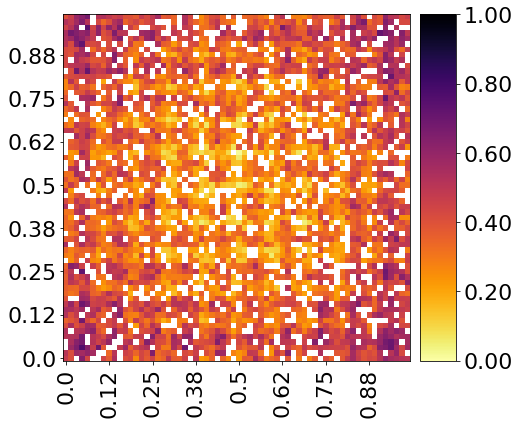

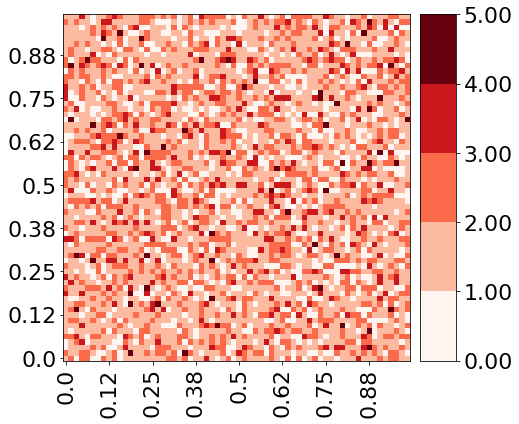

In [56]:
"""
-------------------------------------------------------------------------
Edit this part to do the exercises
"""

# TODO: change these parameters
NO_BINS=64          # default 32
MAX_ITEMS_BIN=1     # default 1
BUDGET=10000        # default 10000
BATCH_SIZE=500      # default 500
PROBLEM_DIM=3       # default 3

"""
-------------------------------------------------------------------------
"""

main(NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [57]:
# You may want to import your own packages if the pickle file contains custom objects
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex1\64 BIN\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES: ",grid.best.features)

GRID BEST:  Individual([0.5023360589842731, 0.603111939896821, 0.49519370527047324])
GRID BEST FITNESS:  (0.016695330283972295,)
GRID BEST FEATURES:  [0.5023360589842731, 0.603111939896821]


### NO_BINS = 128

Seed: 23073


alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed


RandomSearchMutPolyBounded-2011092320112     0         491/16384 500       494            [0.3898]  [0.1212]  [0.1087]  [0.751]   [0.0011,0.0009]     [0.9905,0.9919]     299.60    3.02   


RandomSearchMutPolyBounded-2011092320112     1         808/16384 500       338            [0.3922]  [0.1228]  [0.095]   [0.751]   [0.0009,0.0009]     [0.9944,0.9919]     491.09    2.63   


RandomSearchMutPolyBounded-2011092320112     2         1114/16384     500       338            [0.3922]  [0.1245]  [0.0706]  [0.8387]  [0.0009,0.0009]     [0.9948,0.9972]     677.11    2.91   


RandomSearchMutPolyBounded-2011092320112     3         1431/16384     500       342            [0.3946]  [0.1253]  [0.0706]  [0.8387]  [0.0006,0.0009]     [0.9948,0.9972]     866.32    3.13   


RandomSearchMutPolyBounded-2011092320112     4         1726/16384     500       332            [0.3937]  [0.1262]  [0.0677]  [0.8387]  [0.0006,0.0009]     [0.9998,0.9995]     1046.53   3.32   


RandomSearchMutPolyBounded-2011092320112     5         2024/16384     500       337            [0.3919]  [0.1251]  [0.0677]  [0.8387]  [0.0006,0.0000]     [0.9998,0.9999]     1230.71   3.79   


RandomSearchMutPolyBounded-2011092320112     6         2321/16384     500       332            [0.3908]  [0.1265]  [0.0677]  [0.8387]  [0.0003,0.0000]     [0.9998,0.9999]     1413.92   3.58   


RandomSearchMutPolyBounded-2011092320112     7         2598/16384     500       330            [0.3898]  [0.1262]  [0.0677]  [0.8387]  [0.0003,0.0000]     [0.9998,0.9999]     1585.42   3.87   


RandomSearchMutPolyBounded-2011092320112     8         2856/16384     500       294            [0.3889]  [0.125]   [0.0677]  [0.8387]  [0.0003,0.0000]     [0.9998,0.9999]     1745.28   3.71   


RandomSearchMutPolyBounded-2011092320112     9         3123/16384     500       321            [0.3889]  [0.1253]  [0.0677]  [0.8089]  [0.0003,0.0000]     [0.9998,0.9999]     1908.40   4.07   


RandomSearchMutPolyBounded-2011092320112     10        3408/16384     500       330            [0.3895]  [0.1247]  [0.0677]  [0.8089]  [0.0003,0.0000]     [0.9998,0.9999]     2080.73   4.39   


RandomSearchMutPolyBounded-2011092320112     11        3670/16384     500       309            [0.3896]  [0.1251]  [0.0662]  [0.8338]  [0.0003,0.0000]     [0.9998,0.9999]     2240.17   4.38   


RandomSearchMutPolyBounded-2011092320112     12        3914/16384     500       310            [0.3879]  [0.1248]  [0.0293]  [0.8338]  [0.0003,0.0000]     [0.9998,0.9999]     2395.61   4.49   


RandomSearchMutPolyBounded-2011092320112     13        4168/16384     500       314            [0.3886]  [0.1251]  [0.0293]  [0.8338]  [0.0003,0.0000]     [0.9998,0.9999]     2548.32   5.07   


RandomSearchMutPolyBounded-2011092320112     14        4427/16384     500       316            [0.3881]  [0.125]   [0.0293]  [0.8338]  [0.0003,0.0000]     [0.9998,0.9999]     2709.00   5.35   


RandomSearchMutPolyBounded-2011092320112     15        4659/16384     500       295            [0.3871]  [0.1247]  [0.0293]  [0.8338]  [0.0003,0.0000]     [0.9998,0.9999]     2855.35   4.80   


RandomSearchMutPolyBounded-2011092320112     16        4873/16384     500       284            [0.3857]  [0.1249]  [0.0293]  [0.8338]  [0.0003,0.0000]     [0.9998,0.9999]     2993.27   4.95   


RandomSearchMutPolyBounded-2011092320112     17        5121/16384     500       312            [0.3853]  [0.125]   [0.0293]  [0.8338]  [0.0003,0.0000]     [0.9998,0.9999]     3148.03   5.31   


RandomSearchMutPolyBounded-2011092320112     18        5345/16384     500       282            [0.3844]  [0.125]   [0.0293]  [0.8338]  [0.0003,0.0000]     [0.9998,0.9999]     3290.34   5.22   


RandomSearchMutPolyBounded-2011092320112     19        5561/16384     500       281            [0.384]   [0.1253]  [0.0293]  [0.8338]  [0.0003,0.0000]     [0.9998,0.9999]     3425.48   5.23   


Finished optimisation using algorithm 'RandomSearchMutPolyBounded-2011092320112'. Total elapsed: 85.12938519999989.



Summary RandomSearchMutPolyBounded:
  batch_size: 500
  budget: 10000
  container:  Summary Grid:
    activity_per_bin: [[0. 0. 0. ... 1. 0. 0.]  [0. 0. 1. ... 0. 0. 0.]  [0. 0. 0. ... 0. 0. 1.]  ...  [0. 2. 1. ... 0. 1. 0.]  [0. 0. 0. ... 1. 0. 1.]  [0. 1. 0. ... 2. 1. 0.]]
    best: Individual([0.5855766096895129, 0.5044656545997804, 0.49938997847034694])
    best_features: [0.5855766096895129, 0.5044656545997804]
    best_fitness: (0.029275760296676778,)
    best_index: (74, 64)
    capacity: 16384
    depot: None
    discard_random_on_bin_overload: False
    features: {(0, 0): [], (0, 1): [], (0, 2): [], (0, 3): [], (0, 4): [Features([0.0022226836475871536, 0.03134133050805332])], (0, 5): [], (0, 6): [], (0, 7): [], (0, 8): [], (0, 9): [], (0, 10): [], (0, 11): [], (0, 12): [], (0, 13): [], (0, 14): [Features ...
    features_domain: ((0.0, 1.0), (0.0, 1.0))
    features_extrema: ((0.00032822671091481403, 0.9998269952086943), (6.354193264002106e-06, 0.9999374127528755))
    filled

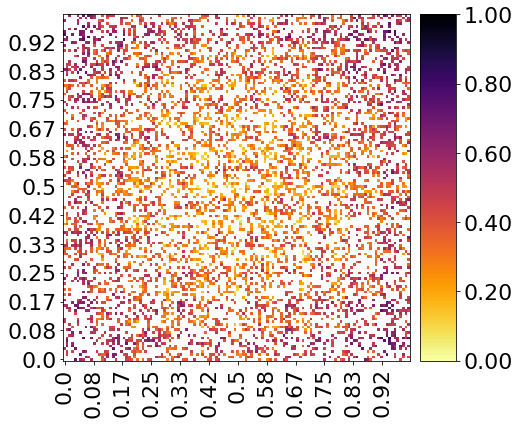

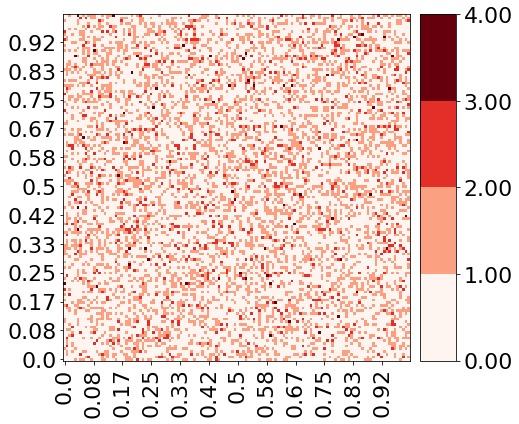

In [58]:
"""
-------------------------------------------------------------------------
Edit this part to do the exercises
"""

# TODO: change these parameters
NO_BINS= 128          # default 32
MAX_ITEMS_BIN=1     # default 1
BUDGET=10000        # default 10000
BATCH_SIZE=500      # default 500
PROBLEM_DIM=3       # default 3

"""
-------------------------------------------------------------------------
"""

main(NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [59]:
# You may want to import your own packages if the pickle file contains custom objects
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex1\128 BIN\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES: ",grid.best.features)

GRID BEST:  Individual([0.5855766096895129, 0.5044656545997804, 0.49938997847034694])
GRID BEST FITNESS:  (0.029275760296676778,)
GRID BEST FEATURES:  [0.5855766096895129, 0.5044656545997804]


#### The NO_BINS = 8 obtained the best performance, so let's try with different items

### MAX_ITEMS_BIN=2

Seed: 948989


alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed


RandomSearchMutPolyBounded-2011112163024     0         128/128   500       128            [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     1.19   


RandomSearchMutPolyBounded-2011112163024     1         128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     1.23   


RandomSearchMutPolyBounded-2011112163024     2         128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     0.94   


RandomSearchMutPolyBounded-2011112163024     3         128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     1.04   


RandomSearchMutPolyBounded-2011112163024     4         128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     1.00   


RandomSearchMutPolyBounded-2011112163024     5         128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     1.10   


RandomSearchMutPolyBounded-2011112163024     6         128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     1.13   


RandomSearchMutPolyBounded-2011112163024     7         128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     1.08   


RandomSearchMutPolyBounded-2011112163024     8         128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     0.97   


RandomSearchMutPolyBounded-2011112163024     9         128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     1.03   


RandomSearchMutPolyBounded-2011112163024     10        128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     1.06   


RandomSearchMutPolyBounded-2011112163024     11        128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     1.19   


RandomSearchMutPolyBounded-2011112163024     12        128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     1.04   


RandomSearchMutPolyBounded-2011112163024     13        128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     1.01   


RandomSearchMutPolyBounded-2011112163024     14        128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     0.96   


RandomSearchMutPolyBounded-2011112163024     15        128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     1.08   


RandomSearchMutPolyBounded-2011112163024     16        128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     1.13   


RandomSearchMutPolyBounded-2011112163024     17        128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     0.93   


RandomSearchMutPolyBounded-2011112163024     18        128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     0.90   


RandomSearchMutPolyBounded-2011112163024     19        128/128   500       0              [0.3984]  [0.127]   [0.1214]  [0.6759]  [0.0093,0.0191]     [0.9951,0.9980]     42.41     0.90   


Finished optimisation using algorithm 'RandomSearchMutPolyBounded-2011112163024'. Total elapsed: 21.142655799998465.



Summary RandomSearchMutPolyBounded:
  batch_size: 500
  budget: 10000
  container:  Summary Grid:
    activity_per_bin: [[2. 2. 2. 2. 2. 2. 2. 2.]  [2. 2. 2. 2. 2. 2. 2. 2.]  [2. 2. 2. 2. 2. 2. 2. 2.]  [2. 2. 2. 2. 2. 2. 2. 2.]  [2. 2. 2. 2. 2. 2. 2. 2.]  [2. 2. 2. 2. 2. 2. 2. 2.]  [2. 2. 2. 2. 2. 2. 2. 2.]  [2. 2. 2. 2. 2. 2. 2. 2.]]
    best: Individual([0.7833809600096104, 0.3945943727933968, 0.5843732502898591])
    best_features: [0.7833809600096104, 0.3945943727933968]
    best_fitness: (0.12137323455439164,)
    best_index: (6, 3)
    capacity: 128
    depot: None
    discard_random_on_bin_overload: False
    features: {(0, 0): [Features([0.10933222696124711, 0.09904634809578483]), Features([0.009343626234951996, 0.02924920783555307])], (0, 1): [Features([0.020668245664420826, 0.2066537486510377]), Features([0.08274599673324612, 0.23968288895286127])], (0, 2): ...
    features_domain: ((0.0, 1.0), (0.0, 1.0))
    features_extrema: ((0.009343626234951996, 0.9950511903005138), (0

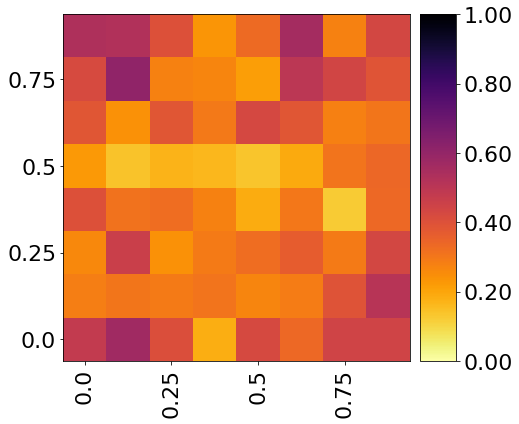

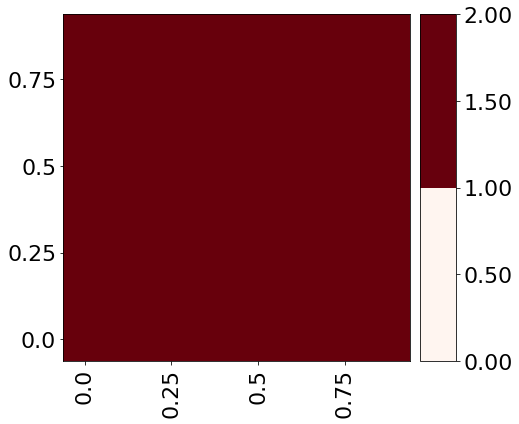

In [62]:
# TODO: change these parameters
NO_BINS=8          # default 32
MAX_ITEMS_BIN=2     # default 1
BUDGET=10000        # default 10000
BATCH_SIZE=500      # default 500
PROBLEM_DIM=3       # default 3

"""
-------------------------------------------------------------------------
"""
main(NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [63]:
# You may want to import your own packages if the pickle file contains custom objects
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex1\2 items\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES: ",grid.best.features)

GRID BEST:  Individual([0.7833809600096104, 0.3945943727933968, 0.5843732502898591])
GRID BEST FITNESS:  (0.12137323455439164,)
GRID BEST FEATURES:  [0.7833809600096104, 0.3945943727933968]


### MAX_ITEMS_BIN=5

Seed: 979348


alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed


RandomSearchMutPolyBounded-2011097403008     0         308/320   500       308            [0.3997]  [0.1306]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.07     1.15   


RandomSearchMutPolyBounded-2011097403008     1         320/320   500       15             [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     1.20   


RandomSearchMutPolyBounded-2011097403008     2         320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     1.42   


RandomSearchMutPolyBounded-2011097403008     3         320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     1.16   


RandomSearchMutPolyBounded-2011097403008     4         320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     1.16   


RandomSearchMutPolyBounded-2011097403008     5         320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     1.08   


RandomSearchMutPolyBounded-2011097403008     6         320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     0.92   


RandomSearchMutPolyBounded-2011097403008     7         320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     0.99   


RandomSearchMutPolyBounded-2011097403008     8         320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     0.96   


RandomSearchMutPolyBounded-2011097403008     9         320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     1.11   


RandomSearchMutPolyBounded-2011097403008     10        320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     1.09   


RandomSearchMutPolyBounded-2011097403008     11        320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     1.08   


RandomSearchMutPolyBounded-2011097403008     12        320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     1.28   


RandomSearchMutPolyBounded-2011097403008     13        320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     0.95   


RandomSearchMutPolyBounded-2011097403008     14        320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     1.02   


RandomSearchMutPolyBounded-2011097403008     15        320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     1.10   


RandomSearchMutPolyBounded-2011097403008     16        320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     1.05   


RandomSearchMutPolyBounded-2011097403008     17        320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     1.01   


RandomSearchMutPolyBounded-2011097403008     18        320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     0.91   


RandomSearchMutPolyBounded-2011097403008     19        320/320   500       0              [0.4008]  [0.1311]  [0.1028]  [0.7618]  [0.0010,0.0040]     [0.9981,0.9988]     46.09     0.89   


Finished optimisation using algorithm 'RandomSearchMutPolyBounded-2011097403008'. Total elapsed: 21.81144409999979.



Summary RandomSearchMutPolyBounded:
  batch_size: 500
  budget: 10000
  container:  Summary Grid:
    activity_per_bin: [[5. 5. 5. 5. 5. 5. 5. 5.]  [5. 5. 5. 5. 5. 5. 5. 5.]  [5. 5. 5. 5. 5. 5. 5. 5.]  [5. 5. 5. 5. 5. 5. 5. 5.]  [5. 5. 5. 5. 5. 5. 5. 5.]  [5. 5. 5. 5. 5. 5. 5. 5.]  [5. 5. 5. 5. 5. 5. 5. 5.]  [5. 5. 5. 5. 5. 5. 5. 5.]]
    best: Individual([0.5225869213559599, 0.4162408016391608, 0.5066266089922574])
    best_features: [0.5225869213559599, 0.4162408016391608]
    best_fitness: (0.10281159453535173,)
    best_index: (4, 3)
    capacity: 320
    depot: None
    discard_random_on_bin_overload: False
    features: {(0, 0): [Features([0.07762052980047085, 0.00684767830135935]), Features([0.06579231074644942, 0.014837496232433134]), Features([0.08495820810143684, 0.034157008146027845]), Features([0.00214466565415794, 0.057125267745976815]), Features([0.0238 ...
    features_domain: ((0.0, 1.0), (0.0, 1.0))
    features_extrema: ((0.00104987769940601, 0.9981363508988557), (0.

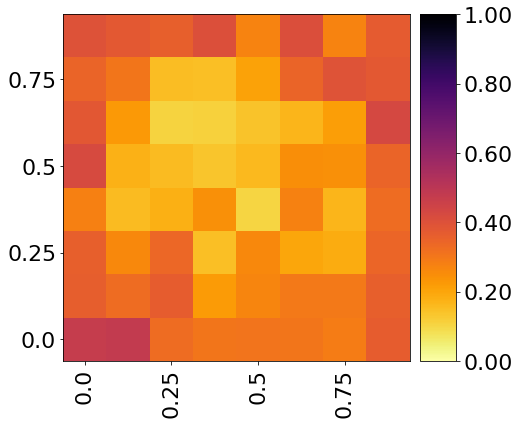

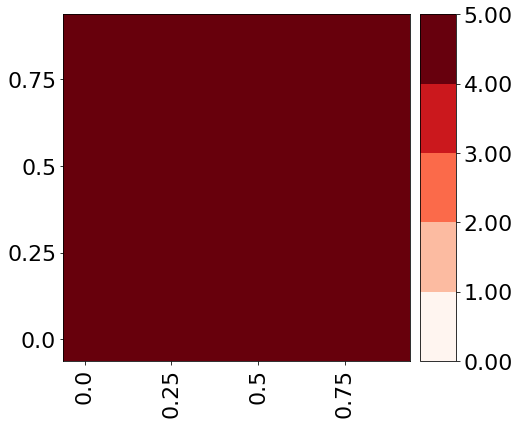

In [60]:
# TODO: change these parameters
NO_BINS=8          # default 32
MAX_ITEMS_BIN=5     # default 1
BUDGET=10000        # default 10000
BATCH_SIZE=500      # default 500
PROBLEM_DIM=3       # default 3

"""
-------------------------------------------------------------------------
"""
main(NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [61]:
# You may want to import your own packages if the pickle file contains custom objects
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex1\5 items\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES: ",grid.best.features)

GRID BEST:  Individual([0.5225869213559599, 0.4162408016391608, 0.5066266089922574])
GRID BEST FITNESS:  (0.10281159453535173,)
GRID BEST FEATURES:  [0.5225869213559599, 0.4162408016391608]


### MAX_ITEMS_BIN=5, 10D

Seed: 886070


alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed


RandomSearchMutPolyBounded-2011058956320     0         307/320   500       307            [0.3976]  [0.0655]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     42.95     1.21   


RandomSearchMutPolyBounded-2011058956320     1         319/320   500       12             [0.3983]  [0.0654]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     1.21   


RandomSearchMutPolyBounded-2011058956320     2         320/320   500       1              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.97   


RandomSearchMutPolyBounded-2011058956320     3         320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     1.00   


RandomSearchMutPolyBounded-2011058956320     4         320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.98   


RandomSearchMutPolyBounded-2011058956320     5         320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.98   


RandomSearchMutPolyBounded-2011058956320     6         320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.95   


RandomSearchMutPolyBounded-2011058956320     7         320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.87   


RandomSearchMutPolyBounded-2011058956320     8         320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.96   


RandomSearchMutPolyBounded-2011058956320     9         320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.92   


RandomSearchMutPolyBounded-2011058956320     10        320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.89   


RandomSearchMutPolyBounded-2011058956320     11        320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.83   


RandomSearchMutPolyBounded-2011058956320     12        320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.88   


RandomSearchMutPolyBounded-2011058956320     13        320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.84   


RandomSearchMutPolyBounded-2011058956320     14        320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.88   


RandomSearchMutPolyBounded-2011058956320     15        320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.94   


RandomSearchMutPolyBounded-2011058956320     16        320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.91   


RandomSearchMutPolyBounded-2011058956320     17        320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.84   


RandomSearchMutPolyBounded-2011058956320     18        320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.79   


RandomSearchMutPolyBounded-2011058956320     19        320/320   500       0              [0.3983]  [0.0653]  [0.2009]  [0.5999]  [0.0015,0.0038]     [0.9962,0.9782]     43.06     0.87   


Finished optimisation using algorithm 'RandomSearchMutPolyBounded-2011058956320'. Total elapsed: 18.942290000000867.



Summary RandomSearchMutPolyBounded:
  batch_size: 500
  budget: 10000
  container:  Summary Grid:
    activity_per_bin: [[5. 5. 5. 5. 5. 5. 5. 5.]  [5. 5. 5. 5. 5. 5. 5. 5.]  [5. 5. 5. 5. 5. 5. 5. 5.]  [5. 5. 5. 5. 5. 5. 5. 5.]  [5. 5. 5. 5. 5. 5. 5. 5.]  [5. 5. 5. 5. 5. 5. 5. 5.]  [5. 5. 5. 5. 5. 5. 5. 5.]  [5. 5. 5. 5. 5. 5. 5. 5.]]
    best: Individual([0.508728154620141, 0.592523918233804, 0.8108778162158994, 0.49335462615047565, 0.5877346212817915, 0.3727510377278901, 0.6249198512579703, 0.7799944159496491, 0.5055592137401589, 0.14433428627140155])
    best_features: [0.508728154620141, 0.592523918233804]
    best_fitness: (0.2008986710478118,)
    best_index: (4, 4)
    capacity: 320
    depot: None
    discard_random_on_bin_overload: False
    features: {(0, 0): [Features([0.038074093670391496, 0.012777740711966246]), Features([0.022155181212868524, 0.01481649892267145]), Features([0.10097425275271454, 0.052008741141400305]), Features([0.10550826462333074, 0.03191376503036092])

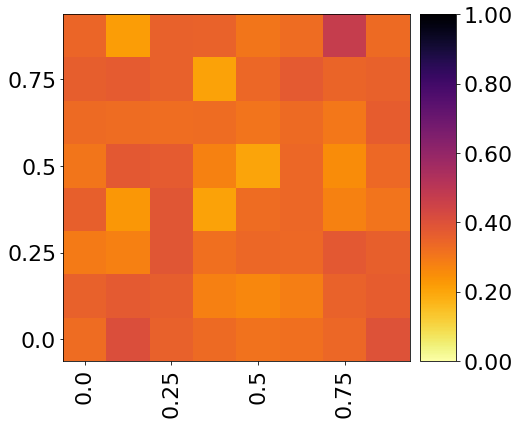

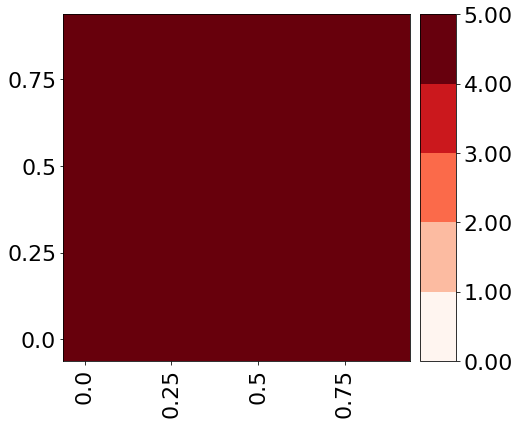

In [70]:
# TODO: change these parameters
NO_BINS=8          # default 32
MAX_ITEMS_BIN=5     # default 1
BUDGET=10000        # default 10000
BATCH_SIZE=500      # default 500
PROBLEM_DIM=10       # default 3

"""
-------------------------------------------------------------------------
"""
main(NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [71]:
# You may want to import your own packages if the pickle file contains custom objects
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex1\510\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES: ",grid.best.features)

GRID BEST:  Individual([0.508728154620141, 0.592523918233804, 0.8108778162158994, 0.49335462615047565, 0.5877346212817915, 0.3727510377278901, 0.6249198512579703, 0.7799944159496491, 0.5055592137401589, 0.14433428627140155])
GRID BEST FITNESS:  (0.2008986710478118,)
GRID BEST FEATURES:  [0.508728154620141, 0.592523918233804]


# Exercise 2
This exercise is similar to the previous one. The main difference is that in this case the **objective function** and **feature descriptor are defined by a custom function,** see `eval_fn`(function defined above), that returns for each individual its fitness (`score`) and two features (`fit0` and `fit1`). Note that the fitness and features are based on **trigonometric functions** and are defined as **scalable, i.e., they can be evaluated for any number of variables. 

To start the experiments, run the next cell. At the end of the run, the script will generate the same plots discussed in the previous exercise, as well as the pickle file containing the raw results, but it will save the results in the `results/ex2/seed` folder.


 - **What kind of considerations can you make in this case regarding the fitness trend and illumination pattern?**
 
 -  **Also in this case, try to change `NO_BINS` and `PROBLEM_DIM`, and see if you can confirm the observations made in the previous experiment.**
 
 - **If you want, you could try to change the custom function definition in `eval_fn` and replicate the experiment with a different setting. What kind of results do you obtain?**

### Trial 1, NO_BINS=32, MAX_ITEMS_BIN=1

* $score = 1 - \frac{1}{N} \sum_{i=0}^{N-1} \left( \cos(k \cdot \text{{ind}}[i]) \cdot \exp \left( -\frac{{\text{{ind}}[i]^2}}{2} \right) \right)$
* $fit0 = \frac{1}{\text{normalization}} \sum_{i=0}^{N-1} \left( x \cdot \sin \left( \left| x \right| \cdot 2 \pi \right) \right)$

* $fit1 = \frac{1}{\text{normalization}} \sum_{i=0}^{N-1} \left( x \cdot \cos \left( \left| x \right| \cdot 2 \pi \right) \right)$

Seed: 524615


alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed


RandomSearchMutPolyBounded-2010410408400     0         28/1024   500       29             [1.3039]  [0.3671]  [0.4861]  [1.7798]  [0.0024,0.0345]     [0.9823,0.9022]     8.19      2.93   


RandomSearchMutPolyBounded-2010410408400     1         106/1024  500       100            [1.3287]  [0.3535]  [0.3653]  [1.8272]  [0.0024,0.0179]     [0.9931,0.9095]     30.58     2.78   


RandomSearchMutPolyBounded-2010410408400     2         173/1024  500       103            [1.3249]  [0.357]   [0.2193]  [1.8264]  [0.0001,0.0166]     [0.9818,0.9095]     50.02     2.88   


RandomSearchMutPolyBounded-2010410408400     3         218/1024  500       78             [1.2731]  [0.3917]  [0.1264]  [1.8264]  [0.0001,0.0066]     [0.9955,0.9210]     64.83     2.45   


RandomSearchMutPolyBounded-2010410408400     4         256/1024  500       88             [1.2447]  [0.3904]  [0.1264]  [1.8264]  [0.0001,0.0066]     [0.9955,0.9210]     77.29     2.44   


RandomSearchMutPolyBounded-2010410408400     5         278/1024  500       66             [1.2296]  [0.3924]  [0.1264]  [1.8258]  [0.0001,0.0011]     [0.9955,0.9631]     84.59     2.51   


RandomSearchMutPolyBounded-2010410408400     6         299/1024  500       67             [1.2079]  [0.3901]  [0.1264]  [1.8258]  [0.0001,0.0011]     [0.9955,0.9781]     92.02     2.64   


RandomSearchMutPolyBounded-2010410408400     7         324/1024  500       64             [1.189]   [0.405]   [0.042]   [1.8258]  [0.0001,0.0011]     [0.9955,0.9781]     100.69    2.76   


RandomSearchMutPolyBounded-2010410408400     8         337/1024  500       57             [1.1741]  [0.4033]  [0.042]   [1.8085]  [0.0001,0.0011]     [0.9955,0.9781]     105.52    2.82   


RandomSearchMutPolyBounded-2010410408400     9         348/1024  500       67             [1.1662]  [0.4022]  [0.042]   [1.8085]  [0.0001,0.0011]     [0.9823,0.9781]     109.41    2.65   


RandomSearchMutPolyBounded-2010410408400     10        363/1024  500       56             [1.1582]  [0.401]   [0.042]   [1.8256]  [0.0001,0.0117]     [0.9823,0.9781]     114.59    2.83   


RandomSearchMutPolyBounded-2010410408400     11        374/1024  500       61             [1.1511]  [0.4046]  [0.042]   [1.802]   [0.0001,0.0033]     [0.9823,0.9781]     118.48    2.64   


RandomSearchMutPolyBounded-2010410408400     12        388/1024  500       55             [1.1317]  [0.4153]  [0.0233]  [1.802]   [0.0001,0.0117]     [0.9823,0.9863]     124.12    2.76   


RandomSearchMutPolyBounded-2010410408400     13        394/1024  500       60             [1.1195]  [0.4187]  [0.0233]  [1.802]   [0.0001,0.0117]     [0.9823,0.9863]     126.80    2.74   


RandomSearchMutPolyBounded-2010410408400     14        403/1024  500       58             [1.1159]  [0.416]   [0.0233]  [1.802]   [0.0001,0.0117]     [0.9823,0.9863]     129.93    2.83   


RandomSearchMutPolyBounded-2010410408400     15        406/1024  500       49             [1.1074]  [0.4145]  [0.0233]  [1.802]   [0.0001,0.0117]     [0.9823,0.9992]     131.45    2.78   


RandomSearchMutPolyBounded-2010410408400     16        411/1024  500       51             [1.1019]  [0.4164]  [0.0233]  [1.802]   [0.0001,0.0117]     [0.9823,0.9992]     133.42    2.82   


RandomSearchMutPolyBounded-2010410408400     17        413/1024  500       56             [1.0914]  [0.4163]  [0.0233]  [1.802]   [0.0001,0.0020]     [0.9823,0.9999]     134.76    2.74   


RandomSearchMutPolyBounded-2010410408400     18        417/1024  500       55             [1.0868]  [0.4146]  [0.0233]  [1.802]   [0.0001,0.0020]     [0.9837,0.9999]     136.37    2.29   


RandomSearchMutPolyBounded-2010410408400     19        422/1024  500       45             [1.0719]  [0.4211]  [0.0122]  [1.8011]  [0.0001,0.0020]     [0.9837,0.9999]     139.01    1.85   


Finished optimisation using algorithm 'RandomSearchMutPolyBounded-2010410408400'. Total elapsed: 53.613754000000085.



Summary RandomSearchMutPolyBounded:
  batch_size: 500
  budget: 10000
  container:  Summary Grid:
    activity_per_bin: [[6. 2. 2. ... 2. 1. 3.]  [3. 4. 5. ... 4. 1. 2.]  [0. 3. 5. ... 3. 1. 1.]  ...  [2. 3. 1. ... 0. 0. 0.]  [5. 2. 3. ... 0. 0. 0.]  [2. 2. 2. ... 0. 0. 0.]]
    best: Individual([2.31622776037943e-05, 0.026269019561845686, 0.006378741113418407])
    best_features: (0.13993211634973576, 0.9889158885407949)
    best_fitness: (0.01223076957894087,)
    best_index: (4, 31)
    capacity: 1024
    depot: None
    discard_random_on_bin_overload: False
    features: {(0, 0): [Features([0.010048085756691397, 0.007576895705215845])], (0, 1): [Features([0.02130156539801024, 0.04729564911043938])], (0, 2): [Features([0.012840341083052426, 0.07789641758079725])], (0, 3): [Features([0.02722582801231498, 0.1053087 ...
    features_domain: ((0.0, 1.0), (0.0, 1.0))
    features_extrema: ((7.969482607251131e-05, 0.9836672335756034), (0.002046520243428012, 0.9998672032398543))
    fille

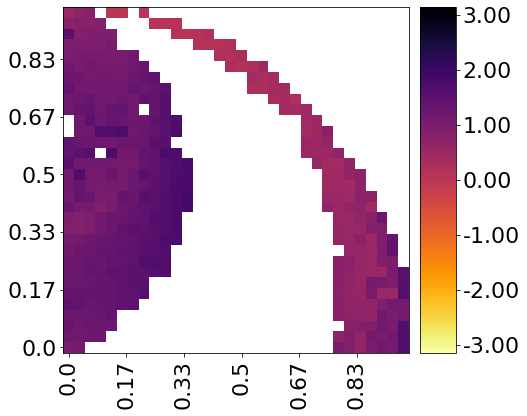

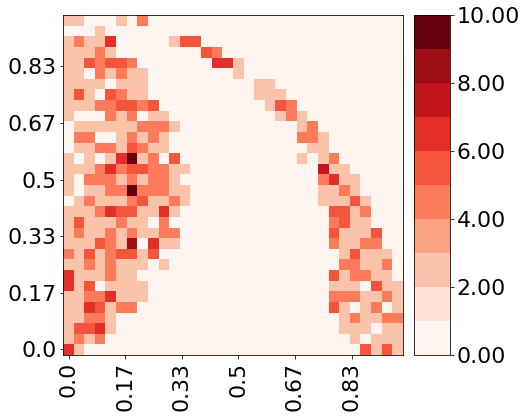

In [13]:
from utils.utils_12.exercise_custom_eval_fn import main
import math
"""
-------------------------------------------------------------------------
Edit this part to do the exercises
"""

# TODO: change these parameters
NO_BINS=32          # default 32
MAX_ITEMS_BIN=1     # default 1
BUDGET=10000        # default 10000
BATCH_SIZE=500      # default 500
PROBLEM_DIM=3       # default 3

# TODO: try to define a different objective function (score) and/or features (fit0, fit1)
def eval_fn(ind):
    """An example evaluation function. It takes an individual as input, and returns the pair ``(fitness, features)``, where ``fitness`` and ``features`` are sequences of scores."""
    normalization = sum((x for x in ind))
    k = 10.
    
    #objective function
    score = 1. - sum(( math.cos(k * ind[i]) * math.exp(-(ind[i]*ind[i])/2.) for i in range(len(ind)))) / float(len(ind))
    
    #features
    fit0 = sum((x * math.sin(abs(x) * 2. * math.pi) for x in ind)) / normalization
    fit1 = sum((x * math.cos(abs(x) * 2. * math.pi) for x in ind)) / normalization
    features = (fit0, fit1)
    
    
    return (score,), features

"""
-------------------------------------------------------------------------
"""
main(eval_fn, NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [73]:
# You may want to import your own packages if the pickle file contains custom objects
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex2\T1_32_1\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES: ",grid.best.features)

GRID BEST:  Individual([2.31622776037943e-05, 0.026269019561845686, 0.006378741113418407])
GRID BEST FITNESS:  (0.01223076957894087,)
GRID BEST FEATURES:  (0.13993211634973576, 0.9889158885407949)


### Trial 1, NO_BINS=32, MAX_ITEMS_BIN=5

Seed: 771317


alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed


RandomSearchMutPolyBounded-2011112397264     0         34/5120   500       34             [1.1503]  [0.4292]  [0.1923]  [1.8084]  [0.0044,0.0188]     [0.9649,0.9479]     10.09     3.03   


RandomSearchMutPolyBounded-2011112397264     1         155/5120  500       243            [1.1894]  [0.4291]  [0.0916]  [1.8364]  [0.0044,0.0073]     [0.9896,0.9567]     33.11     2.47   


RandomSearchMutPolyBounded-2011112397264     2         280/5120  500       215            [1.1519]  [0.4214]  [0.0916]  [1.8364]  [0.0006,0.0050]     [0.9896,0.9634]     52.98     2.34   


RandomSearchMutPolyBounded-2011112397264     3         386/5120  500       210            [1.1445]  [0.4292]  [0.0916]  [1.8364]  [0.0006,0.0050]     [0.9896,0.9886]     65.37     2.96   


RandomSearchMutPolyBounded-2011112397264     4         488/5120  500       200            [1.1526]  [0.4363]  [0.0916]  [1.8364]  [0.0006,0.0050]     [0.9973,0.9886]     76.28     2.95   


RandomSearchMutPolyBounded-2011112397264     5         585/5120  500       200            [1.163]   [0.4376]  [0.0916]  [1.8364]  [0.0006,0.0050]     [0.9973,0.9886]     82.79     2.67   


RandomSearchMutPolyBounded-2011112397264     6         697/5120  500       189            [1.1726]  [0.4411]  [0.0916]  [1.8364]  [0.0006,0.0050]     [0.9973,0.9886]     92.62     2.52   


RandomSearchMutPolyBounded-2011112397264     7         797/5120  500       184            [1.1764]  [0.4434]  [0.0813]  [1.8399]  [0.0006,0.0001]     [0.9973,0.9902]     98.56     2.46   


RandomSearchMutPolyBounded-2011112397264     8         880/5120  500       159            [1.1774]  [0.4456]  [0.0678]  [1.8449]  [0.0006,0.0001]     [0.9981,0.9902]     103.32    2.48   


RandomSearchMutPolyBounded-2011112397264     9         966/5120  500       158            [1.1869]  [0.4422]  [0.0678]  [1.8449]  [0.0006,0.0001]     [0.9981,0.9902]     108.62    2.47   


RandomSearchMutPolyBounded-2011112397264     10        1033/5120 500       140            [1.1903]  [0.4452]  [0.0678]  [1.8449]  [0.0002,0.0001]     [0.9995,0.9902]     112.84    2.68   


RandomSearchMutPolyBounded-2011112397264     11        1103/5120 500       139            [1.1907]  [0.4454]  [0.0198]  [1.8449]  [0.0002,0.0001]     [0.9995,0.9902]     116.56    2.46   


RandomSearchMutPolyBounded-2011112397264     12        1173/5120 500       144            [1.1953]  [0.4429]  [0.0198]  [1.8464]  [0.0002,0.0001]     [0.9995,0.9902]     120.49    2.66   


RandomSearchMutPolyBounded-2011112397264     13        1230/5120 500       118            [1.2002]  [0.4417]  [0.0198]  [1.8464]  [0.0002,0.0001]     [0.9995,0.9902]     123.52    2.49   


RandomSearchMutPolyBounded-2011112397264     14        1292/5120 500       114            [1.2009]  [0.442]   [0.0198]  [1.8464]  [0.0002,0.0001]     [0.9995,0.9902]     125.54    2.47   


RandomSearchMutPolyBounded-2011112397264     15        1359/5120 500       107            [1.2049]  [0.4401]  [0.0198]  [1.8464]  [0.0002,0.0001]     [0.9995,0.9912]     127.78    2.51   


RandomSearchMutPolyBounded-2011112397264     16        1414/5120 500       108            [1.2068]  [0.4404]  [0.0198]  [1.8464]  [0.0002,0.0001]     [0.9995,0.9912]     129.84    2.50   


RandomSearchMutPolyBounded-2011112397264     17        1468/5120 500       101            [1.2106]  [0.4405]  [0.0198]  [1.8464]  [0.0002,0.0001]     [0.9995,0.9912]     132.18    2.44   


RandomSearchMutPolyBounded-2011112397264     18        1521/5120 500       90             [1.2149]  [0.4395]  [0.0198]  [1.8464]  [0.0002,0.0001]     [0.9995,0.9912]     134.12    2.33   


RandomSearchMutPolyBounded-2011112397264     19        1567/5120 500       85             [1.219]   [0.4378]  [0.0198]  [1.8464]  [0.0002,0.0001]     [0.9995,0.9912]     135.11    2.05   


Finished optimisation using algorithm 'RandomSearchMutPolyBounded-2011112397264'. Total elapsed: 51.65180869999858.



Summary RandomSearchMutPolyBounded:
  batch_size: 500
  budget: 10000
  container:  Summary Grid:
    activity_per_bin: [[2. 5. 5. ... 1. 5. 5.]  [0. 3. 5. ... 5. 5. 3.]  [0. 1. 3. ... 5. 5. 0.]  ...  [5. 5. 3. ... 0. 0. 0.]  [5. 3. 5. ... 0. 0. 0.]  [3. 2. 5. ... 0. 0. 0.]]
    best: Individual([0.034136316996679184, 0.004147768236488991, 0.0021406130735766027])
    best_features: (0.18312038226722893, 0.9806109743791199)
    best_fitness: (0.019783246109517094,)
    best_index: (5, 31)
    capacity: 5120
    depot: None
    discard_random_on_bin_overload: False
    features: {(0, 0): [Features([0.0005587545707380029, 0.01722615805896214]), Features([0.0023499639038739957, 0.007830543566451116])], (0, 1): [Features([0.026537070370372663, 0.0533317478166914]), Features([0.010586360233213767, 0.047378317000874026]), Fe ...
    features_domain: ((0.0, 1.0), (0.0, 1.0))
    features_extrema: ((0.0001836935234536383, 0.9994674824579516), (7.463629109075688e-05, 0.991159994895483))
    fil

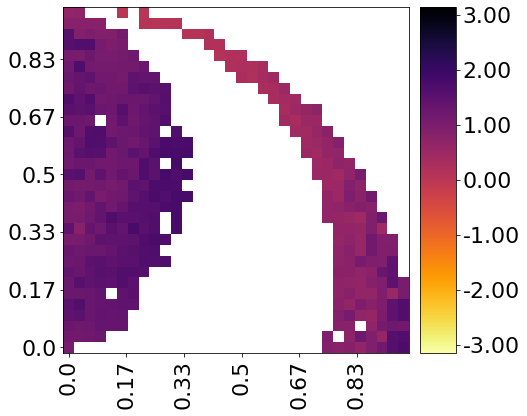

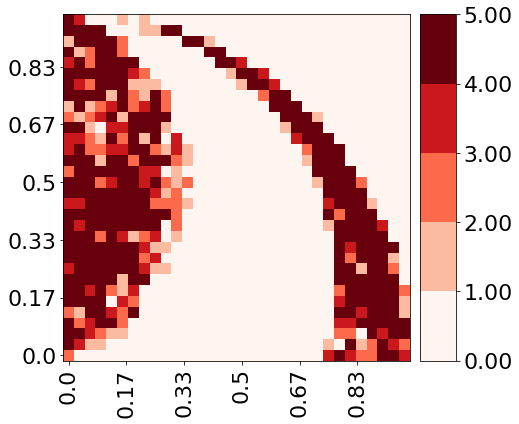

In [74]:
from utils.utils_12.exercise_custom_eval_fn import main
import math
"""
-------------------------------------------------------------------------
Edit this part to do the exercises
"""

# TODO: change these parameters
NO_BINS=32          # default 32
MAX_ITEMS_BIN=5     # default 1
BUDGET=10000        # default 10000
BATCH_SIZE=500      # default 500
PROBLEM_DIM=3       # default 3

# TODO: try to define a different objective function (score) and/or features (fit0, fit1)
def eval_fn(ind):
    """An example evaluation function. It takes an individual as input, and returns the pair ``(fitness, features)``, where ``fitness`` and ``features`` are sequences of scores."""
    normalization = sum((x for x in ind))
    k = 10.
    
    #objective function
    score = 1. - sum(( math.cos(k * ind[i]) * math.exp(-(ind[i]*ind[i])/2.) for i in range(len(ind)))) / float(len(ind))
    
    #features
    fit0 = sum((x * math.sin(abs(x) * 2. * math.pi) for x in ind)) / normalization
    fit1 = sum((x * math.cos(abs(x) * 2. * math.pi) for x in ind)) / normalization
    features = (fit0, fit1)
    
    
    return (score,), features

"""
-------------------------------------------------------------------------
"""
main(eval_fn, NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [75]:
# You may want to import your own packages if the pickle file contains custom objects
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex2\T1_32_5\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES: ",grid.best.features)

GRID BEST:  Individual([0.034136316996679184, 0.004147768236488991, 0.0021406130735766027])
GRID BEST FITNESS:  (0.019783246109517094,)
GRID BEST FEATURES:  (0.18312038226722893, 0.9806109743791199)


### Trial 2, NO_BINS=32, MAX_ITEMS_BIN=1

Seed: 884586


alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed


RandomSearchMutPolyBounded-2010996251376     0         16/1024   500       20             [0.2342]  [0.1338]  [0.0788]  [0.5321]  [0.4230,0.4242]     [0.8876,0.9977]     7.40      3.06   


RandomSearchMutPolyBounded-2010996251376     1         34/1024   500       49             [0.2136]  [0.1587]  [0.0468]  [0.6439]  [0.3548,0.3558]     [0.9086,0.9927]     15.84     2.57   


RandomSearchMutPolyBounded-2010996251376     2         43/1024   500       34             [0.2359]  [0.1618]  [0.0468]  [0.5763]  [0.3720,0.3729]     [0.9086,0.9927]     19.89     2.54   


RandomSearchMutPolyBounded-2010996251376     3         46/1024   500       28             [0.2397]  [0.177]   [0.0465]  [0.7027]  [0.3083,0.3088]     [0.9086,0.9927]     21.25     2.47   


RandomSearchMutPolyBounded-2010996251376     4         48/1024   500       25             [0.2344]  [0.1705]  [0.0465]  [0.7027]  [0.3083,0.3088]     [0.9086,0.9927]     22.21     2.44   


RandomSearchMutPolyBounded-2010996251376     5         51/1024   500       29             [0.2485]  [0.1916]  [0.0443]  [0.8317]  [0.1537,0.1537]     [0.9141,0.9991]     23.48     2.74   


RandomSearchMutPolyBounded-2010996251376     6         57/1024   500       23             [0.2903]  [0.2369]  [0.0443]  [0.8865]  [0.0783,0.0783]     [0.9141,0.9991]     25.87     2.48   


RandomSearchMutPolyBounded-2010996251376     7         59/1024   500       15             [0.302]   [0.2451]  [0.0443]  [0.9171]  [0.0585,0.0585]     [0.9141,0.9991]     26.66     2.52   


RandomSearchMutPolyBounded-2010996251376     8         59/1024   500       20             [0.2892]  [0.2403]  [0.0443]  [0.9171]  [0.0585,0.0585]     [0.9141,0.9991]     26.78     2.35   


RandomSearchMutPolyBounded-2010996251376     9         60/1024   500       14             [0.2939]  [0.2421]  [0.0443]  [0.9171]  [0.0585,0.0585]     [0.9141,0.9991]     27.19     2.48   


RandomSearchMutPolyBounded-2010996251376     10        60/1024   500       15             [0.2929]  [0.241]   [0.0443]  [0.9171]  [0.0585,0.0585]     [0.9123,0.9957]     27.20     2.27   


RandomSearchMutPolyBounded-2010996251376     11        60/1024   500       10             [0.2907]  [0.2396]  [0.0443]  [0.9171]  [0.0585,0.0585]     [0.9123,0.9957]     27.22     2.31   


RandomSearchMutPolyBounded-2010996251376     12        61/1024   500       11             [0.2864]  [0.2336]  [0.0443]  [0.9171]  [0.0585,0.0585]     [0.9123,0.9957]     27.72     2.32   


RandomSearchMutPolyBounded-2010996251376     13        61/1024   500       8              [0.2849]  [0.2331]  [0.0443]  [0.9171]  [0.0585,0.0585]     [0.9123,0.9957]     27.73     2.37   


RandomSearchMutPolyBounded-2010996251376     14        61/1024   500       4              [0.2847]  [0.2331]  [0.0443]  [0.9171]  [0.0585,0.0585]     [0.9123,0.9957]     27.74     2.62   


RandomSearchMutPolyBounded-2010996251376     15        61/1024   500       6              [0.2846]  [0.2331]  [0.0441]  [0.9171]  [0.0585,0.0585]     [0.9137,0.9981]     27.74     2.24   


RandomSearchMutPolyBounded-2010996251376     16        61/1024   500       8              [0.2829]  [0.2316]  [0.0441]  [0.9171]  [0.0585,0.0585]     [0.9137,0.9981]     27.75     2.36   


RandomSearchMutPolyBounded-2010996251376     17        61/1024   500       5              [0.2822]  [0.2315]  [0.0441]  [0.9171]  [0.0585,0.0585]     [0.9137,0.9981]     27.76     2.31   


RandomSearchMutPolyBounded-2010996251376     18        61/1024   500       5              [0.282]   [0.2314]  [0.0441]  [0.9171]  [0.0585,0.0585]     [0.9137,0.9981]     27.76     2.26   


RandomSearchMutPolyBounded-2010996251376     19        61/1024   500       11             [0.28]    [0.2277]  [0.0441]  [0.9171]  [0.0585,0.0585]     [0.9137,0.9981]     27.78     1.81   


Finished optimisation using algorithm 'RandomSearchMutPolyBounded-2010996251376'. Total elapsed: 48.878750500000024.



Summary RandomSearchMutPolyBounded:
  batch_size: 500
  budget: 10000
  container:  Summary Grid:
    activity_per_bin: [[0. 0. 0. ... 0. 0. 0.]  [0. 1. 0. ... 0. 0. 0.]  [0. 0. 3. ... 0. 0. 0.]  ...  [0. 0. 0. ... 0. 0. 4.]  [0. 0. 0. ... 0. 0. 0.]  [0. 0. 0. ... 0. 0. 0.]]
    best: Individual([0.2542338357520043, 0.2510147993525015, 0.23497317229536752])
    best_features: (0.9137152778159172, 0.9980826913066182)
    best_fitness: (0.04407119368083279,)
    best_index: (29, 31)
    capacity: 1024
    depot: None
    discard_random_on_bin_overload: False
    features: {(0, 0): [], (0, 1): [], (0, 2): [], (0, 3): [], (0, 4): [], (0, 5): [], (0, 6): [], (0, 7): [], (0, 8): [], (0, 9): [], (0, 10): [], (0, 11): [], (0, 12): [], (0, 13): [], (0, 14): [], (0, 15): [], (0, 16): [], (0, 17): [], (0, 18): [], (0, 19) ...
    features_domain: ((0.0, 1.0), (0.0, 1.0))
    features_extrema: ((0.05845527430309011, 0.9137152778159172), (0.058455368474036304, 0.9980826913066182))
    filled_bins:

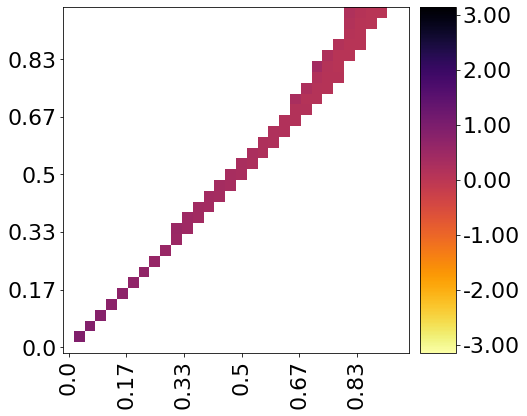

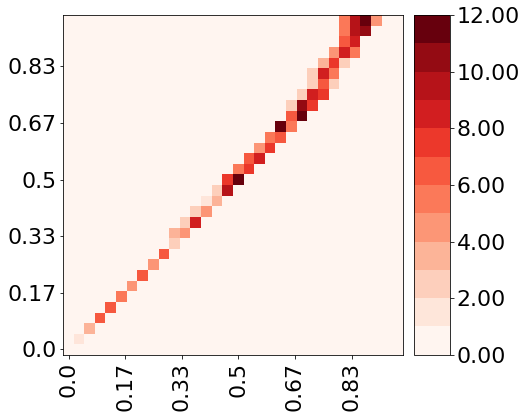

In [76]:
from utils.utils_12.exercise_custom_eval_fn import main
import math
"""
-------------------------------------------------------------------------
Edit this part to do the exercises
"""

# TODO: change these parameters
NO_BINS=32          # default 32
MAX_ITEMS_BIN=1     # default 1
BUDGET=10000        # default 10000
BATCH_SIZE=500      # default 500
PROBLEM_DIM=3       # default 3

# TODO: try to define a different objective function (score) and/or features (fit0, fit1)
def eval_fn(ind):
    """An example evaluation function. It takes an individual as input, and returns the pair ``(fitness, features)``, where ``fitness`` and ``features`` are sequences of scores."""
    normalization = sum((x for x in ind))
    k = 10.
    
    #objective function
    score = 1. - sum(( math.tanh(k * ind[i]) * math.exp(-(ind[i]*ind[i])/2.) for i in range(len(ind)))) / float(len(ind))
    
    #features
    fit0 = sum((x * math.tanh(abs(x) * 2. * math.pi) for x in ind)) / normalization
    fit1 = sum((x * math.atan(abs(x) * 2. * math.pi) for x in ind)) / normalization
    features = (fit0, fit1)
    
    
    return (score,), features

"""
-------------------------------------------------------------------------
"""
main(eval_fn, NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [77]:
# You may want to import your own packages if the pickle file contains custom objects
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex2\T2_32_1\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES: ",grid.best.features)

GRID BEST:  Individual([0.2542338357520043, 0.2510147993525015, 0.23497317229536752])
GRID BEST FITNESS:  (0.04407119368083279,)
GRID BEST FEATURES:  (0.9137152778159172, 0.9980826913066182)


### Trial 2, NO_BINS=32, MAX_ITEMS_BIN=5

Seed: 243315


alg_name                                 iteration cont_size evals     nb_updated     avg       std       min       max       ft_min              ft_max              qd_score  elapsed


RandomSearchMutPolyBounded-2010995494480     0         13/5120   500       13             [0.2344]  [0.1617]  [0.0541]  [0.6172]  [0.7027,0.7445]     [0.9062,0.9964]     4.65      3.02   


RandomSearchMutPolyBounded-2010995494480     1         79/5120   500       120            [0.2456]  [0.1684]  [0.0534]  [0.6775]  [0.2842,0.2844]     [0.9062,0.9964]     13.07     2.55   


RandomSearchMutPolyBounded-2010995494480     2         105/5120  500       49             [0.2543]  [0.1655]  [0.0471]  [0.6775]  [0.2842,0.2844]     [0.9110,0.9973]     15.50     2.24   


RandomSearchMutPolyBounded-2010995494480     3         134/5120  500       57             [0.2531]  [0.1589]  [0.0471]  [0.6775]  [0.2842,0.2844]     [0.9110,0.9973]     16.43     2.34   


RandomSearchMutPolyBounded-2010995494480     4         160/5120  500       47             [0.2733]  [0.1705]  [0.0471]  [0.6775]  [0.2472,0.2473]     [0.9110,0.9999]     19.49     2.19   


RandomSearchMutPolyBounded-2010995494480     5         182/5120  500       45             [0.2942]  [0.1772]  [0.0471]  [0.7176]  [0.1937,0.1937]     [0.9110,0.9999]     21.58     2.27   


RandomSearchMutPolyBounded-2010995494480     6         199/5120  500       35             [0.3117]  [0.1895]  [0.0471]  [0.8077]  [0.1904,0.1905]     [0.9110,0.9999]     22.03     2.23   


RandomSearchMutPolyBounded-2010995494480     7         211/5120  500       24             [0.3193]  [0.1919]  [0.0471]  [0.8077]  [0.1904,0.1905]     [0.9110,0.9999]     23.00     2.24   


RandomSearchMutPolyBounded-2010995494480     8         225/5120  500       26             [0.3383]  [0.2022]  [0.0471]  [0.8442]  [0.1650,0.1650]     [0.9110,0.9999]     23.38     2.25   


RandomSearchMutPolyBounded-2010995494480     9         231/5120  500       15             [0.3451]  [0.2052]  [0.0471]  [0.8442]  [0.1583,0.1583]     [0.9110,0.9999]     23.39     2.33   


RandomSearchMutPolyBounded-2010995494480     10        236/5120  500       11             [0.3473]  [0.2057]  [0.0471]  [0.8442]  [0.1583,0.1583]     [0.9110,0.9999]     23.81     2.28   


RandomSearchMutPolyBounded-2010995494480     11        238/5120  500       5              [0.3488]  [0.2056]  [0.0471]  [0.8442]  [0.1583,0.1583]     [0.9110,0.9999]     23.82     2.17   


RandomSearchMutPolyBounded-2010995494480     12        242/5120  500       7              [0.3469]  [0.2085]  [0.0449]  [0.8442]  [0.1583,0.1583]     [0.9116,0.9999]     23.82     2.24   


RandomSearchMutPolyBounded-2010995494480     13        249/5120  500       9              [0.3522]  [0.2132]  [0.0449]  [0.9254]  [0.0548,0.0548]     [0.9116,0.9999]     25.81     2.48   


RandomSearchMutPolyBounded-2010995494480     14        255/5120  500       11             [0.3586]  [0.2201]  [0.0449]  [0.9254]  [0.0548,0.0548]     [0.9116,0.9999]     26.92     2.80   


RandomSearchMutPolyBounded-2010995494480     15        260/5120  500       14             [0.3629]  [0.2215]  [0.0449]  [0.9254]  [0.0548,0.0548]     [0.9116,0.9999]     26.92     2.88   


RandomSearchMutPolyBounded-2010995494480     16        263/5120  500       14             [0.3666]  [0.2242]  [0.0449]  [0.9254]  [0.0548,0.0548]     [0.9116,0.9999]     26.94     2.54   


RandomSearchMutPolyBounded-2010995494480     17        271/5120  500       17             [0.3795]  [0.2352]  [0.0449]  [0.9612]  [0.0253,0.0253]     [0.9116,0.9999]     27.29     2.29   


RandomSearchMutPolyBounded-2010995494480     18        275/5120  500       11             [0.3831]  [0.236]   [0.0449]  [0.9612]  [0.0253,0.0253]     [0.9116,0.9999]     27.33     2.22   


RandomSearchMutPolyBounded-2010995494480     19        278/5120  500       10             [0.3849]  [0.2355]  [0.0449]  [0.9612]  [0.0253,0.0253]     [0.9116,0.9999]     27.36     1.76   


Finished optimisation using algorithm 'RandomSearchMutPolyBounded-2010995494480'. Total elapsed: 47.94620390000273.



Summary RandomSearchMutPolyBounded:
  batch_size: 500
  budget: 10000
  container:  Summary Grid:
    activity_per_bin: [[2. 0. 0. ... 0. 0. 0.]  [0. 2. 0. ... 0. 0. 0.]  [0. 0. 1. ... 0. 0. 0.]  ...  [0. 0. 0. ... 0. 0. 5.]  [0. 0. 0. ... 0. 0. 0.]  [0. 0. 0. ... 0. 0. 0.]]
    best: Individual([0.2479616855653063, 0.22284817953545144, 0.2644062744433875])
    best_features: (0.9115941391713834, 0.9955014560502801)
    best_fitness: (0.04491369360696529,)
    best_index: (29, 31)
    capacity: 5120
    depot: None
    discard_random_on_bin_overload: False
    features: {(0, 0): [Features([0.02713352700596691, 0.027133528523334133]), Features([0.025314633014083997, 0.025314633984547363])], (0, 1): [], (0, 2): [], (0, 3): [], (0, 4): [], (0, 5): [], (0, 6): [], (0, 7): [], (0, 8): [], (0, 9): [], (0, 10): [], (0 ...
    features_domain: ((0.0, 1.0), (0.0, 1.0))
    features_extrema: ((0.025314633014083997, 0.9115941391713834), (0.025314633984547363, 0.999921480001023))
    filled_bins:

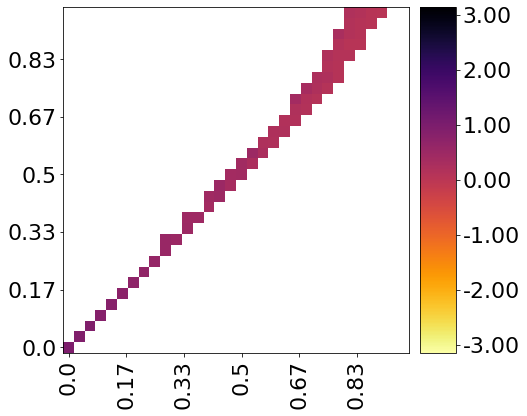

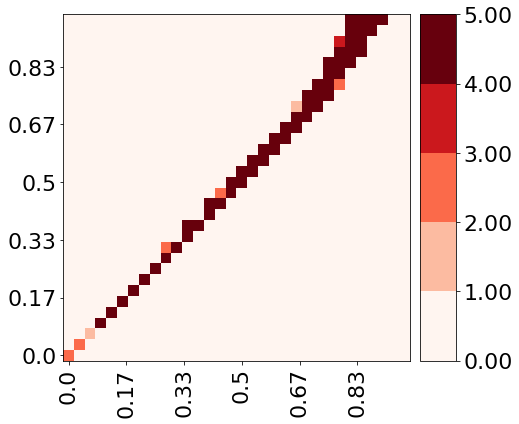

In [78]:
from utils.utils_12.exercise_custom_eval_fn import main
import math
"""
-------------------------------------------------------------------------
Edit this part to do the exercises
"""

# TODO: change these parameters
NO_BINS=32          # default 32
MAX_ITEMS_BIN= 5    # default 1
BUDGET=10000        # default 10000
BATCH_SIZE=500      # default 500
PROBLEM_DIM=3       # default 3

# TODO: try to define a different objective function (score) and/or features (fit0, fit1)
def eval_fn(ind):
    """An example evaluation function. It takes an individual as input, and returns the pair ``(fitness, features)``, where ``fitness`` and ``features`` are sequences of scores."""
    normalization = sum((x for x in ind))
    k = 10.
    
    #objective function
    score = 1. - sum(( math.tanh(k * ind[i]) * math.exp(-(ind[i]*ind[i])/2.) for i in range(len(ind)))) / float(len(ind))
    
    #features
    fit0 = sum((x * math.tanh(abs(x) * 2. * math.pi) for x in ind)) / normalization
    fit1 = sum((x * math.atan(abs(x) * 2. * math.pi) for x in ind)) / normalization
    features = (fit0, fit1)
    
    
    return (score,), features

"""
-------------------------------------------------------------------------
"""
main(eval_fn, NO_BINS, MAX_ITEMS_BIN, BUDGET, BATCH_SIZE, PROBLEM_DIM)

In [79]:
# You may want to import your own packages if the pickle file contains custom objects
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex2\T2_32_5\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES: ",grid.best.features)

GRID BEST:  Individual([0.2479616855653063, 0.22284817953545144, 0.2644062744433875])
GRID BEST FITNESS:  (0.04491369360696529,)
GRID BEST FEATURES:  (0.9115941391713834, 0.9955014560502801)


# Exercise 3
In this exercise we will use MAP-Elites in combination with Genetic Programming (as implemented in `deap`, see the exercises from the previous lab) to solve a **symbolic regression problem.** The problem is exactly the same as the one seen in the first exercise of the previous lab on Genetic Programming (in which the goal was to fit a polynomial function), apart from the fact that in this case we will investigate how **MAP-Elites illuminates a feature spaces characterized by the size of the tree (`the number of nodes`) and its `depth`.** Similarly to the exercise seen in the lab on GP, **the fitness in this case is the mean square error calculated on the training points (to be minimized).** **As both features can be seen as proxy for the complexity of the evolved trees, this experiments can give insights on how the performance of the trees depends on their complexity.**

To start the experiments, run the next cell. Similarly to the previous exercises, at the end of the run the script will generate some plots (in this case only `activityGrid.pdf` and `performancesGrid.pdf`) as well as the pickle file containing the raw results. Also, note that the structure of the best tree is displayed on the terminal (in Reverse Polish notation).
Note, in this case, the file will be saved in the `results/ex3/seed` folder.

 - **Is the algorithm able to approximate the given polynomial?** If not, try to change some parameters of the algorithm and see if you can improve the results. Note that in this case there is an additional parameter (`INIT_BATCH_SIZE`), that is the size of the first batch (used to initialize the map). This is usually set to be bigger than the batch size at the subsequent iterations of the algorithm.
 - **Try to change the generator function (e.g., to include trigonometric functions) defined in the method `generatorFunction`. Is the algorithm able to approximate more complicated generator functions? Which parameters can you change to improve the results?**
 - **What kind of illumination pattern do you observe in the various trials? Do you see any trend/correlation between performance and features (i.e., the size and depth of the tree)?**

### Trial 1, function $x^{4} + x^{3} + x^{2} + x$

EphemeralConstant is already defined, if you changed it restart the kernel
Seed: 0
iteration	containerSize	evals	nbUpdated	avg        	std         	min         	max         	elapsed
0        	5/100        	3000 	14       	[0.9359397]	[0.99482482]	[0.18811696]	[2.88316088]	7.34779
1        	13/100       	500  	24       	[0.51401969]	[0.70787646]	[0.10148571]	[2.88316088]	1.20884
2        	26/100       	500  	24       	[0.56779266]	[0.6468044] 	[0.02537143]	[2.88316088]	1.52303
3        	34/100       	500  	34       	[0.3849195] 	[0.54187907]	[0.02537143]	[2.88316088]	1.9571 
4        	40/100       	500  	16       	[0.41299949]	[0.62495842]	[0.02537143]	[2.88316088]	2.15687
5        	43/100       	500  	15       	[0.3229379] 	[0.51467581]	[0.02537143]	[2.88316088]	2.02553
6        	46/100       	500  	11       	[0.33331035]	[0.54087575]	[0.02537143]	[2.88316088]	1.99346
7        	47/100       	500  	6        	[0.36678658]	[0.6368374] 	[0.02537143]	[2.88316088]	2.07367
8        	48/100   

  solutions: {(0, 0): [[<deap.gp.Primitive object at 0x000001D438A7D400>, <deap.gp.Terminal object at 0x000001D43F33CB80>]], (0, 1): [], (0, 2): [], (0, 3): [], (0, 4): [], (0, 5): [], (0, 6): [], (0, 7): [], (0, 8): [], (0, 9): [], (1, 0): [[<deap.gp.Primit ...
Smallest best: add(mul(neg(neg(add(mul(x, sub(mul(x, x), neg(x))), x))), x), x)
Smallest best fitness: (1.6926998281219416e-32,)
Smallest best features: [16, 8]

A plot of the performance grid was saved in 'C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex3\performancesGrid.pdf'.

A plot of the activity grid was saved in 'C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex3\activityGrid.pdf'.
All results are available in the 'final.p' pickle file.


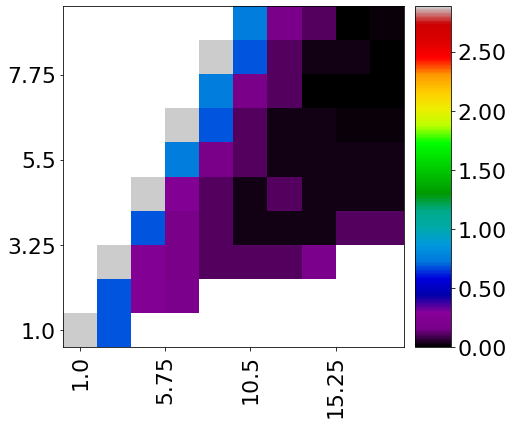

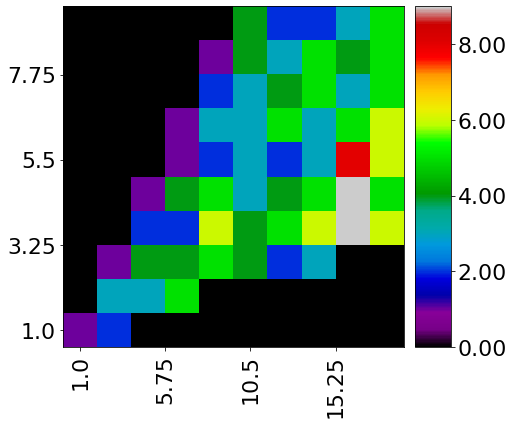

In [83]:
#!/usr/bin/env python3
#    This file is part of qdpy.
#
#    qdpy is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    qdpy is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with qdpy. If not, see <http://www.gnu.org/licenses/>.


"""A simple example of MAP-elites to illuminate a fitness function
based on a symbolic regression problem. The illumination process
is ran with 2 features, i.e., the length of the tree (no. of nodes)
and its height (depth)."""

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

from qdpy.algorithms.deap import *
from qdpy.containers import *
from qdpy.benchmarks import *
from qdpy.plots import *
from qdpy.base import *

from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from deap import gp
import operator

import os
import numpy as np
import random
import warnings
import scipy

import warnings
warnings.filterwarnings("ignore")

"""
-------------------------------------------------------------------------
Edit this part to do the exercises
"""

MAX_TREE_SIZE = 20              # default 20
MAX_ITEMS_BIN=1                 # default 1
INIT_BATCH_SIZE=3000            # default 3000
BATCH_SIZE=500                  # default 500

GP_NGEN = 50                    # number of generations for GP
GP_CXPB, GP_MUTPB = 0.9, 0.05    # crossover and mutation probability for GP
seed = 0
parallelismType = "multithreading"  # type of parellism select one of this multiprocessing, concurrent, multithreading, scoop
# TODO: try to change the expression e.g. to include trigonometric functions

def generatorFunction(x):
    #return math.sin(x)+math.cos(x)
    #return math.sin(x)*x**2
    #return math.sin(x)+5*x**2
    return x**4 + x**3 + x**2 + x

"""
-------------------------------------------------------------------------
"""

# Create fitness classes (must NOT be initialised in __main__ if you want to use scoop)
fitness_weight = -1.0
creator.create("FitnessMin", base.Fitness, weights=(fitness_weight,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin, features=list)

def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    #print(individual)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            # Compute tested function
            func_vals = np.array([func(x) for x in points])
            # Evaluate the mean squared error between the expression
            # and the target function
            sqerrors = (func_vals - ref_vals) ** 2.
            fitness = [np.real(np.mean(sqerrors))]

        except Exception:
            fitness = [100.]

    length = len(individual)
    height = individual.height
    features = [length, height]
    return [fitness, features]

# Compute reference function and stats
points = np.array(np.linspace(-1., 1., 1000), dtype=float)
dpoints = np.diff(points)
ref_vals = np.array([generatorFunction(x) for x in points])

# Create primitives
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(operator.pow, 2)
#pset.addPrimitive(math.cos, 1) # TODO: uncomment this primitive if needed
#pset.addPrimitive(math.sin, 1) # TODO: uncomment this primitive if needed
try:
    pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
except:
    print("EphemeralConstant is already defined, if you changed it restart the kernel")
#pset.addEphemeralConstant("rand101", lambda: random.randint(-4.,4.))
pset.renameArguments(ARG0='x')

# Create Toolbox
max_size = MAX_TREE_SIZE
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2) #NOTE: gen half/half initialization
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalSymbReg, points=points)
toolbox.register("select", tools.selRandom) # NOTE: in MAP-Elites, random selection on a grid container
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=max_size))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=max_size))

# Algorithm parameters
nb_bins = [max_size // 2, 10]              # The number of bins per feature
features_domain = [(1, max_size), (1, 10)] # The domain (min/max values) of the features
fitness_domain = [(0., np.inf)]            # The domain (min/max values) of the fitness
init_batch_size = INIT_BATCH_SIZE          # The number of evaluations of the initial batch ('batch' = population)
batch_size = BATCH_SIZE                    # The number of evaluations in each subsequent batch
nb_iterations = GP_NGEN                    # The number of iterations (i.e. times where a new batch is evaluated)
cxpb = GP_CXPB                             # The probability of mutating each value of a genome
mutation_pb = GP_MUTPB                     # The probability of mutating each value of a genome
max_items_per_bin = MAX_ITEMS_BIN          # The number of items in each bin of the grid
verbose = True                             
show_warnings = True                       # Display warning and error messages. Set to True if you want to check if some individuals were out-of-bounds
log_base_path = "./results/ex3"
os.makedirs(log_base_path, exist_ok=True)
# Update and print seed
np.random.seed(seed)
random.seed(seed)
print("Seed: %i" % seed)

# Create a dict storing all relevant infos
results_infos = {}
results_infos['features_domain'] = features_domain
results_infos['fitness_domain'] = fitness_domain
results_infos['nb_bins'] = nb_bins
results_infos['init_batch_size'] = init_batch_size
results_infos['nb_iterations'] = nb_iterations
results_infos['batch_size'] = batch_size

# Create container
grid = Grid(shape=nb_bins, max_items_per_bin=max_items_per_bin, fitness_domain=fitness_domain, features_domain=features_domain, storage_type=list)

with ParallelismManager(parallelismType, toolbox=toolbox) as pMgr:
    # Create a QD algorithm
    algo = DEAPQDAlgorithm(pMgr.toolbox, grid, init_batch_size = init_batch_size, batch_size = batch_size, niter = nb_iterations,
            cxpb = cxpb, mutpb = mutation_pb,
            verbose = verbose, show_warnings = show_warnings, results_infos = results_infos, log_base_path = log_base_path)
    # Run the illumination process !
    algo.run()

# Print results info
print(f"Total elapsed: {algo.total_elapsed}\n")
print(grid.summary())
#print("Best ever fitness: ", container.best_fitness)
#print("Best ever ind: ", container.best)
#print("%s filled bins in the grid" % (grid.size_str()))
#print("Solutions found for bins: ", grid.solutions)
#print("Performances grid: ", grid.fitness)
#print("Features grid: ", grid.features)

# Search for the smallest best in the grid:
smallest_best = grid.best
smallest_best_fitness = grid.best_fitness
smallest_best_length = grid.best_features[0]
interval_match = 1e-10
for ind in grid:
    if abs(ind.fitness.values[0] - smallest_best_fitness.values[0]) < interval_match:
        if ind.features[0] < smallest_best_length:
            smallest_best_length = ind.features[0]
            smallest_best = ind
print("Smallest best:", smallest_best)
print("Smallest best fitness:", smallest_best.fitness)
print("Smallest best features:", smallest_best.features)

# It is possible to access the results (including the genomes of the solutions, their performance, etc)
# stored in the pickle file by using the following code:
#----8<----8<----8<----8<----8<----8<
#from deap import base, creator, gp
#import pickle
#fitness_weight = -1.0
#creator.create("FitnessMin", base.Fitness, weights=(fitness_weight,))
#creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin, features=list)
#pset = gp.PrimitiveSet("MAIN", 1)
#pset.addEphemeralConstant("rand101", lambda: random.randint(-4.,4.))
#with open("final.p", "rb") as f:
#    data = pickle.load(f)
#print(data)
#----8<----8<----8<----8<----8<----8<
# --> data is a dictionary containing the results.

# Create plots
plot_path = os.path.join(log_base_path, "performancesGrid.pdf")
plotGridSubplots(grid.quality_array[... ,0], plot_path, plt.get_cmap("nipy_spectral"), grid.features_domain, grid.fitness_extrema[0], nbTicks=None)
print("\nA plot of the performance grid was saved in '%s'." % os.path.abspath(plot_path))

plot_path = os.path.join(log_base_path, "activityGrid.pdf")
plotGridSubplots(grid.activity_per_bin, plot_path, plt.get_cmap("nipy_spectral"), grid.features_domain, [0, np.max(grid.activity_per_bin)], nbTicks=None)
print("\nA plot of the activity grid was saved in '%s'." % os.path.abspath(plot_path))

print("All results are available in the '%s' pickle file." % algo.final_filename)

In [82]:
# You may want to import your own packages if the pickle file contains custom objects
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex3\final.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES (number of nodes, depth): ",grid.best.features)

GRID BEST:  mul(add(1, x), add(x, mul(x, sub(mul(x, x), sub(x, x)))))
GRID BEST FITNESS:  (1.1421152201233436e-32,)
GRID BEST FEATURES (number of nodes, depth):  [15, 5]


### Trial 2,  function $\sin(x)+ \cos(x)$

EphemeralConstant is already defined, if you changed it restart the kernel
Seed: 0
iteration	containerSize	evals	nbUpdated	avg         	std         	min 	max         	elapsed
0        	5/100        	3000 	16       	[0.17858502]	[0.14500142]	[0.]	[0.31766093]	8.09571
1        	14/100       	500  	22       	[0.15947232]	[0.14275621]	[0.]	[0.31766093]	1.77893
2        	28/100       	500  	26       	[0.17523509]	[0.15380725]	[0.]	[0.42586628]	1.34069
3        	38/100       	500  	34       	[0.11580095]	[0.12999839]	[0.]	[0.31766093]	1.95832
4        	42/100       	500  	24       	[0.0784844] 	[0.12175522]	[0.]	[0.31766093]	2.09407
5        	46/100       	500  	20       	[0.05979538]	[0.11233135]	[0.]	[0.31766093]	1.93545
6        	52/100       	500  	17       	[0.05148877]	[0.10311947]	[0.]	[0.3215342] 	1.98552
7        	54/100       	500  	11       	[0.04783939]	[0.10183422]	[0.]	[0.3215342] 	1.99386
8        	57/100       	500  	17       	[0.04891668]	[0.10303019]	[0.]	[0.3215342] 	2.170

  solutions: {(0, 0): [[<deap.gp.Primitive object at 0x000001D438A86040>, <deap.gp.Terminal object at 0x000001D43F21AE40>]], (0, 1): [], (0, 2): [], (0, 3): [], (0, 4): [], (0, 5): [], (0, 6): [], (0, 7): [], (0, 8): [], (0, 9): [], (1, 0): [[<deap.gp.Primit ...
Smallest best: add(cos(x), sin(x))
Smallest best fitness: (0.0,)
Smallest best features: [5, 2]

A plot of the performance grid was saved in 'C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex3\performancesGrid.pdf'.

A plot of the activity grid was saved in 'C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex3\activityGrid.pdf'.
All results are available in the 'final.p' pickle file.


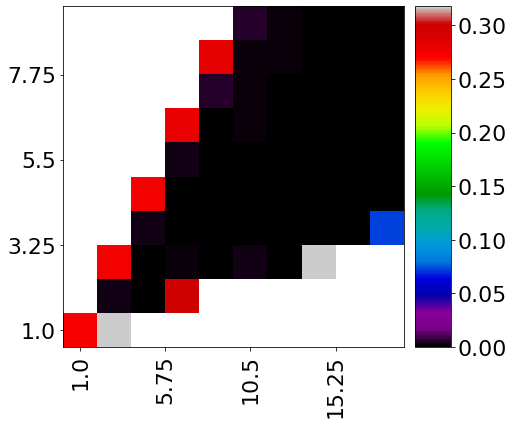

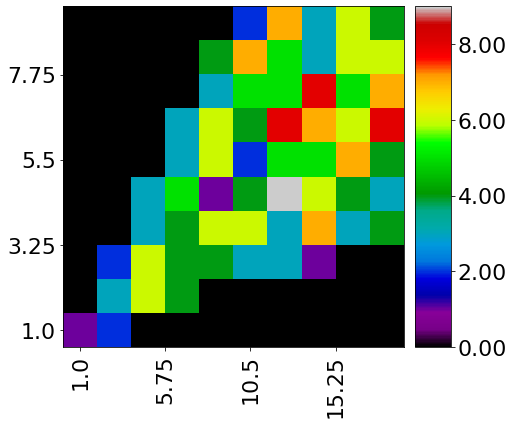

In [85]:
#!/usr/bin/env python3
#    This file is part of qdpy.
#
#    qdpy is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    qdpy is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with qdpy. If not, see <http://www.gnu.org/licenses/>.


"""A simple example of MAP-elites to illuminate a fitness function
based on a symbolic regression problem. The illumination process
is ran with 2 features, i.e., the length of the tree (no. of nodes)
and its height (depth)."""

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

from qdpy.algorithms.deap import *
from qdpy.containers import *
from qdpy.benchmarks import *
from qdpy.plots import *
from qdpy.base import *

from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from deap import gp
import operator

import os
import numpy as np
import random
import warnings
import scipy

import warnings
warnings.filterwarnings("ignore")

"""
-------------------------------------------------------------------------
Edit this part to do the exercises
"""

MAX_TREE_SIZE = 20              # default 20
MAX_ITEMS_BIN=1                 # default 1
INIT_BATCH_SIZE=3000            # default 3000
BATCH_SIZE=500                  # default 500

GP_NGEN = 50                    # number of generations for GP
GP_CXPB, GP_MUTPB = 0.9, 0.05    # crossover and mutation probability for GP
seed = 0
parallelismType = "multithreading"  # type of parellism select one of this multiprocessing, concurrent, multithreading, scoop
# TODO: try to change the expression e.g. to include trigonometric functions

def generatorFunction(x):
    return math.sin(x)+math.cos(x)
    #return math.sin(x)*x**2
    #return math.sin(x)+5*x**2
    #return x**4 + x**3 + x**2 + x

"""
-------------------------------------------------------------------------
"""

# Create fitness classes (must NOT be initialised in __main__ if you want to use scoop)
fitness_weight = -1.0
creator.create("FitnessMin", base.Fitness, weights=(fitness_weight,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin, features=list)

def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    #print(individual)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            # Compute tested function
            func_vals = np.array([func(x) for x in points])
            # Evaluate the mean squared error between the expression
            # and the target function
            sqerrors = (func_vals - ref_vals) ** 2.
            fitness = [np.real(np.mean(sqerrors))]

        except Exception:
            fitness = [100.]

    length = len(individual)
    height = individual.height
    features = [length, height]
    return [fitness, features]

# Compute reference function and stats
points = np.array(np.linspace(-1., 1., 1000), dtype=float)
dpoints = np.diff(points)
ref_vals = np.array([generatorFunction(x) for x in points])

# Create primitives
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(operator.pow, 2)
pset.addPrimitive(math.cos, 1) # TODO: uncomment this primitive if needed
pset.addPrimitive(math.sin, 1) # TODO: uncomment this primitive if needed
try:
    pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
except:
    print("EphemeralConstant is already defined, if you changed it restart the kernel")
#pset.addEphemeralConstant("rand101", lambda: random.randint(-4.,4.))
pset.renameArguments(ARG0='x')

# Create Toolbox
max_size = MAX_TREE_SIZE
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2) #NOTE: gen half/half initialization
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalSymbReg, points=points)
toolbox.register("select", tools.selRandom) # NOTE: in MAP-Elites, random selection on a grid container
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=max_size))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=max_size))

# Algorithm parameters
nb_bins = [max_size // 2, 10]              # The number of bins per feature
features_domain = [(1, max_size), (1, 10)] # The domain (min/max values) of the features
fitness_domain = [(0., np.inf)]            # The domain (min/max values) of the fitness
init_batch_size = INIT_BATCH_SIZE          # The number of evaluations of the initial batch ('batch' = population)
batch_size = BATCH_SIZE                    # The number of evaluations in each subsequent batch
nb_iterations = GP_NGEN                    # The number of iterations (i.e. times where a new batch is evaluated)
cxpb = GP_CXPB                             # The probability of mutating each value of a genome
mutation_pb = GP_MUTPB                     # The probability of mutating each value of a genome
max_items_per_bin = MAX_ITEMS_BIN          # The number of items in each bin of the grid
verbose = True                             
show_warnings = True                       # Display warning and error messages. Set to True if you want to check if some individuals were out-of-bounds
log_base_path = "./results/ex3"
os.makedirs(log_base_path, exist_ok=True)
# Update and print seed
np.random.seed(seed)
random.seed(seed)
print("Seed: %i" % seed)

# Create a dict storing all relevant infos
results_infos = {}
results_infos['features_domain'] = features_domain
results_infos['fitness_domain'] = fitness_domain
results_infos['nb_bins'] = nb_bins
results_infos['init_batch_size'] = init_batch_size
results_infos['nb_iterations'] = nb_iterations
results_infos['batch_size'] = batch_size

# Create container
grid = Grid(shape=nb_bins, max_items_per_bin=max_items_per_bin, fitness_domain=fitness_domain, features_domain=features_domain, storage_type=list)

with ParallelismManager(parallelismType, toolbox=toolbox) as pMgr:
    # Create a QD algorithm
    algo = DEAPQDAlgorithm(pMgr.toolbox, grid, init_batch_size = init_batch_size, batch_size = batch_size, niter = nb_iterations,
            cxpb = cxpb, mutpb = mutation_pb,
            verbose = verbose, show_warnings = show_warnings, results_infos = results_infos, log_base_path = log_base_path)
    # Run the illumination process !
    algo.run()

# Print results info
print(f"Total elapsed: {algo.total_elapsed}\n")
print(grid.summary())
#print("Best ever fitness: ", container.best_fitness)
#print("Best ever ind: ", container.best)
#print("%s filled bins in the grid" % (grid.size_str()))
#print("Solutions found for bins: ", grid.solutions)
#print("Performances grid: ", grid.fitness)
#print("Features grid: ", grid.features)

# Search for the smallest best in the grid:
smallest_best = grid.best
smallest_best_fitness = grid.best_fitness
smallest_best_length = grid.best_features[0]
interval_match = 1e-10
for ind in grid:
    if abs(ind.fitness.values[0] - smallest_best_fitness.values[0]) < interval_match:
        if ind.features[0] < smallest_best_length:
            smallest_best_length = ind.features[0]
            smallest_best = ind
print("Smallest best:", smallest_best)
print("Smallest best fitness:", smallest_best.fitness)
print("Smallest best features:", smallest_best.features)

# It is possible to access the results (including the genomes of the solutions, their performance, etc)
# stored in the pickle file by using the following code:
#----8<----8<----8<----8<----8<----8<
#from deap import base, creator, gp
#import pickle
#fitness_weight = -1.0
#creator.create("FitnessMin", base.Fitness, weights=(fitness_weight,))
#creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin, features=list)
#pset = gp.PrimitiveSet("MAIN", 1)
#pset.addEphemeralConstant("rand101", lambda: random.randint(-4.,4.))
#with open("final.p", "rb") as f:
#    data = pickle.load(f)
#print(data)
#----8<----8<----8<----8<----8<----8<
# --> data is a dictionary containing the results.

# Create plots
plot_path = os.path.join(log_base_path, "performancesGrid.pdf")
plotGridSubplots(grid.quality_array[... ,0], plot_path, plt.get_cmap("nipy_spectral"), grid.features_domain, grid.fitness_extrema[0], nbTicks=None)
print("\nA plot of the performance grid was saved in '%s'." % os.path.abspath(plot_path))

plot_path = os.path.join(log_base_path, "activityGrid.pdf")
plotGridSubplots(grid.activity_per_bin, plot_path, plt.get_cmap("nipy_spectral"), grid.features_domain, [0, np.max(grid.activity_per_bin)], nbTicks=None)
print("\nA plot of the activity grid was saved in '%s'." % os.path.abspath(plot_path))

print("All results are available in the '%s' pickle file." % algo.final_filename)

In [86]:
# You may want to import your own packages if the pickle file contains custom objects
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex3\final2.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES (number of nodes, depth): ",grid.best.features)

GRID BEST:  add(cos(x), sin(x))
GRID BEST FITNESS:  (0.0,)
GRID BEST FEATURES (number of nodes, depth):  [5, 2]


###  trial 3, function: $\cos(\exp(x)*10)$

EphemeralConstant is already defined, if you changed it restart the kernel
Seed: 0
iteration	containerSize	evals	nbUpdated	avg         	std         	min         	max         	elapsed
0        	5/100        	3000 	15       	[0.51205608]	[0.11664474]	[0.41915808]	[0.74237501]	6.24427
1        	15/100       	500  	29       	[0.57993221]	[0.23566099]	[0.34508676]	[1.1769358] 	1.43127
2        	28/100       	500  	29       	[0.59593772]	[0.32611959]	[0.28119953]	[1.69314567]	1.64854
3        	37/100       	500  	29       	[0.54592081]	[0.29452768]	[0.15196803]	[1.46994043]	2.45802
4        	43/100       	500  	33       	[0.43641189]	[0.19403697]	[0.11103348]	[1.36063567]	2.26328
5        	48/100       	500  	17       	[0.39340401]	[0.16195189]	[0.03098254]	[0.74588682]	2.1899 
6        	52/100       	500  	23       	[0.37109986]	[0.1779755] 	[0.03098254]	[0.74237501]	2.26396
7        	55/100       	500  	27       	[0.34730155]	[0.20177325]	[0.00884578]	[0.74237501]	2.42477
8        	57/100 

  solutions: {(0, 0): [[<deap.gp.Primitive object at 0x000001D43FA875E0>, <deap.gp.Terminal object at 0x000001D43E32A840>]], (0, 1): [], (0, 2): [], (0, 3): [], (0, 4): [], (0, 5): [], (0, 6): [], (0, 7): [], (0, 8): [], (0, 9): [], (1, 0): [[<deap.gp.Primit ...
Smallest best: pow(sin(add(x, neg(exp(x)))), exp(sin(add(x, x))))
Smallest best fitness: (7.694010206813573e-05,)
Smallest best features: [12, 5]

A plot of the performance grid was saved in 'C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex3\performancesGrid.pdf'.

A plot of the activity grid was saved in 'C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex3\activityGrid.pdf'.
All results are available in the 'final.p' pickle file.


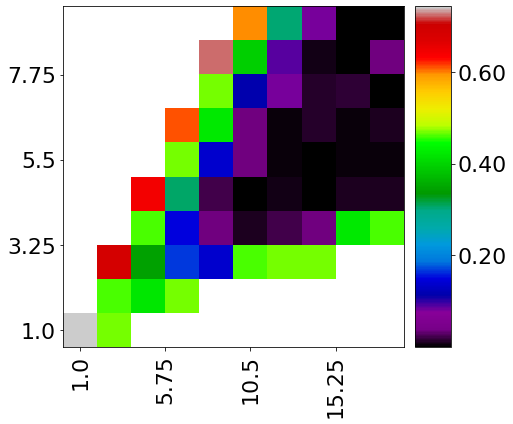

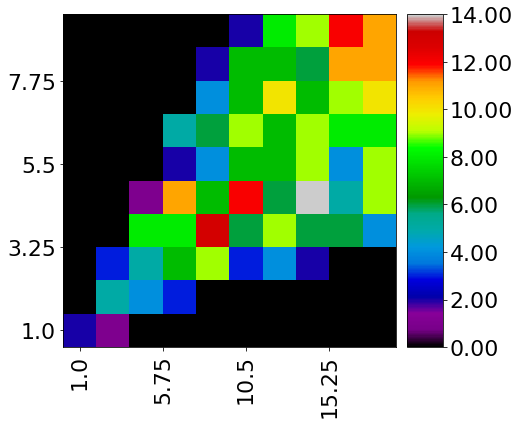

In [88]:
#!/usr/bin/env python3
#    This file is part of qdpy.
#
#    qdpy is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    qdpy is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with qdpy. If not, see <http://www.gnu.org/licenses/>.


"""A simple example of MAP-elites to illuminate a fitness function
based on a symbolic regression problem. The illumination process
is ran with 2 features, i.e., the length of the tree (no. of nodes)
and its height (depth)."""

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

from qdpy.algorithms.deap import *
from qdpy.containers import *
from qdpy.benchmarks import *
from qdpy.plots import *
from qdpy.base import *

from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from deap import gp
import operator

import os
import numpy as np
import random
import warnings
import scipy

import warnings
warnings.filterwarnings("ignore")

"""
-------------------------------------------------------------------------
Edit this part to do the exercises
"""

MAX_TREE_SIZE = 20              # default 20
MAX_ITEMS_BIN=1                 # default 1
INIT_BATCH_SIZE=3000            # default 3000
BATCH_SIZE=500                  # default 500

GP_NGEN = 50                    # number of generations for GP
GP_CXPB, GP_MUTPB = 0.9, 0.05    # crossover and mutation probability for GP
seed = 0
parallelismType = "multithreading"  # type of parellism select one of this multiprocessing, concurrent, multithreading, scoop
# TODO: try to change the expression e.g. to include trigonometric functions

def generatorFunction(x):
    return math.cos(math.exp(x)*10)

"""
-------------------------------------------------------------------------
"""

# Create fitness classes (must NOT be initialised in __main__ if you want to use scoop)
fitness_weight = -1.0
creator.create("FitnessMin", base.Fitness, weights=(fitness_weight,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin, features=list)

def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    #print(individual)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            # Compute tested function
            func_vals = np.array([func(x) for x in points])
            # Evaluate the mean squared error between the expression
            # and the target function
            sqerrors = (func_vals - ref_vals) ** 2.
            fitness = [np.real(np.mean(sqerrors))]

        except Exception:
            fitness = [100.]

    length = len(individual)
    height = individual.height
    features = [length, height]
    return [fitness, features]

# Compute reference function and stats
points = np.array(np.linspace(-1., 1., 1000), dtype=float)
dpoints = np.diff(points)
ref_vals = np.array([generatorFunction(x) for x in points])

# Create primitives
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(operator.pow, 2)
pset.addPrimitive(math.cos, 1) # TODO: uncomment this primitive if needed
pset.addPrimitive(math.sin, 1) # TODO: uncomment this primitive if needed
pset.addPrimitive(math.exp, 1)
try:
    pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
except:
    print("EphemeralConstant is already defined, if you changed it restart the kernel")
#pset.addEphemeralConstant("rand101", lambda: random.randint(-4.,4.))
pset.renameArguments(ARG0='x')

# Create Toolbox
max_size = MAX_TREE_SIZE
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2) #NOTE: gen half/half initialization
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalSymbReg, points=points)
toolbox.register("select", tools.selRandom) # NOTE: in MAP-Elites, random selection on a grid container
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=max_size))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=max_size))

# Algorithm parameters
nb_bins = [max_size // 2, 10]              # The number of bins per feature
features_domain = [(1, max_size), (1, 10)] # The domain (min/max values) of the features
fitness_domain = [(0., np.inf)]            # The domain (min/max values) of the fitness
init_batch_size = 
INIT_BATCH_SIZE          # The number of evaluations of the initial batch ('batch' = population)
batch_size = BATCH_SIZE                    # The number of evaluations in each subsequent batch
nb_iterations = GP_NGEN                    # The number of iterations (i.e. times where a new batch is evaluated)
cxpb = GP_CXPB                             # The probability of mutating each value of a genome
mutation_pb = GP_MUTPB                     # The probability of mutating each value of a genome
max_items_per_bin = MAX_ITEMS_BIN          # The number of items in each bin of the grid
verbose = True                             
show_warnings = True                       # Display warning and error messages. Set to True if you want to check if some individuals were out-of-bounds
log_base_path = "./results/ex3"
os.makedirs(log_base_path, exist_ok=True)
# Update and print seed
np.random.seed(seed)
random.seed(seed)
print("Seed: %i" % seed)

# Create a dict storing all relevant infos
results_infos = {}
results_infos['features_domain'] = features_domain
results_infos['fitness_domain'] = fitness_domain
results_infos['nb_bins'] = nb_bins
results_infos['init_batch_size'] = init_batch_size
results_infos['nb_iterations'] = nb_iterations
results_infos['batch_size'] = batch_size

# Create container
grid = Grid(shape=nb_bins, max_items_per_bin=max_items_per_bin, fitness_domain=fitness_domain, features_domain=features_domain, storage_type=list)

with ParallelismManager(parallelismType, toolbox=toolbox) as pMgr:
    # Create a QD algorithm
    algo = DEAPQDAlgorithm(pMgr.toolbox, grid, init_batch_size = init_batch_size, batch_size = batch_size, niter = nb_iterations,
            cxpb = cxpb, mutpb = mutation_pb,
            verbose = verbose, show_warnings = show_warnings, results_infos = results_infos, log_base_path = log_base_path)
    # Run the illumination process !
    algo.run()

# Print results info
print(f"Total elapsed: {algo.total_elapsed}\n")
print(grid.summary())
#print("Best ever fitness: ", container.best_fitness)
#print("Best ever ind: ", container.best)
#print("%s filled bins in the grid" % (grid.size_str()))
#print("Solutions found for bins: ", grid.solutions)
#print("Performances grid: ", grid.fitness)
#print("Features grid: ", grid.features)

# Search for the smallest best in the grid:
smallest_best = grid.best
smallest_best_fitness = grid.best_fitness
smallest_best_length = grid.best_features[0]
interval_match = 1e-10
for ind in grid:
    if abs(ind.fitness.values[0] - smallest_best_fitness.values[0]) < interval_match:
        if ind.features[0] < smallest_best_length:
            smallest_best_length = ind.features[0]
            smallest_best = ind
print("Smallest best:", smallest_best)
print("Smallest best fitness:", smallest_best.fitness)
print("Smallest best features:", smallest_best.features)

# It is possible to access the results (including the genomes of the solutions, their performance, etc)
# stored in the pickle file by using the following code:
#----8<----8<----8<----8<----8<----8<
#from deap import base, creator, gp
#import pickle
#fitness_weight = -1.0
#creator.create("FitnessMin", base.Fitness, weights=(fitness_weight,))
#creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin, features=list)
#pset = gp.PrimitiveSet("MAIN", 1)
#pset.addEphemeralConstant("rand101", lambda: random.randint(-4.,4.))
#with open("final.p", "rb") as f:
#    data = pickle.load(f)
#print(data)
#----8<----8<----8<----8<----8<----8<
# --> data is a dictionary containing the results.

# Create plots
plot_path = os.path.join(log_base_path, "performancesGrid.pdf")
plotGridSubplots(grid.quality_array[... ,0], plot_path, plt.get_cmap("nipy_spectral"), grid.features_domain, grid.fitness_extrema[0], nbTicks=None)
print("\nA plot of the performance grid was saved in '%s'." % os.path.abspath(plot_path))

plot_path = os.path.join(log_base_path, "activityGrid.pdf")
plotGridSubplots(grid.activity_per_bin, plot_path, plt.get_cmap("nipy_spectral"), grid.features_domain, [0, np.max(grid.activity_per_bin)], nbTicks=None)
print("\nA plot of the activity grid was saved in '%s'." % os.path.abspath(plot_path))

print("All results are available in the '%s' pickle file." % algo.final_filename)

In [90]:
# You may want to import your own packages if the pickle file contains custom objects
with open(r"C:\Users\Utente\Dropbox\PC\Desktop\UNITN\Bio-inspired AI\Labs\Lab 12 new\results\ex3\final3.p", "rb") as f:
    data = pickle.load(f)
grid = data['container']
print("GRID BEST: ", grid.best)
print("GRID BEST FITNESS: ",grid.best.fitness)
print("GRID BEST FEATURES (number of nodes, depth): ",grid.best.features)

GRID BEST:  pow(sin(add(x, neg(mul(protectedDiv(x, x), exp(x))))), exp(sin(add(x, x))))
GRID BEST FITNESS:  (7.694010206813573e-05,)
GRID BEST FEATURES (number of nodes, depth):  [16, 6]


# Instructions and questions

Concisely note down your observations from the previous exercises (follow the bullet points) and think about the following questions. 

 - **Do you think there is a trade-off between quality and diversity, or one aspect is more important than the other? If so, which one, and in which circumstances?**
 In the context of MAP-Elites, there is indeed a trade-off between quality and diversity. The balance between these two aspects can vary depending on the specific problem, the goals of the optimization, and the algorithm's configuration. However, there is no definitive answer regarding which aspect is more important as it depends on the problem and the desired outcomes. Here are a few scenarios that highlight different perspectives:

1. Exploration Phase: In the early stages of optimization, emphasizing diversity can be crucial to explore the search space effectively. By encouraging diverse solutions, MAP-Elites can discover a wide range of regions and potential promising areas of the search space. Prioritizing diversity during the exploration phase helps prevent premature convergence to suboptimal solutions.

2. Exploitation Phase: As the algorithm progresses and explores the search space, the focus may shift towards exploiting promising regions and improving the quality of solutions. In this phase, maintaining a balance between quality and diversity is essential. Emphasizing quality ensures the refinement of the best solutions found so far, while preserving some level of diversity helps avoid getting stuck in local optima.

3. Problem Constraints: The importance of quality and diversity can vary based on the constraints of the problem. For some problems, such as maximizing diversity in a population, diversity might be a more critical factor. In contrast, for other problems that require finding the best solution within a limited region, quality might be prioritized over diversity.

4. Multi-Objective Optimization: MAP-Elites can also handle multi-objective optimization problems, where there are multiple conflicting objectives to optimize simultaneously. In this case, the trade-off between quality and diversity becomes more pronounced. The algorithm strives to find a diverse set of high-quality solutions that cover different regions of the Pareto front, representing the trade-offs between different objectives.

 
 - **In which kind of applications do you think that MAP-Elites (and quality-diversity algorithms in general) could be useful? Why?**
 MAP-Elites and quality-diversity algorithms, in general, can be useful in various applications where the goal is to simultaneously optimize both the quality and diversity of solutions. Here are some areas where these algorithms have shown their utility:

1. Robotics and Autonomous Systems: Quality-diversity algorithms can be applied to tasks such as robot control, motion planning, and task allocation. They can discover a diverse set of solutions that perform well in different scenarios or adapt to various environments. This allows for robust and flexible behavior generation in autonomous systems.

2. Game Design and Procedural Content Generation: In the domain of game design, quality-diversity algorithms can generate a wide range of game levels, characters, or content that offer both high-quality gameplay experiences and diversity. This enables the creation of games with rich and varied content for enhanced player engagement.

3. Evolutionary Art and Design: Quality-diversity algorithms can be employed to create diverse and aesthetically pleasing designs, artwork, or virtual creatures. These algorithms allow for the exploration of a wide range of design possibilities, leading to the discovery of novel and visually interesting outcomes.

4. Optimization with Multiple Objectives: Quality-diversity algorithms are well-suited for multi-objective optimization problems. These algorithms can discover a diverse set of solutions that represent the trade-offs between multiple conflicting objectives. This enables decision-makers to explore and select the most suitable solutions according to their preferences.

5. Computational Creativity and Innovation: Quality-diversity algorithms can aid in computational creativity tasks by generating diverse and novel solutions. They can inspire new ideas and foster innovation by exploring different variations and combinations of features or components.

The strength of quality-diversity algorithms lies in their ability to explore and maintain a balance between exploration and exploitation. They can efficiently discover a diverse set of high-quality solutions, offering a range of options for decision-making and trade-off analysis.